In [2]:
# Setup the library
import pyrogue as pr
import os, sys
import matplotlib.pyplot as plt
import time
import numpy as np
import math

top_level=f'{os.getcwd()}/../'
pr.addLibraryPath( f'{top_level}/scripts' )
import setupLibPaths
import epix_hr_single_10k
import ePixViewer.Cameras as cameras


In [3]:
# Create and start the root class
root = epix_hr_single_10k.RootLCLSIITiming(
    top_level   = top_level,
    sim         = False,
    dev         = '/dev/datadev_1',
    asicVersion = 3
)
root.start()

Start: Started zmqServer on ports 9099-9101
    To start a gui: python -m pyrogue gui --server='localhost:9099'
    To use a virtual client: client = pyrogue.interfaces.VirtualClient(addr='localhost', port=9099)


In [4]:
# Create useful pointers
AxiVersion = root.Core.AxiVersion
print ( '###################################################')
print ( '#             Firmware Version                    #')
print ( '###################################################')
AxiVersion.printStatus()
print ( '###################################################')

###################################################
#             Firmware Version                    #
###################################################
Path         = ePixHr10kT.Core.AxiVersion
FwVersion    = 0x3010000
UpTime       = 21:52:30
GitHash      = 0x91b9a02f0d07162a78f04638906d35cf1ed23caf
XilinxDnaId  = 0x400200010139f5e11ce12205
FwTarget     = EpixHr10kTLclsIITiming
BuildEnv     = Vivado v2022.1
BuildServer  = rdsrv304 (Ubuntu 20.04.5 LTS)
BuildDate    = Fri 30 Sep 2022 01:25:56 PM PDT
Builder      = ddoering
###################################################


In [5]:
#Initialze the camera
#[routine, asic0, asic1, asic2, asic3]'
root.EpixHR.InitASIC([4,0,0,1,0])
#points to the ASIC device under test
ASIC = root.EpixHR.Hr10kTAsic2
root.EpixHR.BatcherEventBuilder0.Blowoff.set(True)
root.EpixHR.BatcherEventBuilder1.Blowoff.set(False)

Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_RegisterControl_24us_248MHz.yml
Loading packet registers
Disabling packet lanes for ASIC 0
Disabling packet lanes for ASIC 1
Disabling packet lanes for ASIC 3
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PLLBypass_248MHz_ASIC_2.yml
Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.Epi

In [6]:
def readPixelConfig(ASIC, x, y):
    ASIC.CmdPrepForRead() #0000
    ASIC.PrepareMultiConfig() #8000
    bankToWrite = int(y/48);
    if (bankToWrite == 0):
     colToWrite = 0x700 + y%48;
    elif (bankToWrite == 1):
     colToWrite = 0x680 + y%48;
    elif (bankToWrite == 2):
     colToWrite = 0x580 + y%48;
    elif (bankToWrite == 3):
     colToWrite = 0x380 + y%48;
    else:
     print('unexpected bank number')
    ASIC.RowCounter.set(x) #6011
    ASIC.ColCounter.set(colToWrite) #6013
    readBack = ASIC.WritePixelData.get() #5000
    ASIC.CmdPrepForRead() #0000
    return readBack

def writedPixelConfig(ASIC, x, y, value):
    ASIC.CmdPrepForRead() #0000
    ASIC.PrepareMultiConfig() #8000
    bankToWrite = int(y/48);
    if (bankToWrite == 0):
     colToWrite = 0x700 + y%48;
    elif (bankToWrite == 1):
     colToWrite = 0x680 + y%48;
    elif (bankToWrite == 2):
     colToWrite = 0x580 + y%48;
    elif (bankToWrite == 3):
     colToWrite = 0x380 + y%48;
    else:
     print('unexpected bank number')
    ASIC.RowCounter.set(x) #6011
    ASIC.ColCounter.set(colToWrite) #6013
    readBack = ASIC.WritePixelData.set(value) #5000
    ASIC.CmdPrepForRead() #0000
    return readBack

In [9]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(10)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)


In [11]:
#use system with batcher and missing ASICs
root.EpixHR.SspLowSpeedDecoderReg.enable.set(True)
print ("Locked lanes: %x" % root.EpixHR.SspLowSpeedDecoderReg.Locked.get())
#Only ASIC 1 is available so disable the 6 lower lanes
root.EpixHR.PacketRegisters0.DisableLane.set(0x3FF)
root.EpixHR.PacketRegisters1.DisableLane.set(0xFC0)
#using internal triggers, so bypassing timing channel at the batcher 
root.EpixHR.BatcherEventBuilder0.Bypass.set(1)
root.EpixHR.BatcherEventBuilder1.Bypass.set(1)

Locked lanes: 3f000


# Helper functions

In [12]:
def run_asic_test():
    if os.path.isfile(f'{filename}'):   
        os.remove(f'{filename}')    
    print(filename)
    # Setup and open the file writer
    writer = root.dataWriter._writer
    writer.open(f'{filename}')

    # Wait for the file write to open the file
    while( writer.isOpen() is False):
        time.sleep(0.1)

    # Wait a little bit for the file to open up
    time.sleep(1.0)    

    #sets TriggerRegisters
    AcqCount = root.EpixHR.TriggerRegisters.AcqCount.get()
    print("Aquisition Counter " + str(AcqCount))
    root.EpixHR.TriggerRegisters.AutoTrigPeriod.set(50000) #in steps of 10ns
    root.EpixHR.TriggerRegisters.AutoRunEn.set(True)
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
    #wait for the camera to get thermally stable
    time.sleep(5.0)    
    root.EpixHR.TriggerRegisters.AutoDaqEn.set(True)
    root.EpixHR.TriggerRegisters.DaqTriggerEnable.set(True)
    initialFrameCounter = writer.getFrameCount()
    # Wait for the file write noise data
    while(writer.getFrameCount() < initialFrameCounter + 4000):
        print( f'Number of frames received: {writer.getFrameCount()}' )
        time.sleep(1)

    # stops triggers
    root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
    time.sleep(0.1)

    # Print the status
    DeltaAcqCount = root.EpixHR.TriggerRegisters.AcqCount.get() - AcqCount
    #print( f'Delta Aquisition Counter: {DeltaAcqCount}')
    print( f'Number of frames received: {writer.getFrameCount()}' )

    # Close the file writer
    writer.close()

    # Wait for the file write to close the file
    while( writer.isOpen() is True):
        time.sleep(0.1)

    ########################################################################################################################3
    f = open(filename, mode = 'rb')
    imgDesc = []
    for i in range(1):
        print("Starting to get data set %d" % (i))
        allFrames = currentCam.getData(f,8)
        imgDesc2 = currentCam.getDescImaData(allFrames)
        if i == 0:
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        if i == 1: #skips the first dataset
            headers = allFrames[:,0:6]
            imgDesc = imgDesc2
        else:
            headers = np.concatenate((headers, allFrames[:,0:6]),0)
            imgDesc = np.concatenate((imgDesc, imgDesc2),0)
        if allFrames.shape[0] != MAX_NUMBER_OF_FRAMES_PER_BATCH:
            break


    numberOfFrames = allFrames.shape[0]
    print(allFrames.shape)
    ###########################################################################################################################
    return imgDesc


In [13]:
def noise_print(offset = 0):
    print(imgDesc[100].shape)
    hg_n  = imgDesc[:,:,offset:offset+192].astype('float64')
    #hg_n -= np.median(hg_n, axis=0, keepdims=True)
    #hg_n -= np.median(hg_n, axis=(1,2), keepdims=True)
    #hg_n -= np.median(hg_n, axis=2, keepdims=True) # rows (cols)
    #hg_n -= np.median(hg_n, axis=1, keepdims=True) # cols (rows)
    imgDescCMC = hg_n
    noiseMap = np.std(imgDescCMC,0)
    darkAvg  = np.mean(imgDesc,0)
    
    #noiseMap = np.std(imgDesc[:,:,offset:offset+192],0)
    #darkAvg  = np.mean(imgDesc[:,:,192:384],0)
    medianNoise = np.median(noiseMap)
    plt.figure(1,figsize=(12,8),dpi=150)
    plt.imshow(noiseMap, cmap='gray', vmin=0, vmax=100)
    plt.colorbar(location='right', anchor=(0, 0.3), shrink=0.7)

    plt.figure(2,figsize=(12,8),dpi=150)
    dataset = noiseMap
    plt.hist(dataset.reshape(-1), bins=100, label=f'\nNoise Map distribution AHL, Avg. Dark level w/o CMC %d, Mediam Noise %d' % (np.mean(np.mean(darkAvg)), medianNoise)) 
    plt.yscale('log')
    plt.title("histogram") 
    plt.legend()
    plt.show()
    print()
    return noiseMap, darkAvg

# Pixel Optimizaion

In [14]:
def setPixel (Preamp = 4, Vld1_b = 1, Pixel_CB = 4, Filter_DAC = 38, VRef_DAC = 53):
    ASIC.Preamp.set(Preamp)
    ASIC.Vld1_b.set(Vld1_b)
    ASIC.Pixel_CB.set(Pixel_CB)
    ASIC.Filter_DAC.set(Filter_DAC)
    ASIC.VRef_DAC.set(VRef_DAC)


    print('Preamp', ASIC.Preamp.get())
    print('Vld1_b',ASIC.Vld1_b.get())
    print('Pixel_CB',ASIC.Pixel_CB.get())
    print('Filter_DAC',ASIC.Filter_DAC.get())
    print('VRef_DAC',ASIC.VRef_DAC.get())

In [15]:
MAX_NUMBER_OF_FRAMES_PER_BATCH  = 1000
cameraType            = 'ePixHr10kTBatcher'
bitMask               = 0xffff
currentCam = cameras.Camera(cameraType = cameraType)
currentCam.bitMask = bitMask

Camera  ePixHr10kTBatcher  selected.


Preamp 7
Vld1_b 1
Pixel_CB 7
Filter_DAC 17
VRef_DAC 59
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_7_Vld1b_1_PixelCB_7_Filter_DAC_17_VRrefdac_59_pulser_512_testSetTo0_AllPixelsDisabled_run1.dat
Aquisition Counter 2636759
Number of frames received: 10008
Number of frames received: 12009
Number of frames received: 14011
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


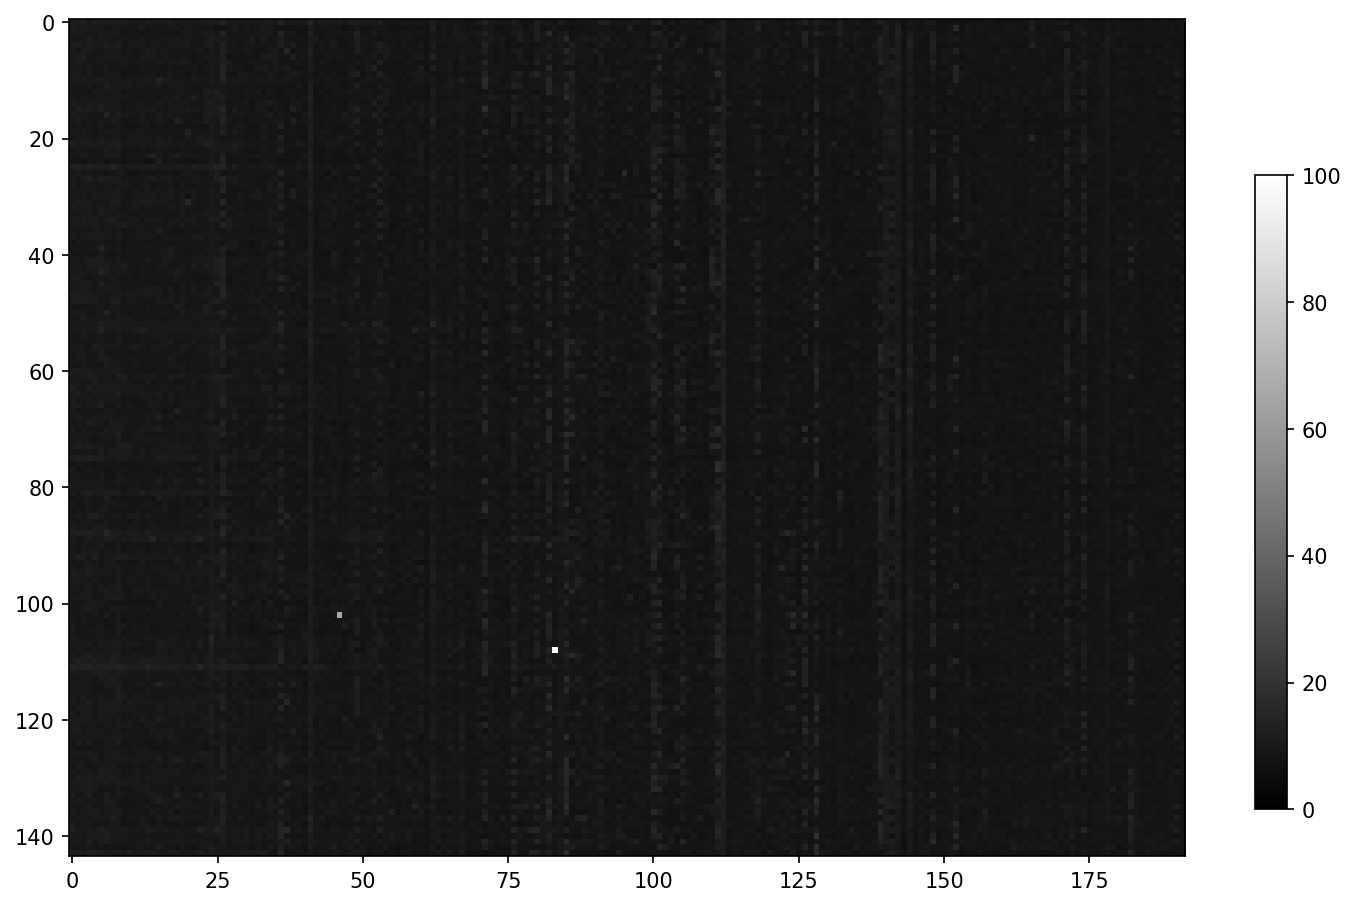

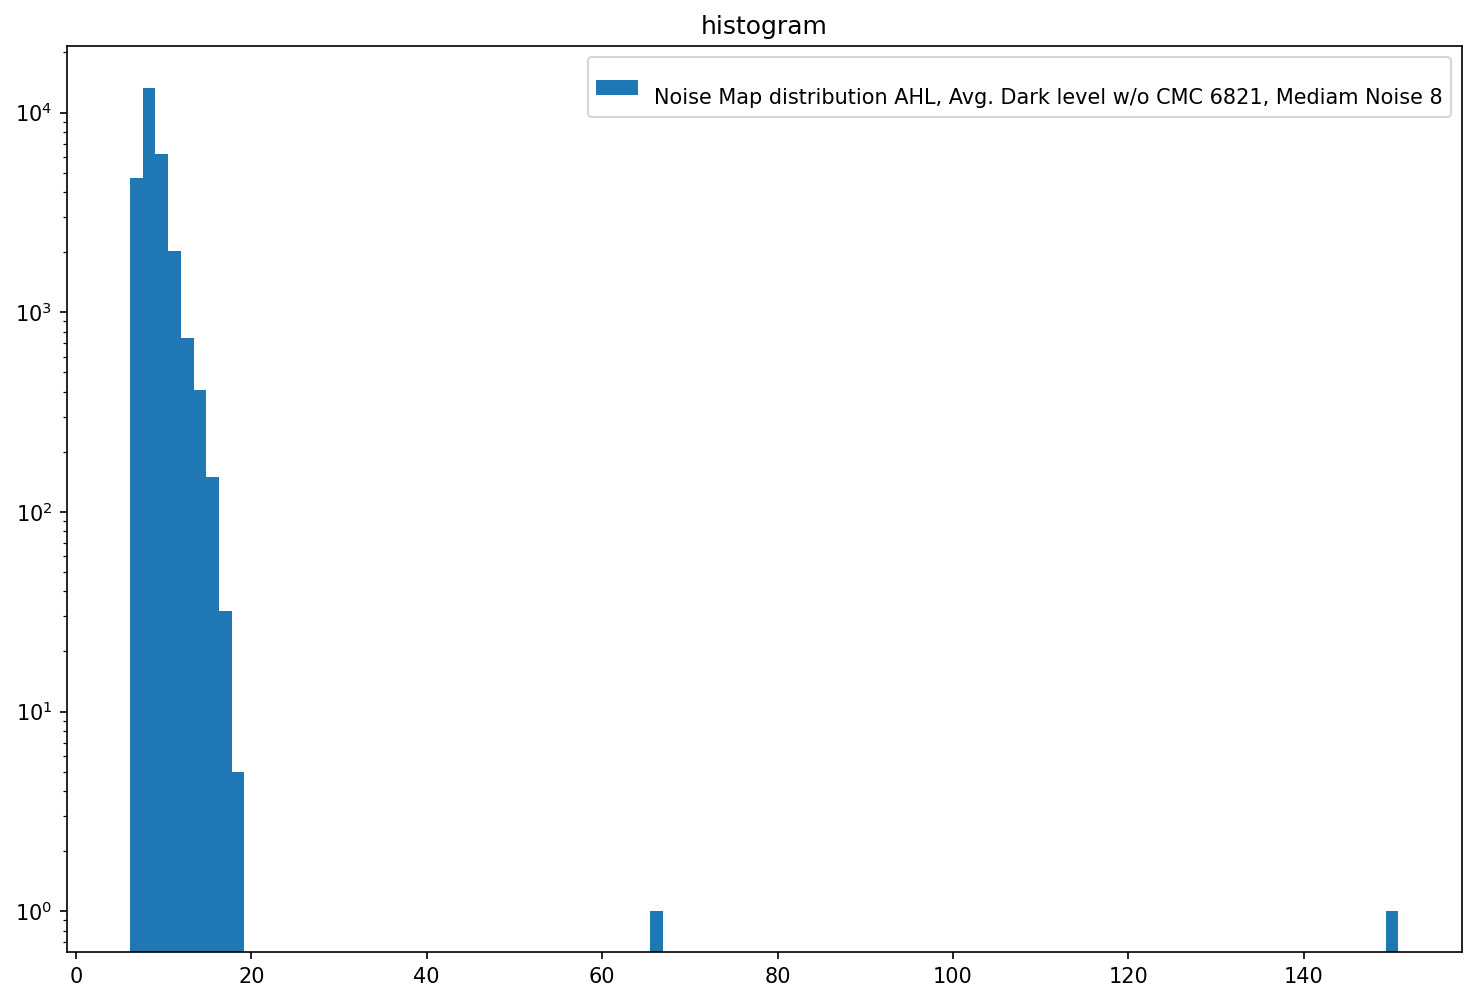

In [30]:
#new test, noise with CI
ASIC.test.set(0)


#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

#pulserList = np.arange(0, 240, 20, dtype = np.uint16)
pulserList = [512]
Preamp = 7
Vld1_b = 1
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 59
for pulser in pulserList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)
    #ASIC.Pulser.write(pr.UInt10(pulser))
    
    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_pulser_%d_testSetTo0_AllPixelsDisabled_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC, pulser))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

Preamp 7
Vld1_b 1
Pixel_CB 7
Filter_DAC 17
VRef_DAC 59
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_7_Vld1b_1_PixelCB_7_Filter_DAC_17_VRrefdac_59_run1.dat
Aquisition Counter 951301
Number of frames received: 10005
Number of frames received: 12007
Number of frames received: 14010
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


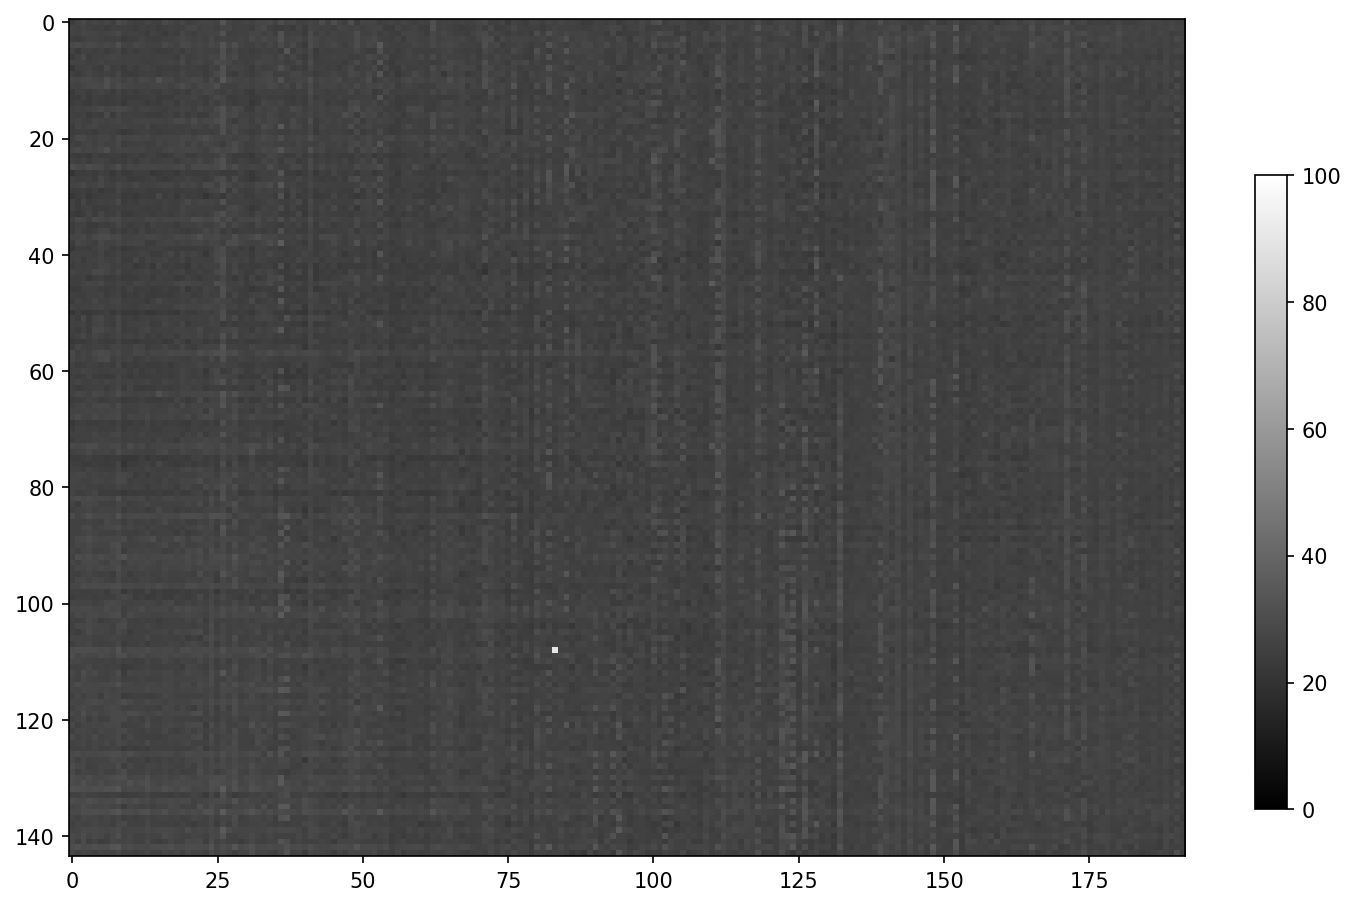

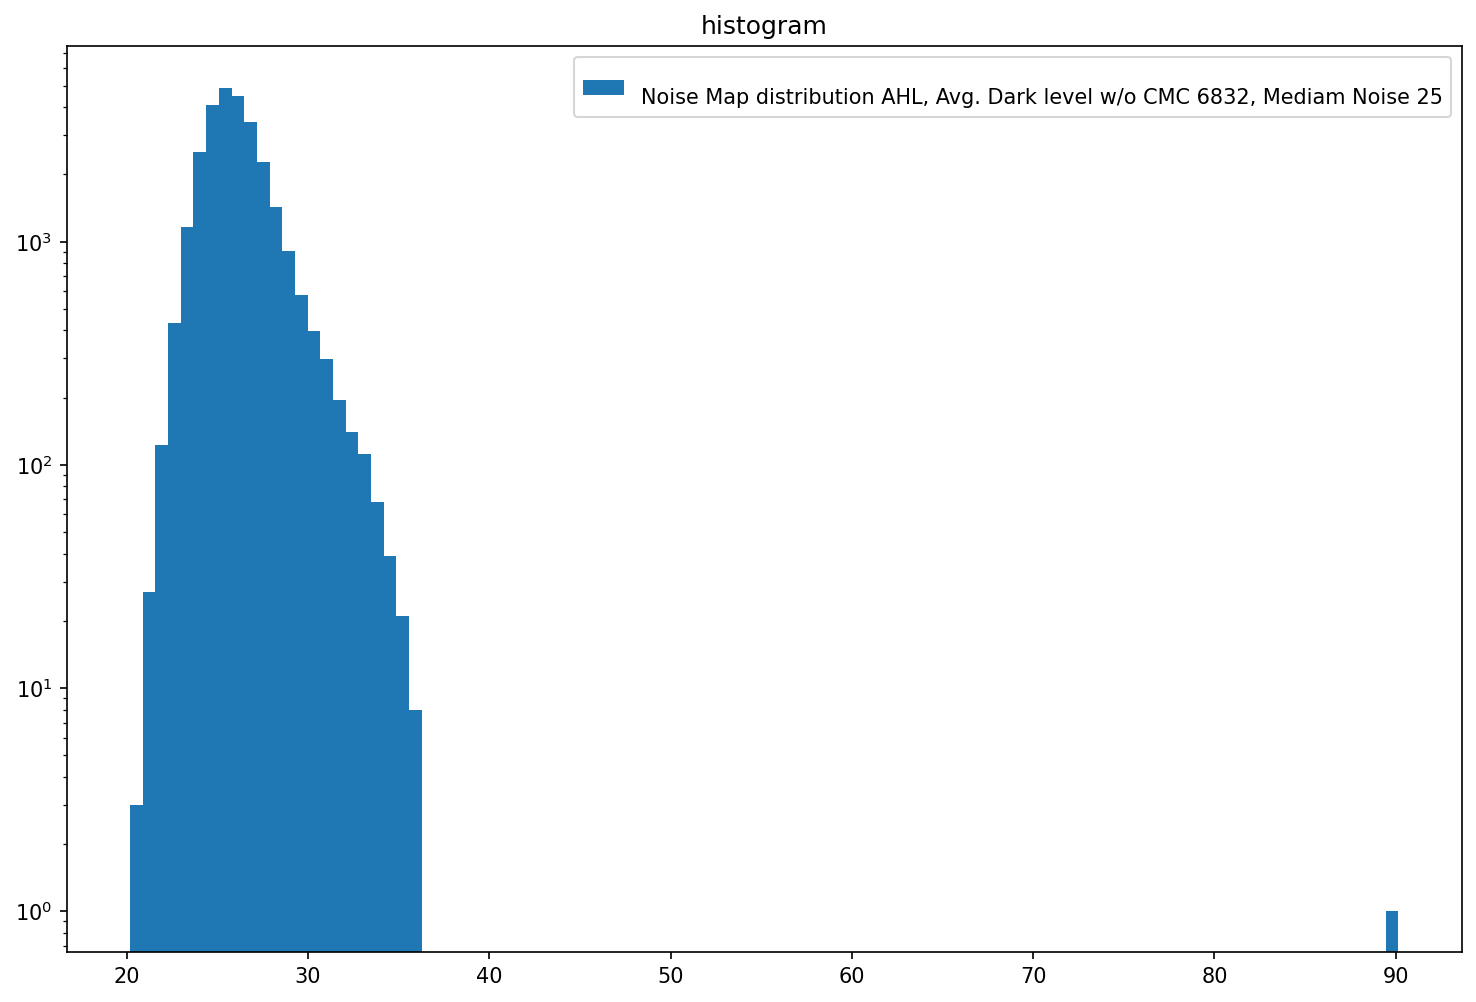


Preamp 6
Vld1_b 1
Pixel_CB 7
Filter_DAC 17
VRef_DAC 59
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_6_Vld1b_1_PixelCB_7_Filter_DAC_17_VRrefdac_59_run1.dat
Aquisition Counter 965311
Number of frames received: 10008
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


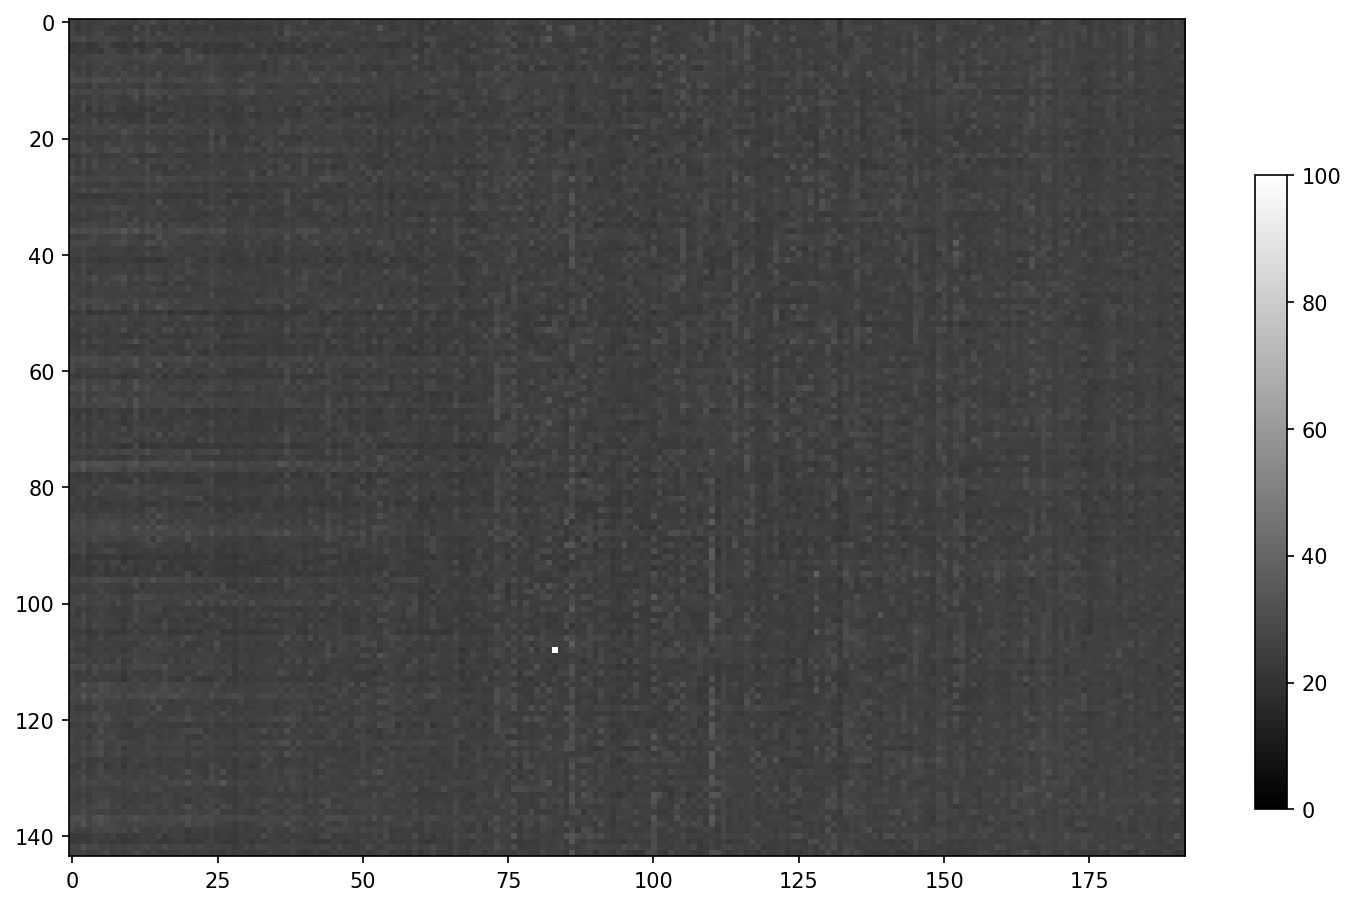

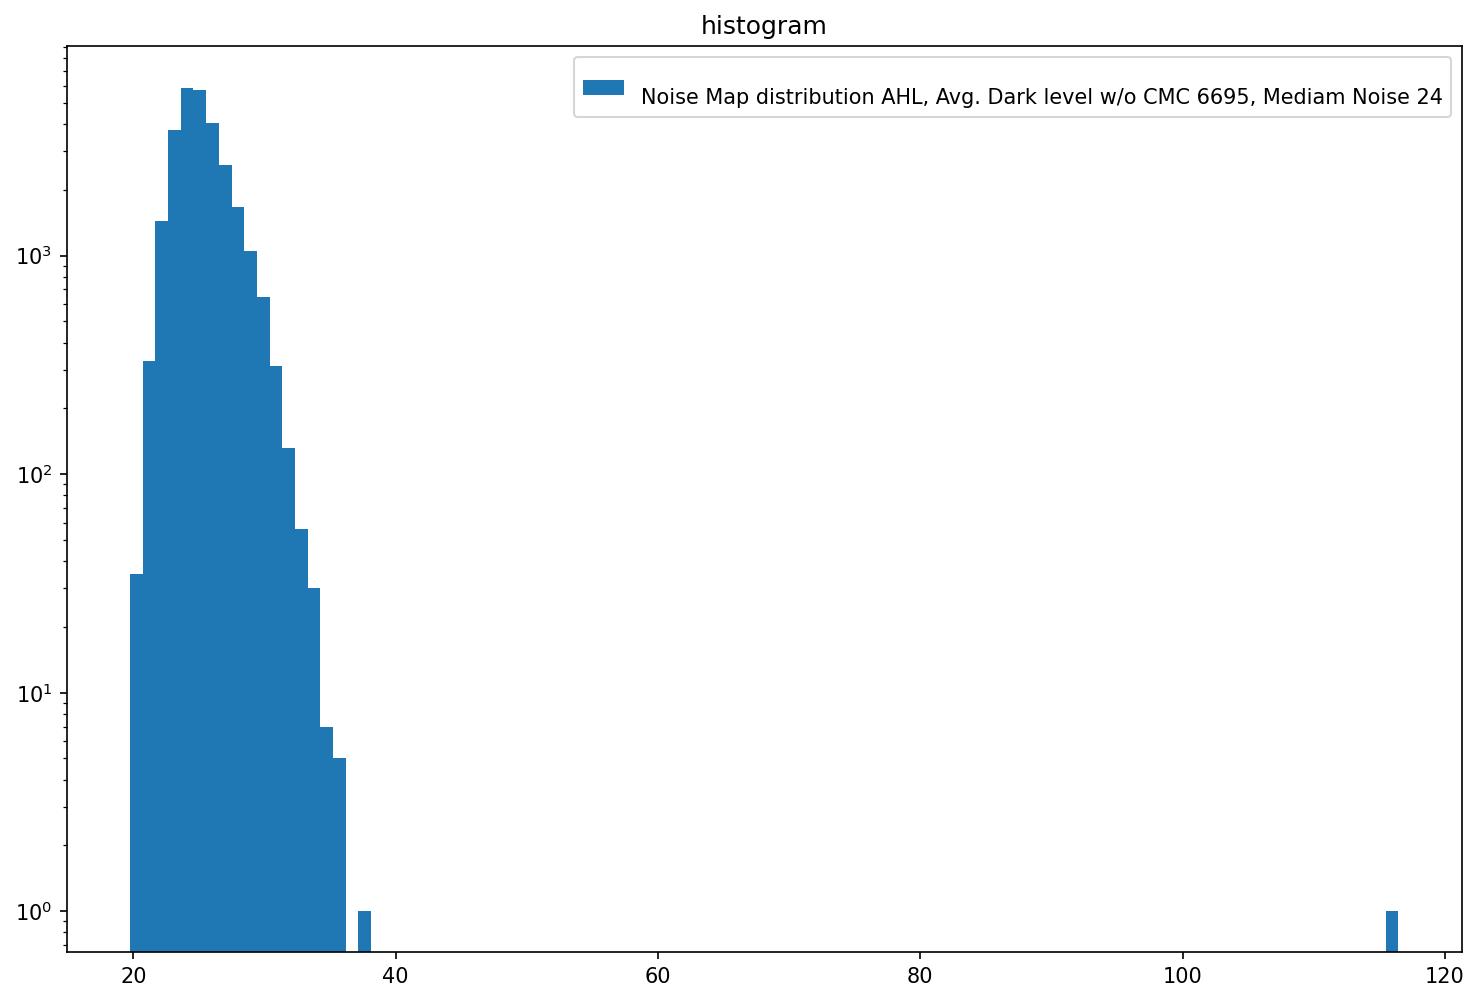


Preamp 5
Vld1_b 1
Pixel_CB 7
Filter_DAC 17
VRef_DAC 59
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_5_Vld1b_1_PixelCB_7_Filter_DAC_17_VRrefdac_59_run1.dat
Aquisition Counter 979325
Number of frames received: 10008
Number of frames received: 12011
Number of frames received: 14013
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


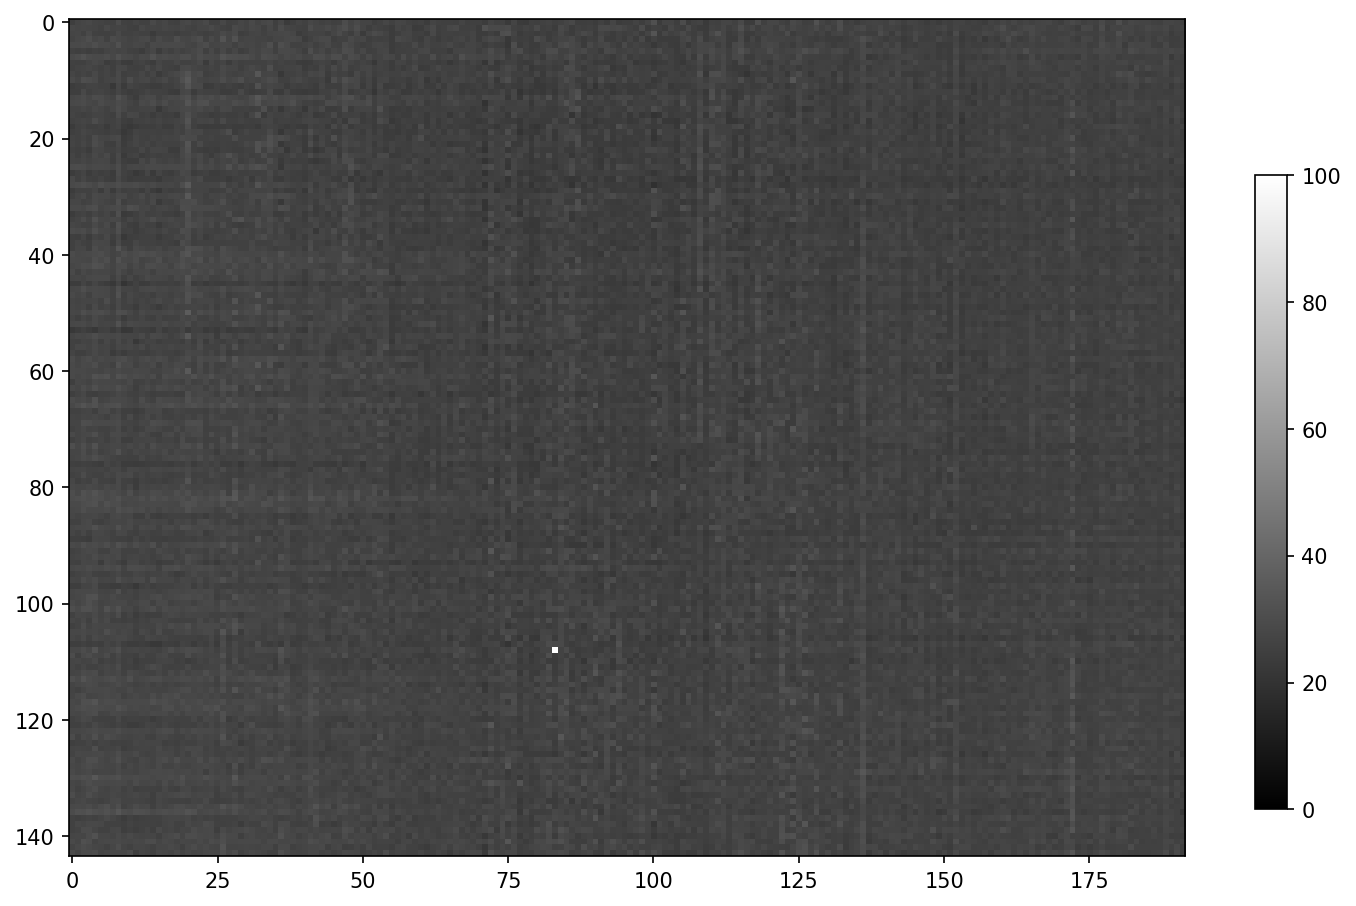

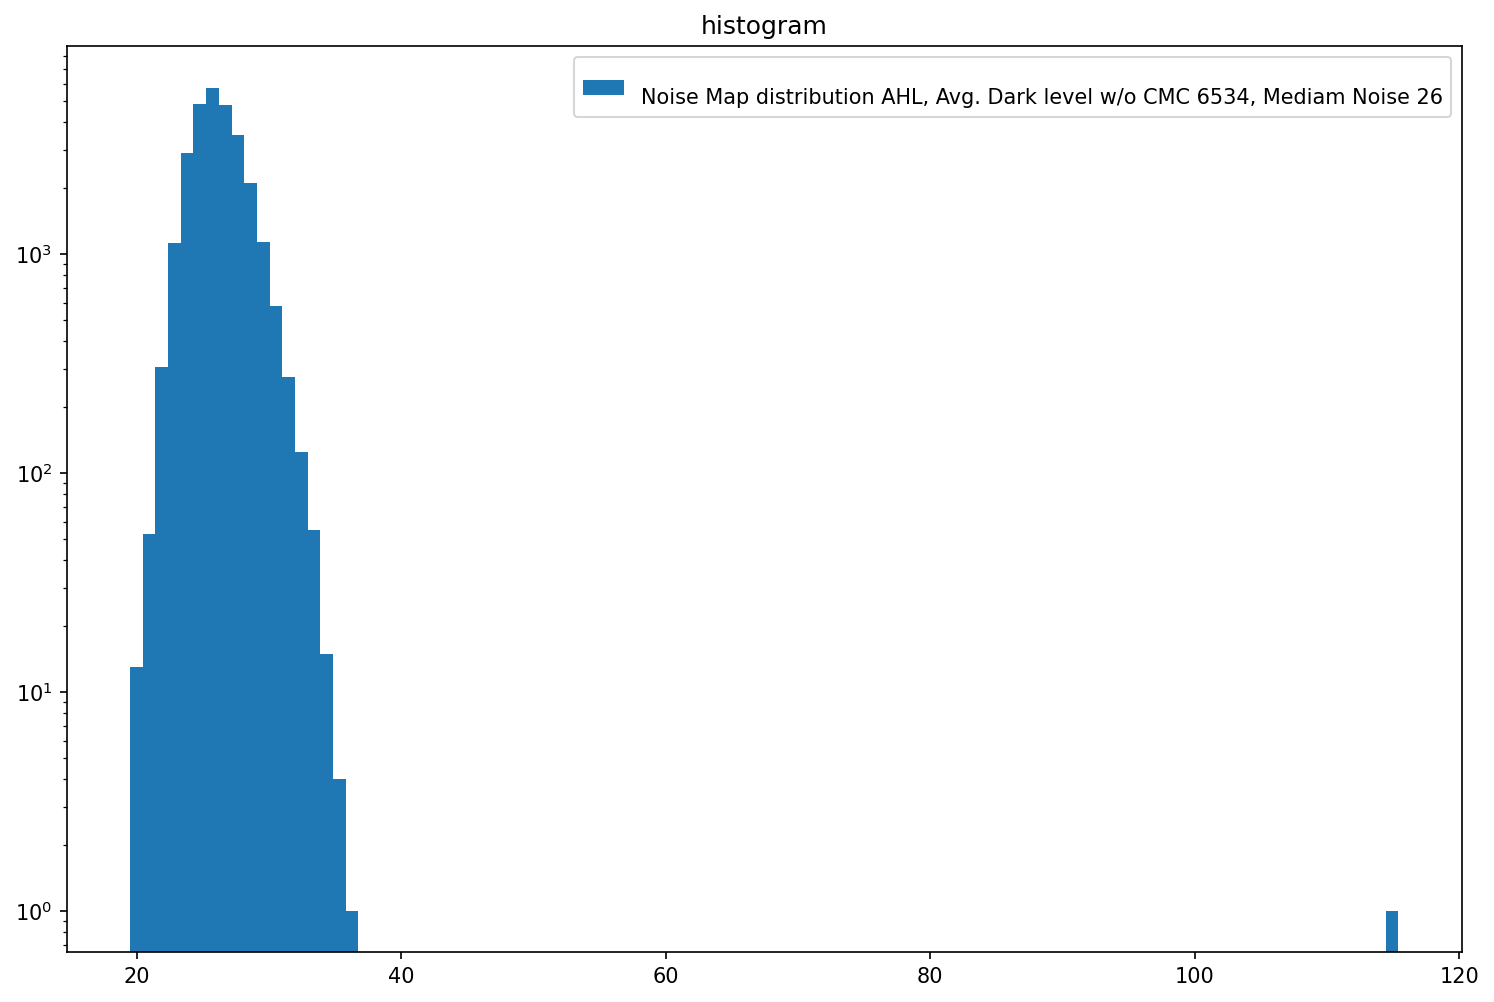


Preamp 4
Vld1_b 1
Pixel_CB 7
Filter_DAC 17
VRef_DAC 59
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_4_Vld1b_1_PixelCB_7_Filter_DAC_17_VRrefdac_59_run1.dat
Aquisition Counter 993338
Number of frames received: 10008
Number of frames received: 12011
Number of frames received: 14013
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


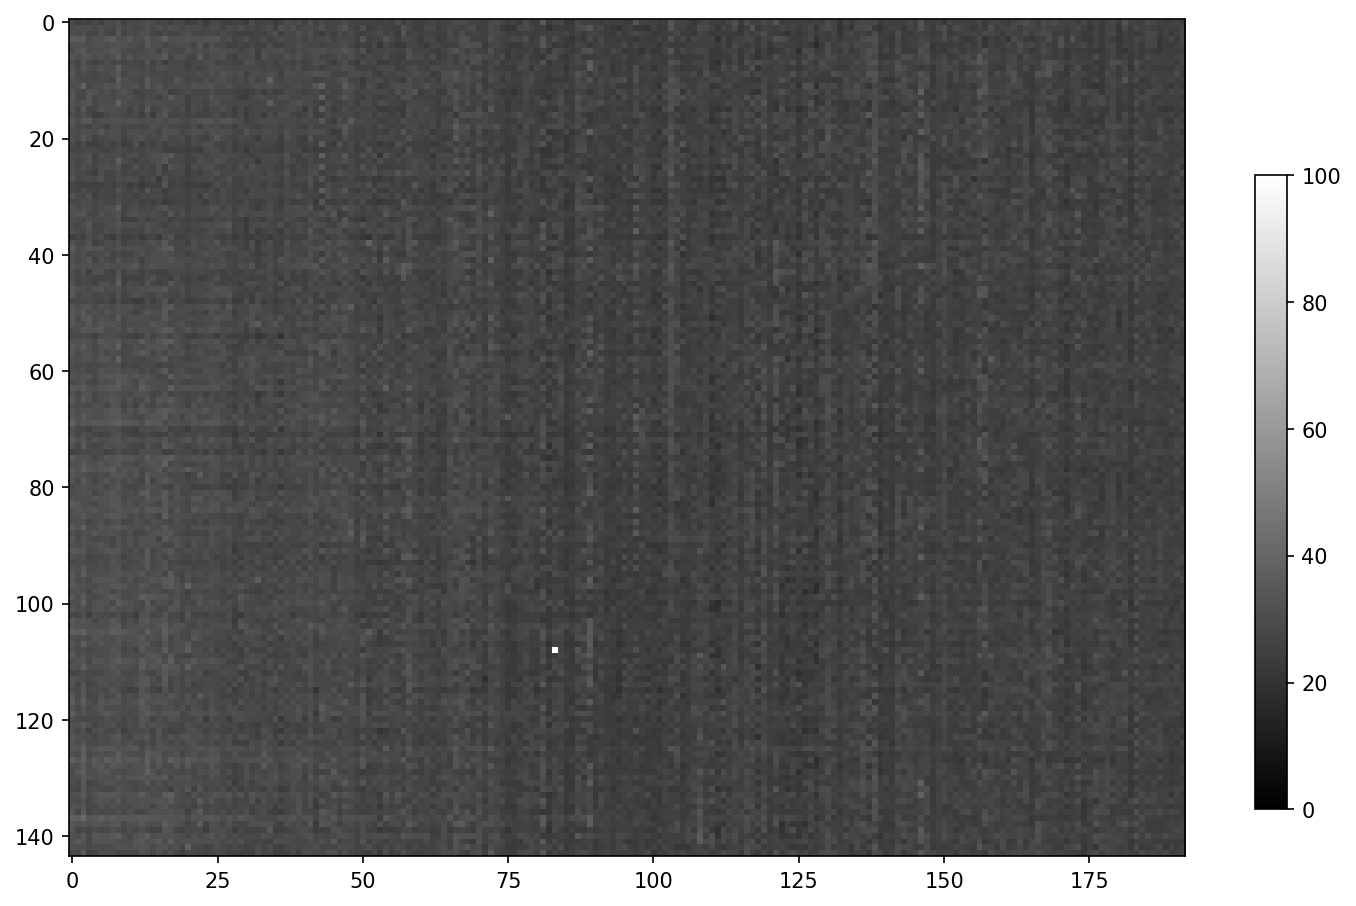

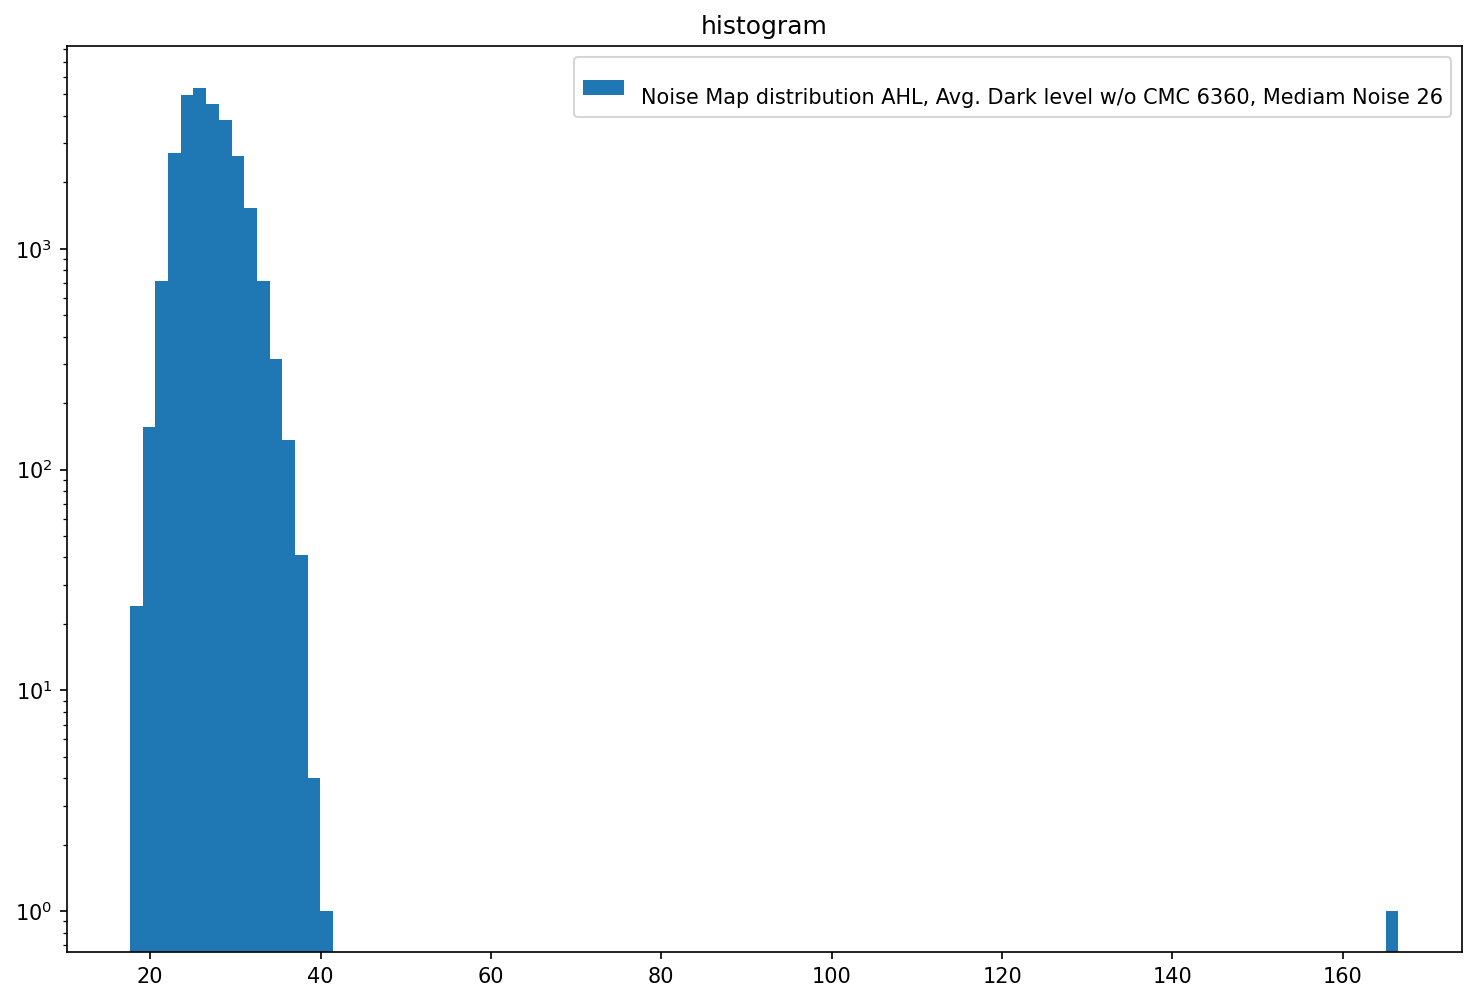


Preamp 3
Vld1_b 1
Pixel_CB 7
Filter_DAC 17
VRef_DAC 59
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_3_Vld1b_1_PixelCB_7_Filter_DAC_17_VRrefdac_59_run1.dat
Aquisition Counter 1007351
Number of frames received: 10008
Number of frames received: 12010
Number of frames received: 14012
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


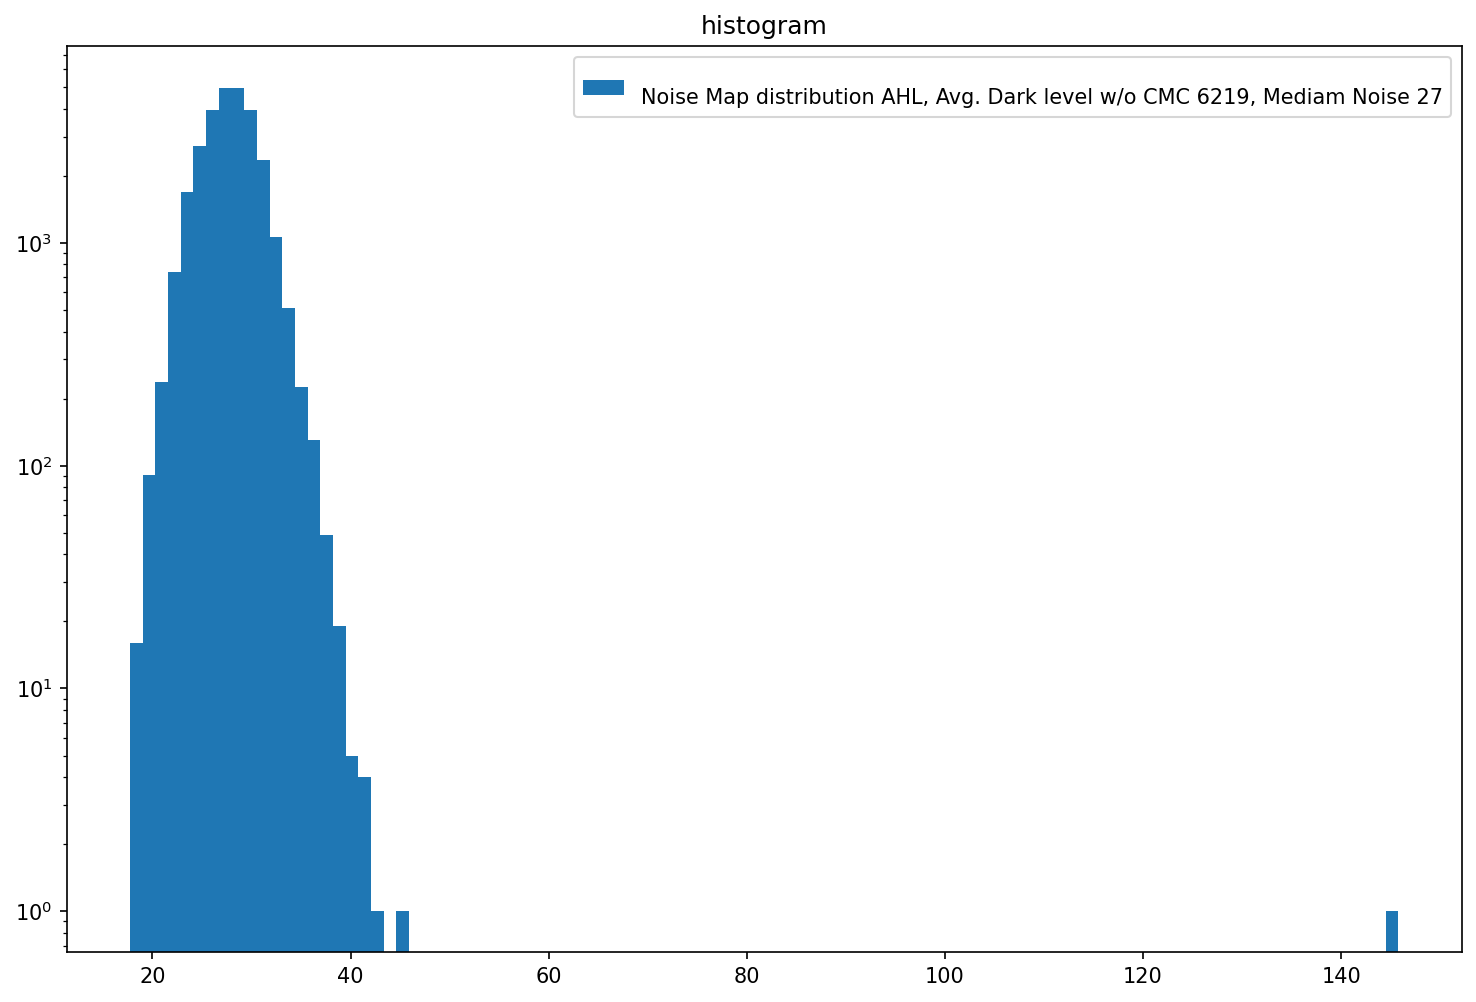


Preamp 2
Vld1_b 1
Pixel_CB 7
Filter_DAC 17
VRef_DAC 59
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_1_PixelCB_7_Filter_DAC_17_VRrefdac_59_run1.dat
Aquisition Counter 1021363
Number of frames received: 10009
Number of frames received: 12012
Number of frames received: 14015
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


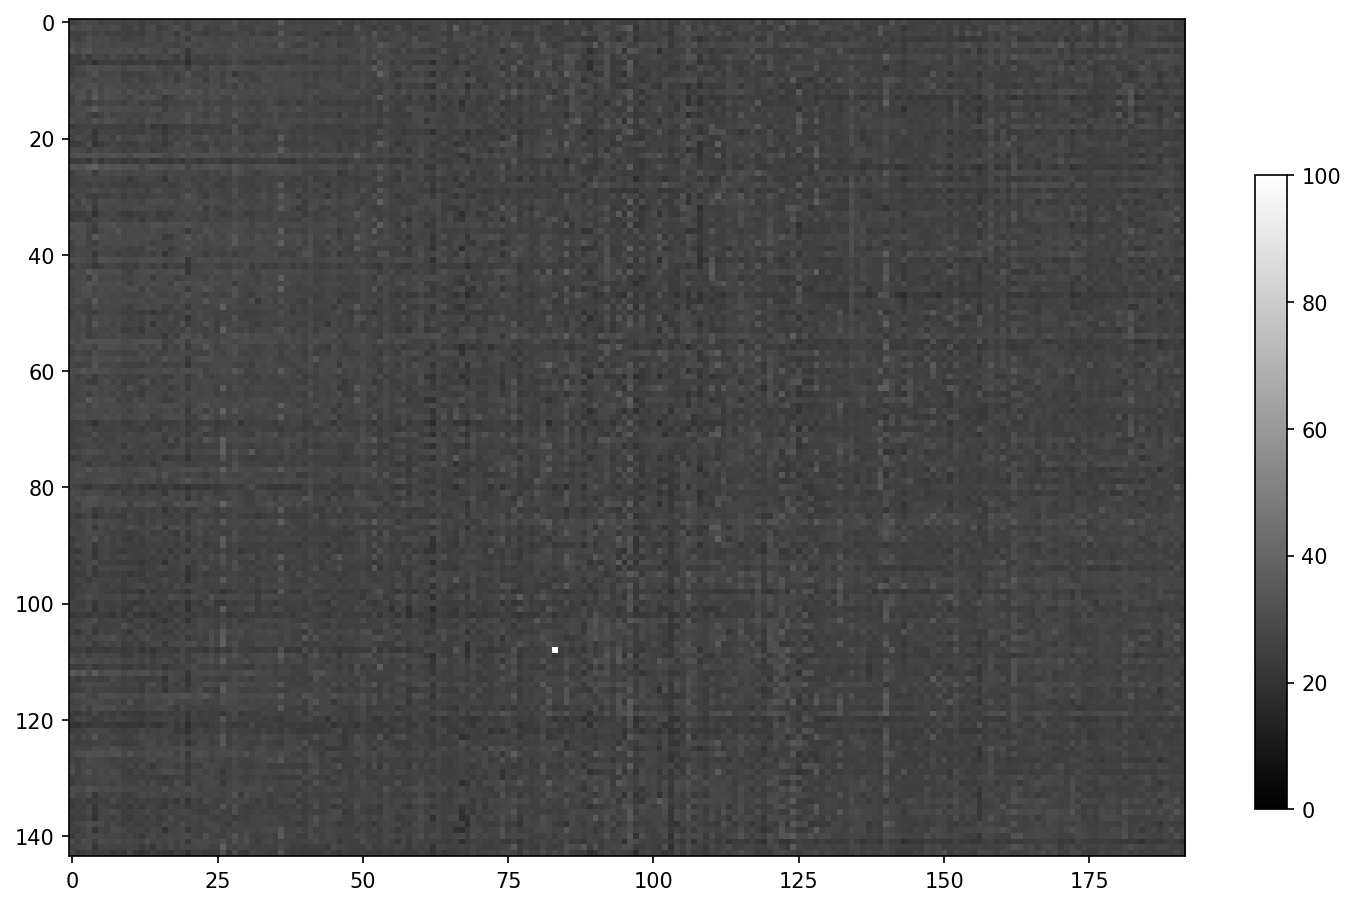

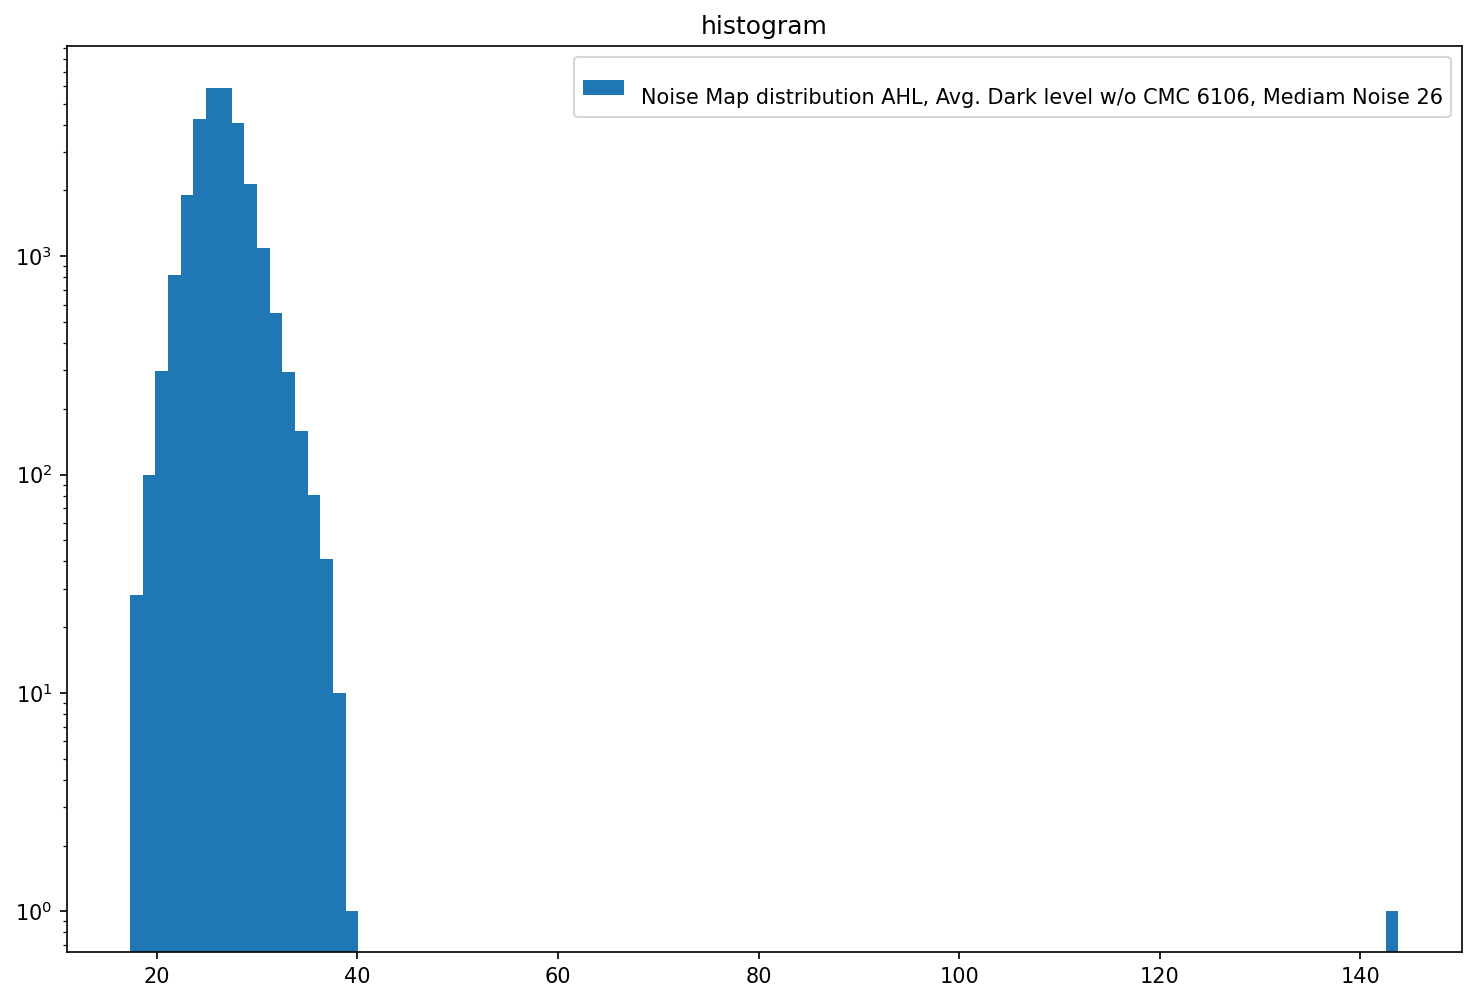


Preamp 1
Vld1_b 1
Pixel_CB 7
Filter_DAC 17
VRef_DAC 59
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_1_Vld1b_1_PixelCB_7_Filter_DAC_17_VRrefdac_59_run1.dat
Aquisition Counter 1035378
Number of frames received: 10008
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


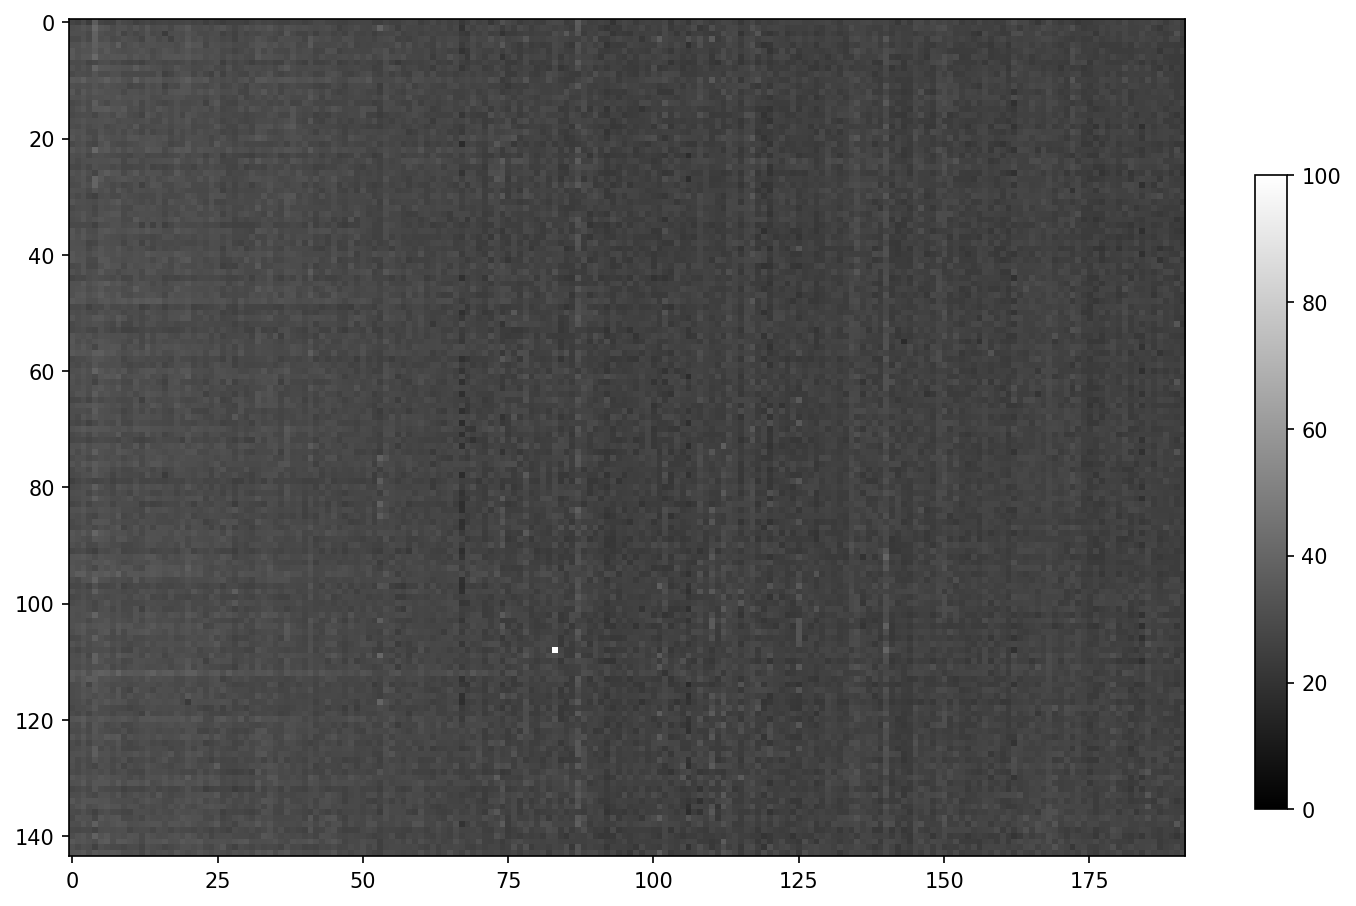

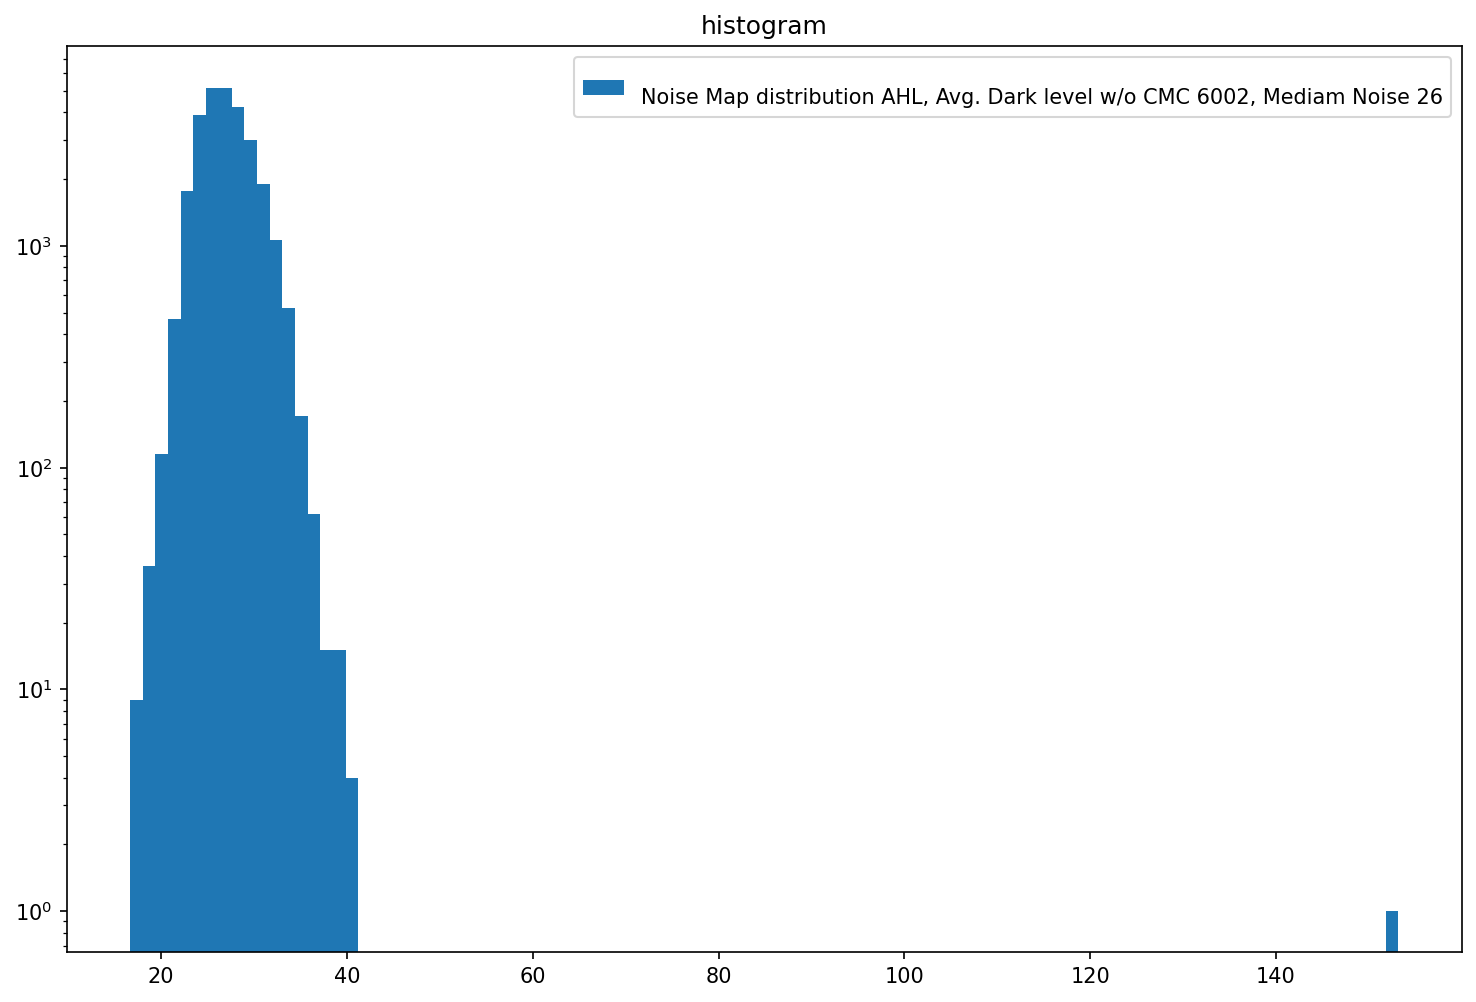


Preamp 0
Vld1_b 1
Pixel_CB 7
Filter_DAC 17
VRef_DAC 59
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_0_Vld1b_1_PixelCB_7_Filter_DAC_17_VRrefdac_59_run1.dat
Aquisition Counter 1049392
Number of frames received: 10008
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


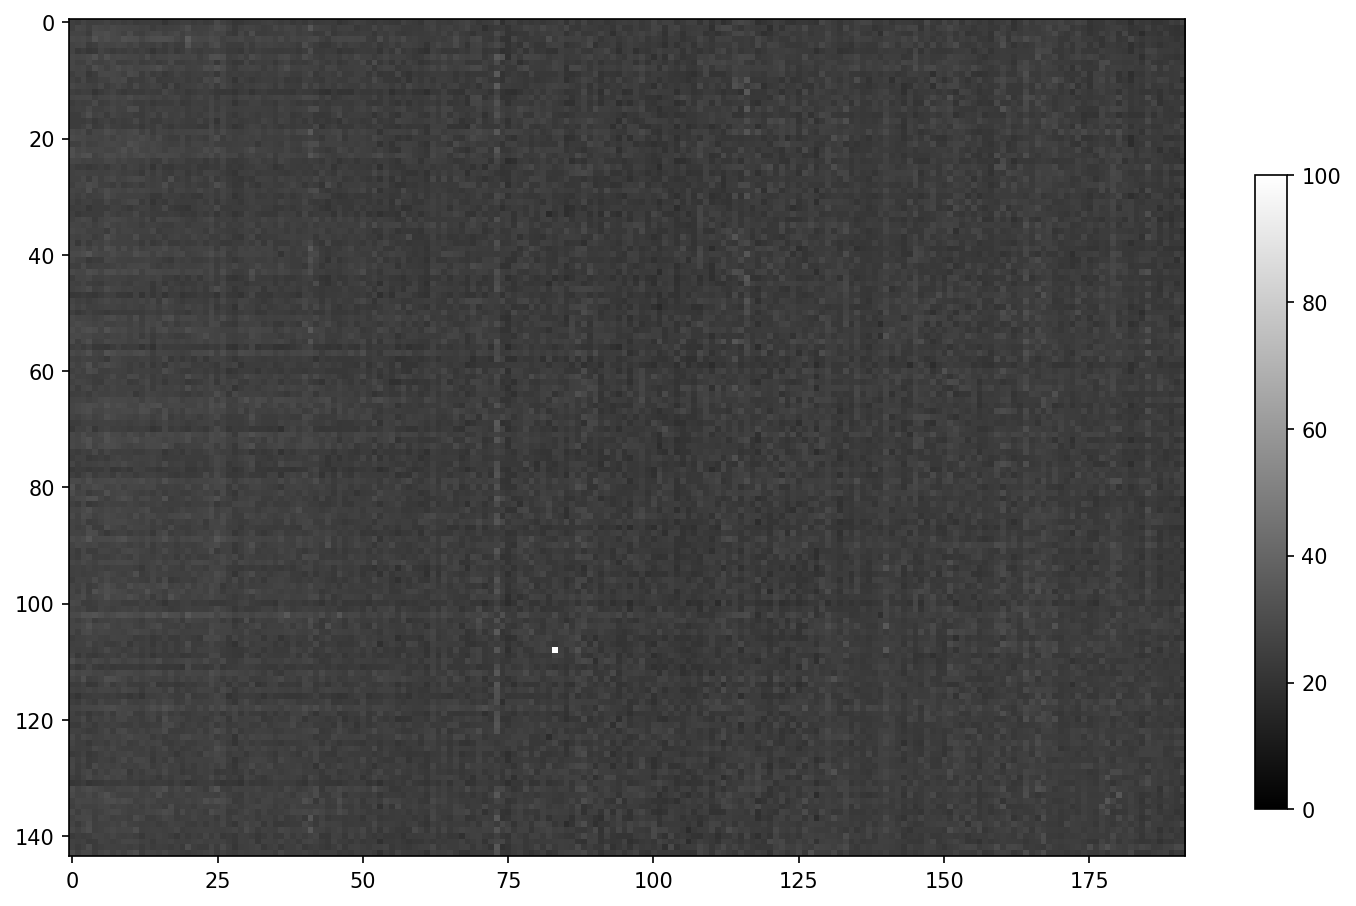

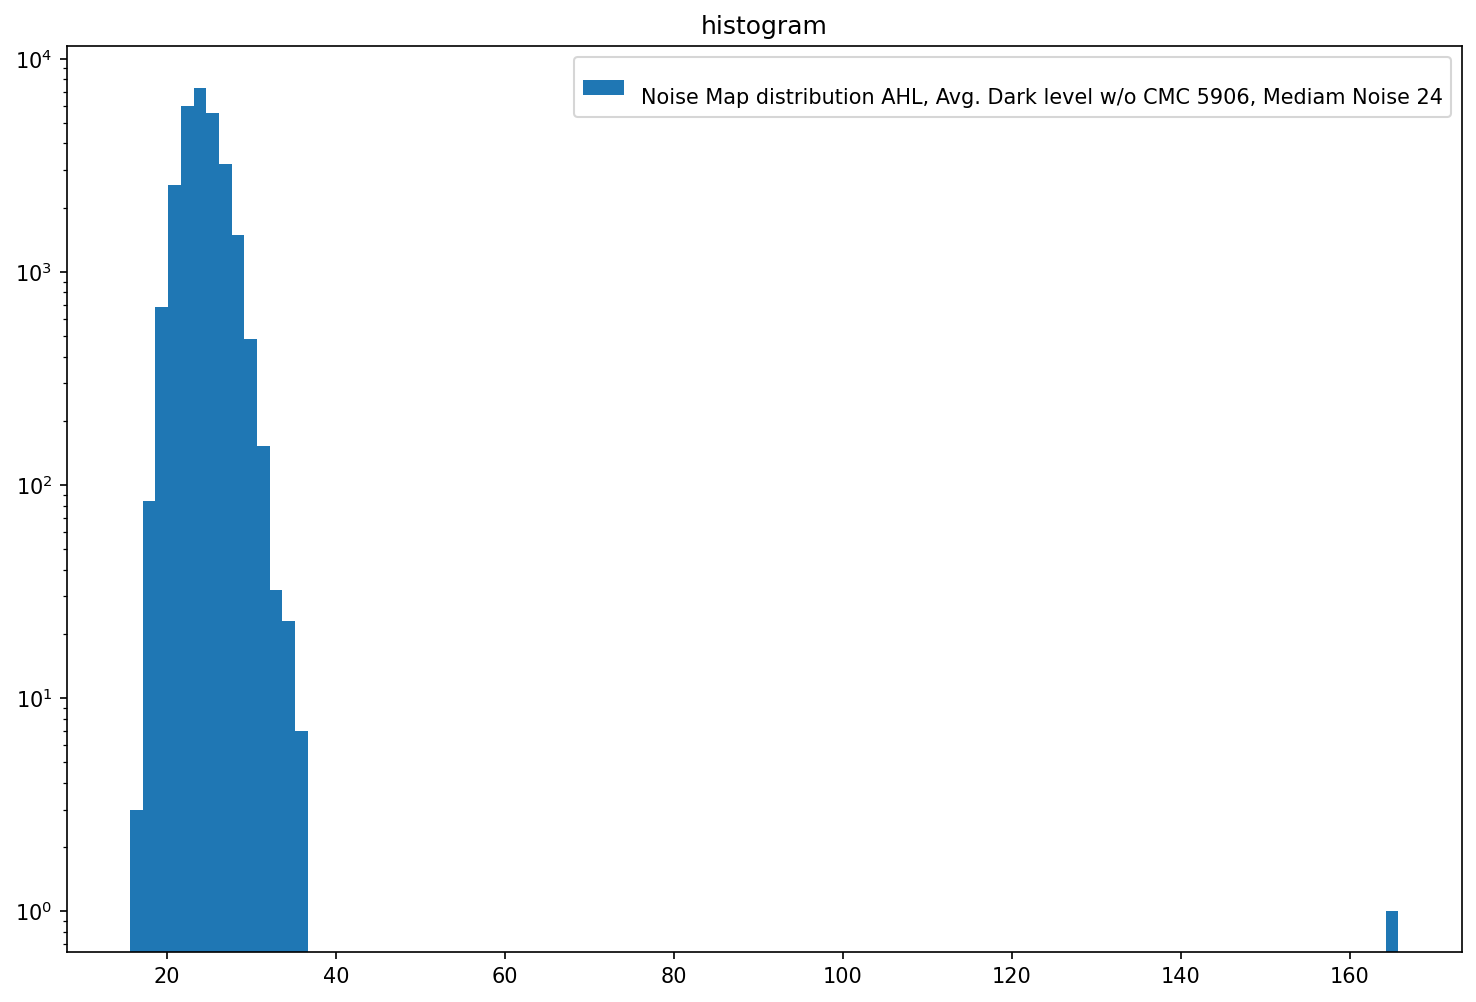


Rysync ASIC started
Init ASIC script started
Loading MMCM configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_MMCM_320MHz.yml
Completed
Loading supply configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PowerSupply_Enable.yml
Loading register control (waveforms) configuration
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_RegisterControl_24us_248MHz.yml
Loading packet registers
Disabling packet lanes for ASIC 0
Disabling packet lanes for ASIC 1
Disabling packet lanes for ASIC 3
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PacketRegisters.yml
Taking asic off of reset
Loading ASIC and timing configuration
Loading  /u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/notebooks/..//yml/ePixHr10kT_PLLBypass_248MHz_ASIC_2.yml
Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.Ep

In [27]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

PreampList = [7,6,5,4,3,2,1,0]
Vld1_b = 1
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 59
for Preamp in PreampList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

Preamp 7
Vld1_b 1
Pixel_CB 7
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_7_Vld1b_1_PixelCB_7_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1117050
Number of frames received: 10001
Number of frames received: 12004
Number of frames received: 14006
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


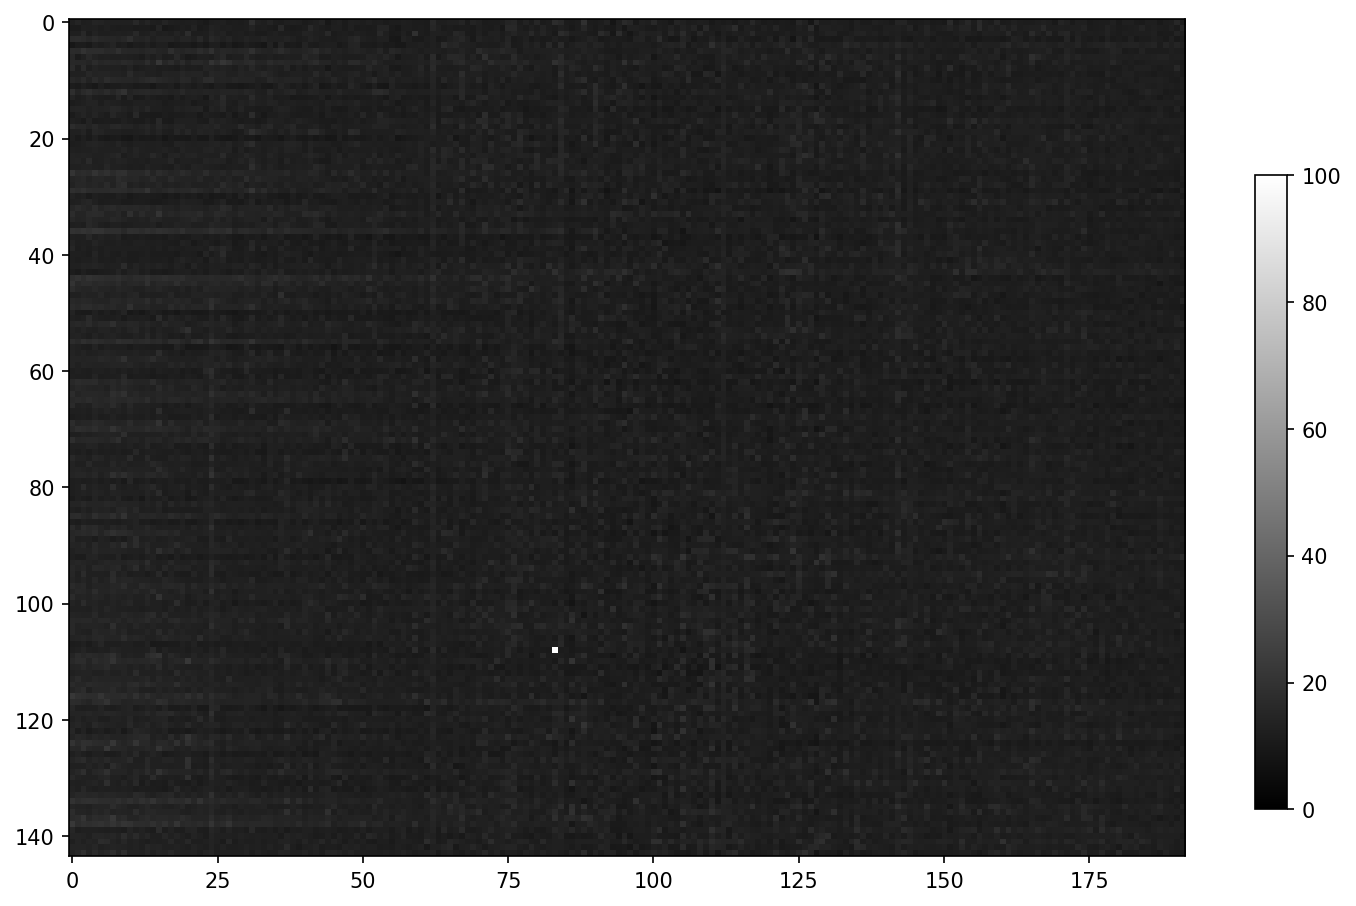

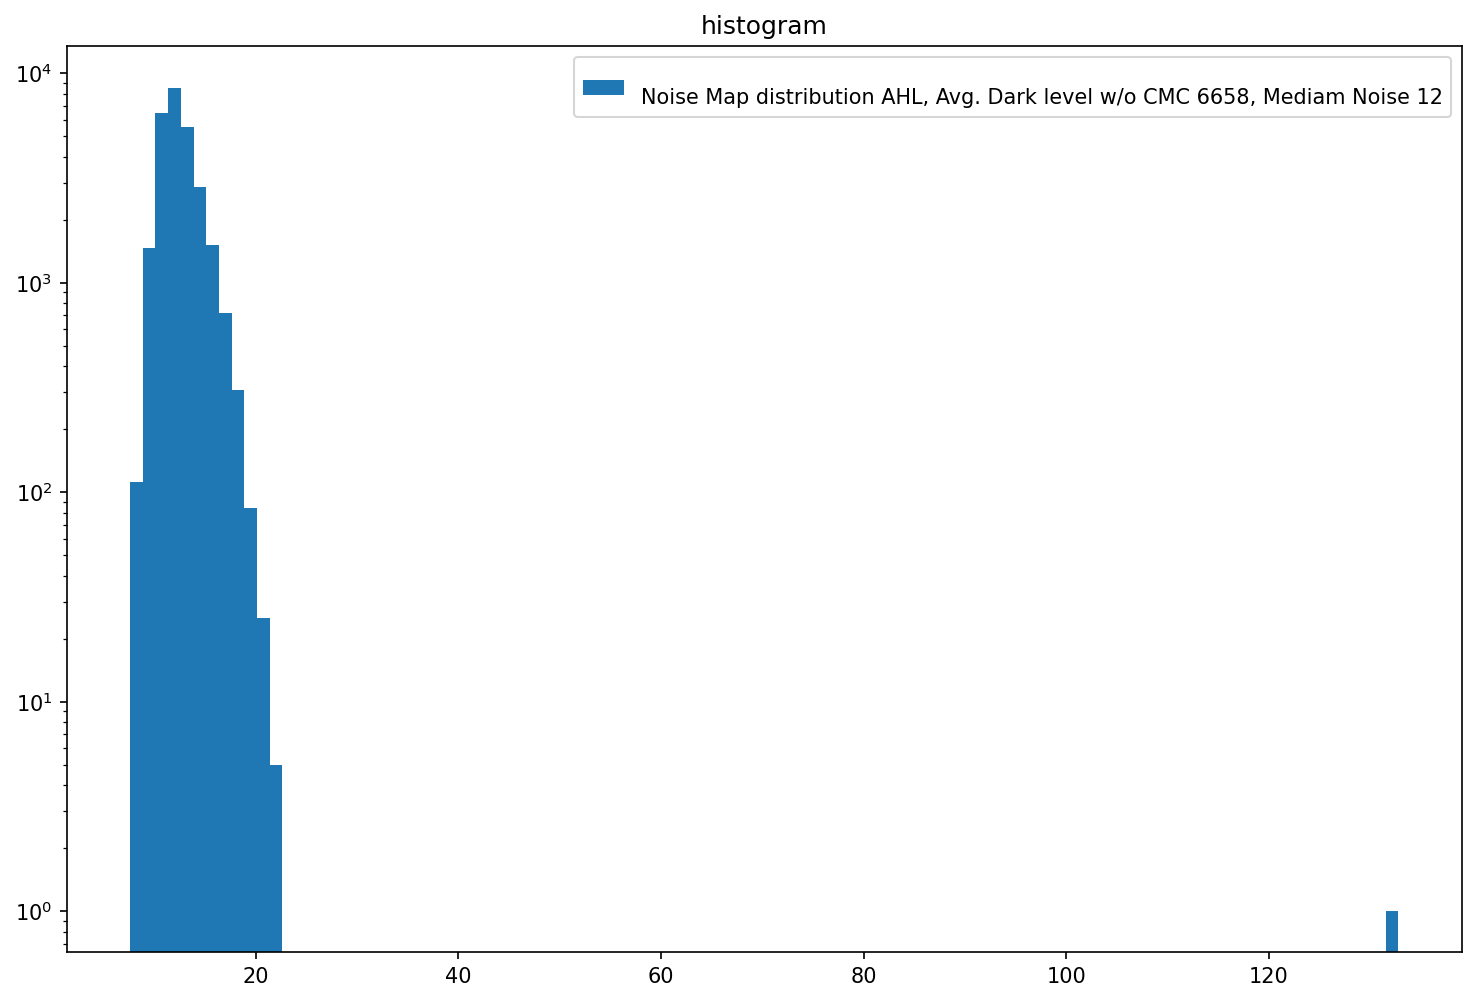

In [32]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

PreampList = [7]#,6,5,4,3,2,1,0]
Vld1_b = 1
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 58
for Preamp in PreampList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

Preamp 7
Vld1_b 1
Pixel_CB 7
Filter_DAC 17
VRef_DAC 56
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_7_Vld1b_1_PixelCB_7_Filter_DAC_17_VRrefdac_56_run1.dat
Aquisition Counter 1102638
Number of frames received: 10008
Number of frames received: 12010
Number of frames received: 14013
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


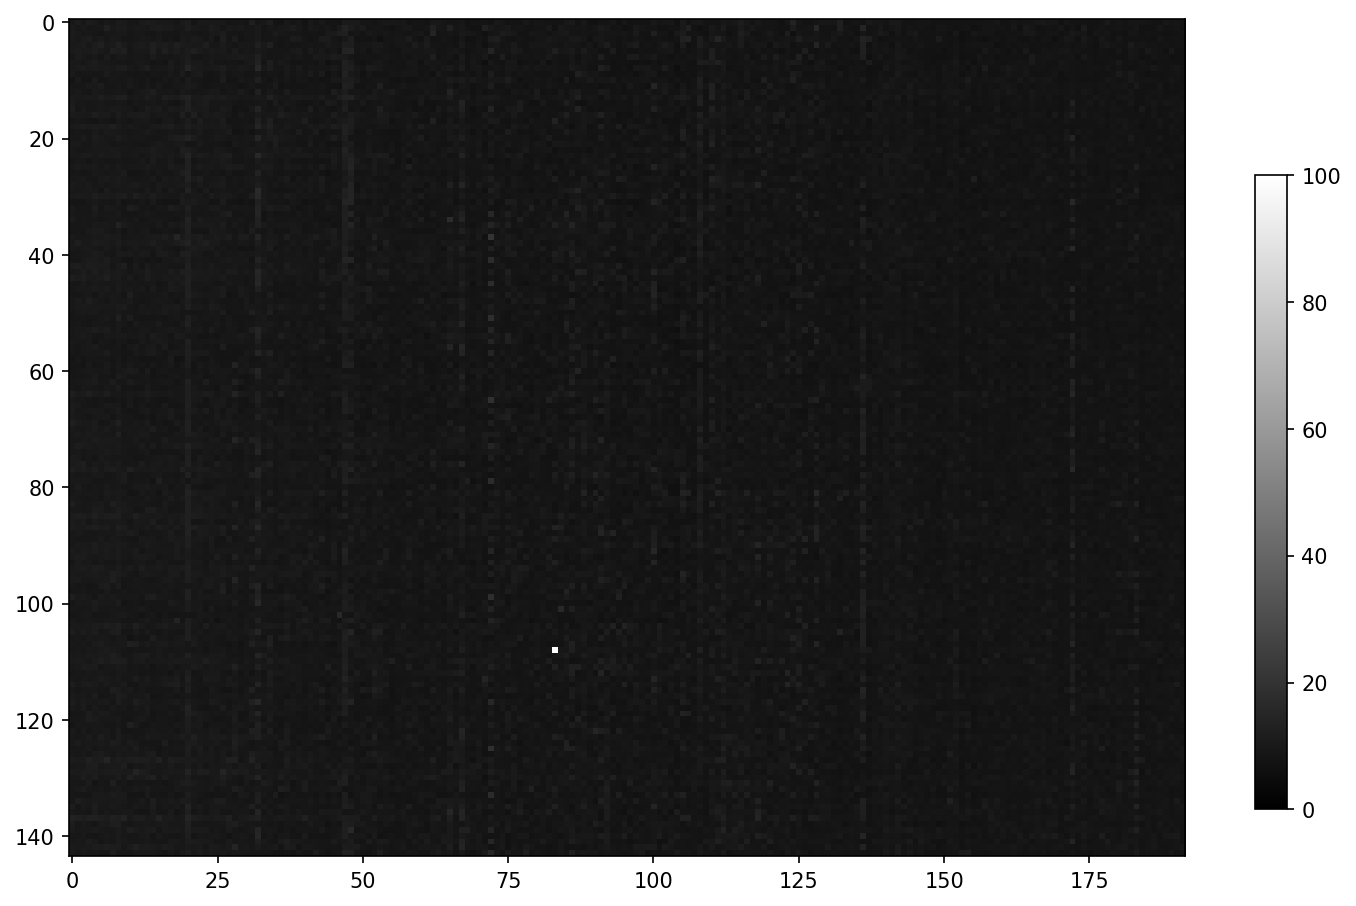

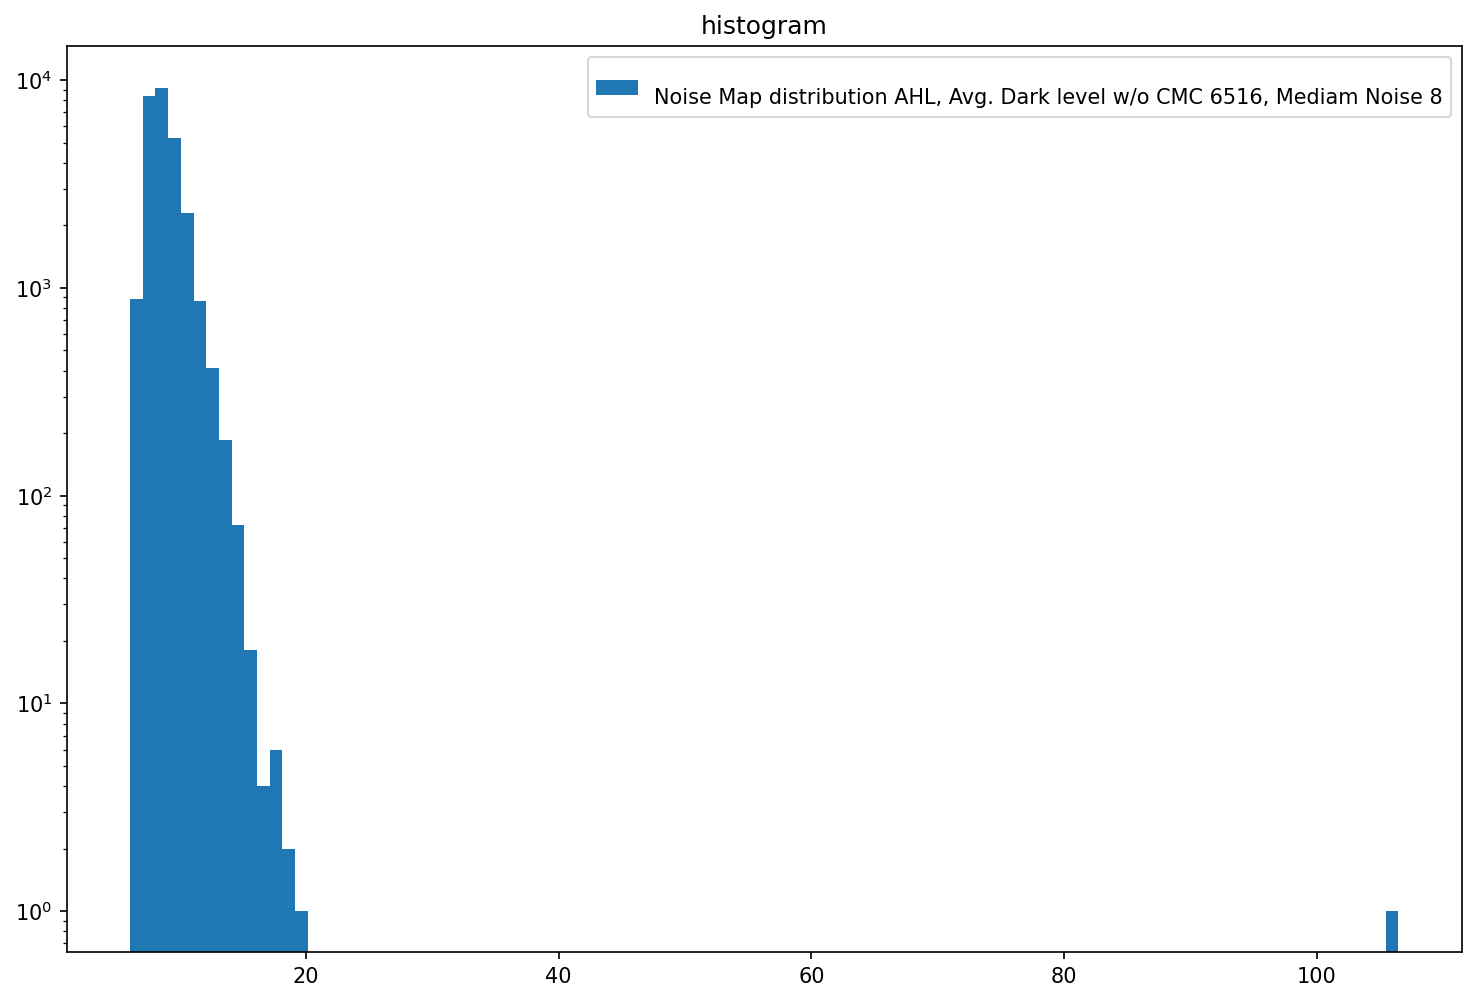


Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.EpixHR.Hr10kTAsic2.ClearMatrix
Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.EpixHR.Hr10kTAsic2.ClearMatrix
Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.EpixHR.Hr10kTAsic2.ClearMatrix


In [31]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.2)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.2)

PreampList = [7]#,6,5,4,3,2,1,0]
Vld1_b = 1
Pixel_CB= 7
Filter_DAC= 17
VRef_DAC = 58
for Preamp in PreampList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB_SET_2/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

In [29]:
ASIC.SetPixelBitmap('/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/pixelBitMaps/allTwos.csv')

Command executed :  <class 'pyrogue._Command.BaseCommand'> - ePixHr10kT.EpixHR.Hr10kTAsic2.SetPixelBitmap
/u1/ddoering/localGitAtrdsrv304/epix-hr-single-10k/software/pixelBitMaps/allTwos.csv
ASIC V3


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1039091
Number of frames received: 10009
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


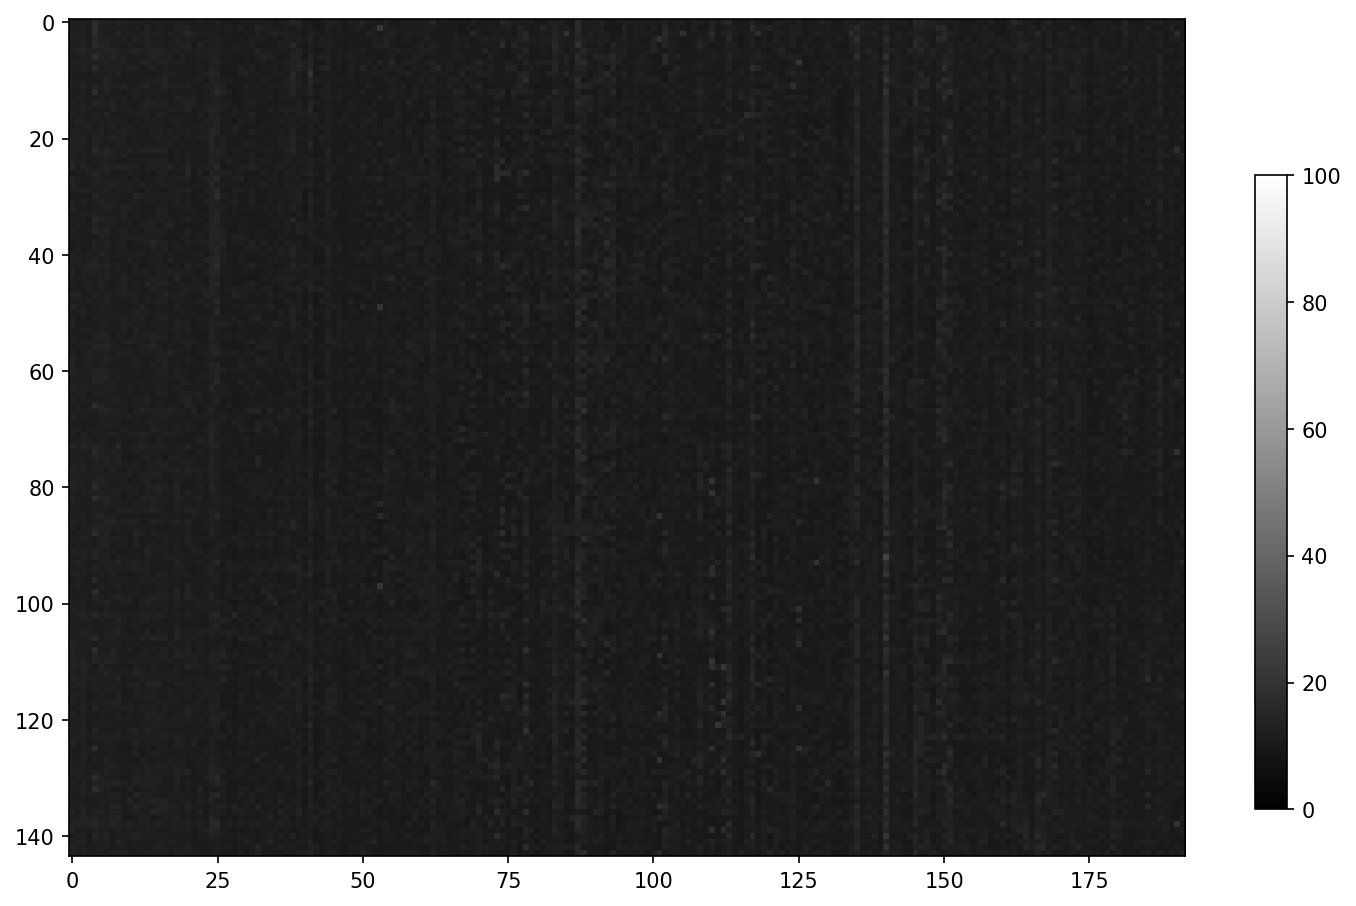

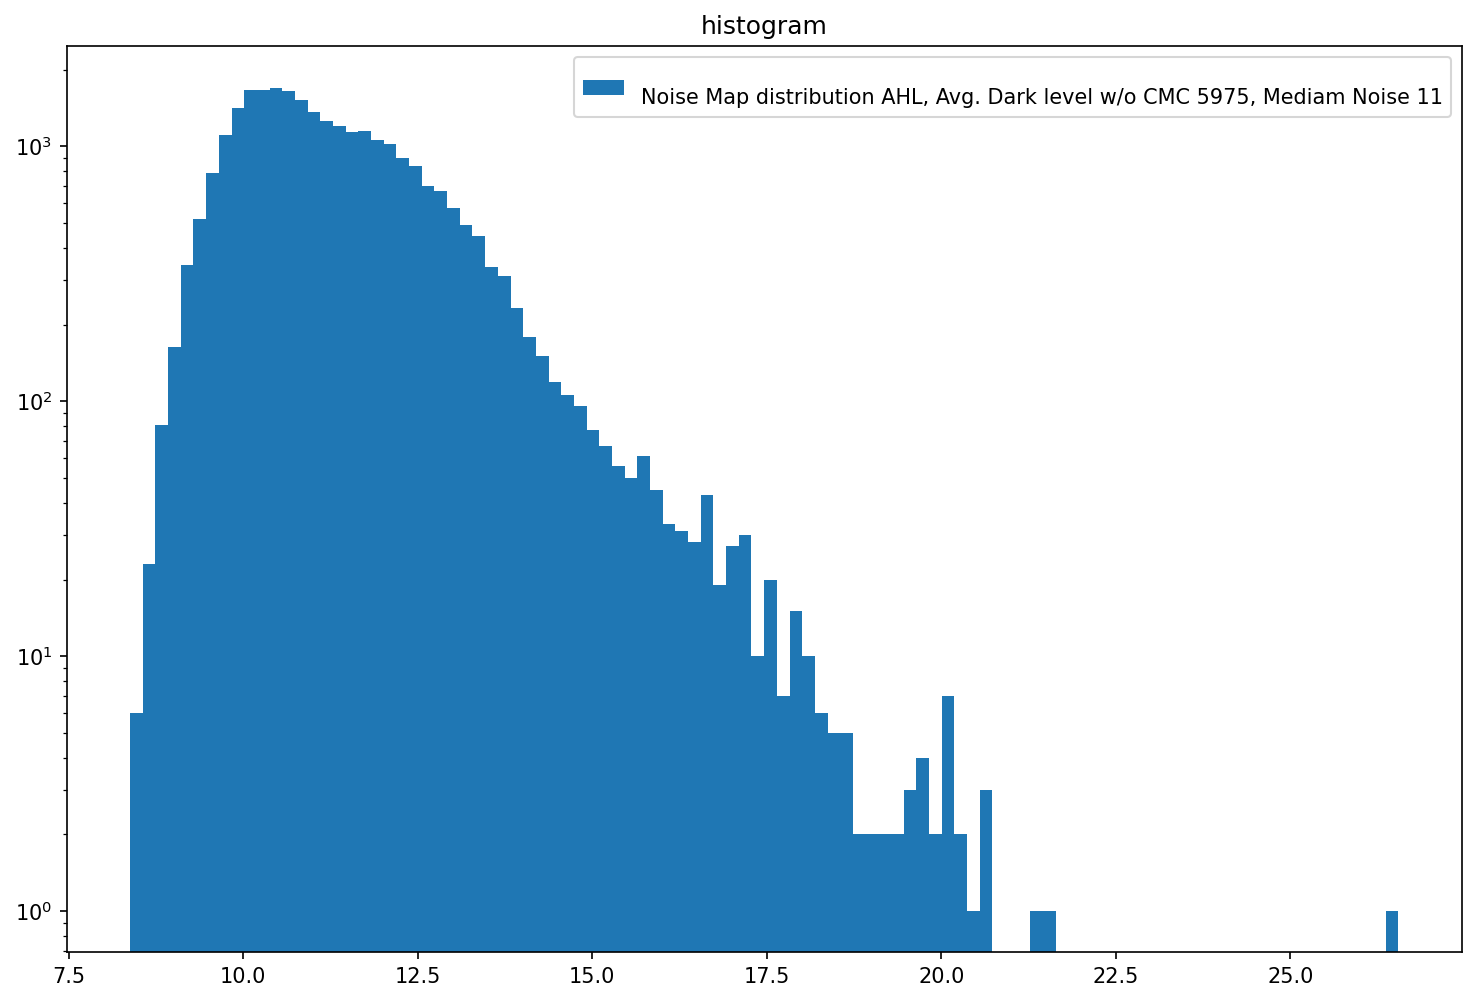


Preamp 2
Vld1_b 1
Pixel_CB 2
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_1_PixelCB_2_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1053105
Number of frames received: 10009
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


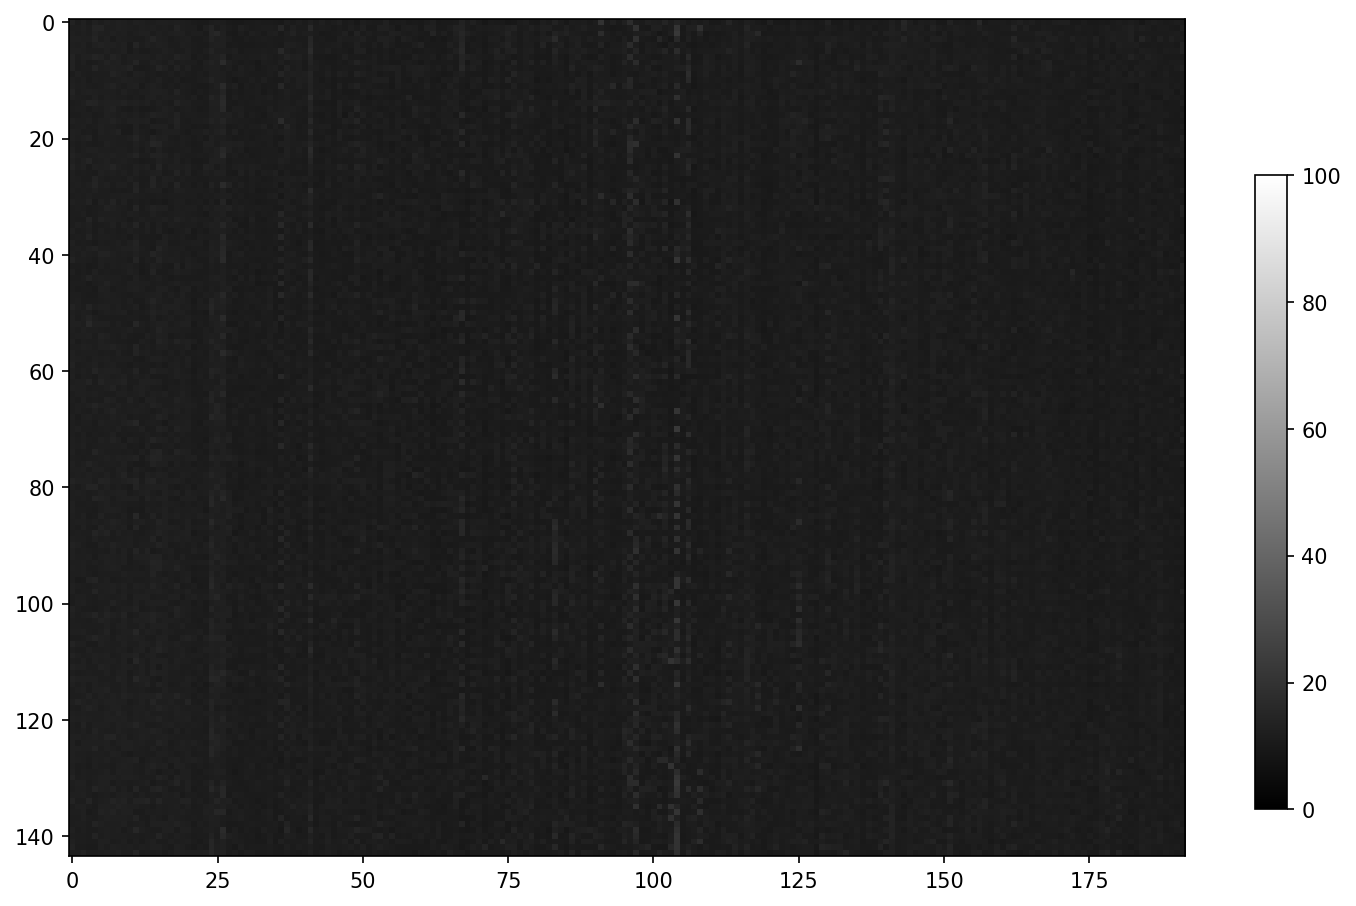

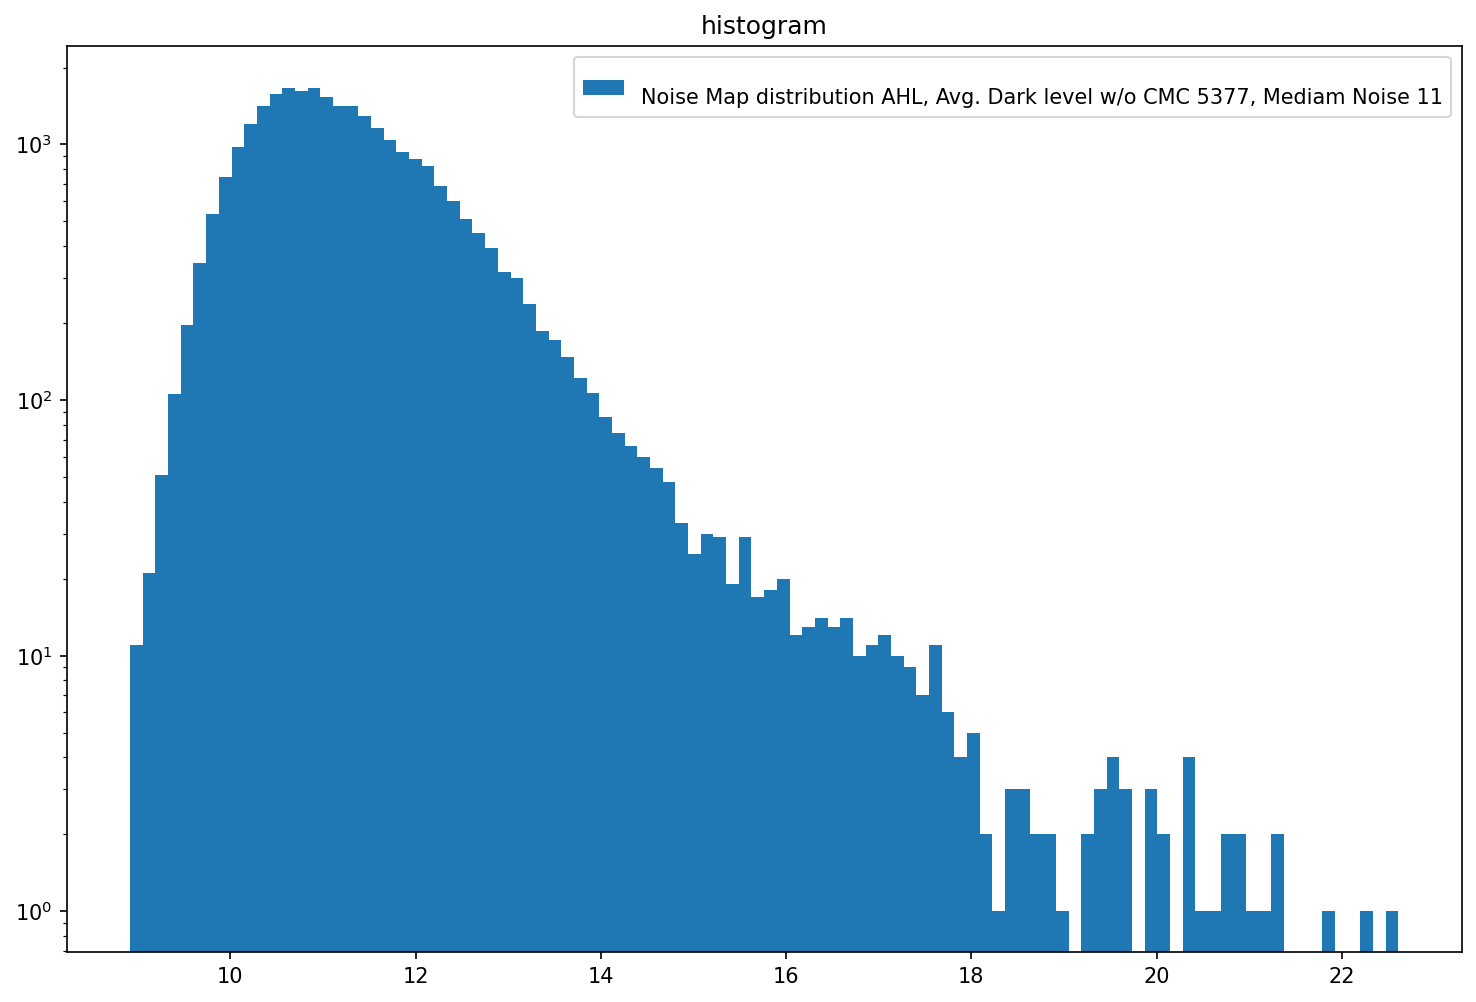


Preamp 2
Vld1_b 2
Pixel_CB 2
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_2_PixelCB_2_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1067119
Number of frames received: 10009
Number of frames received: 12011
Number of frames received: 14013
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


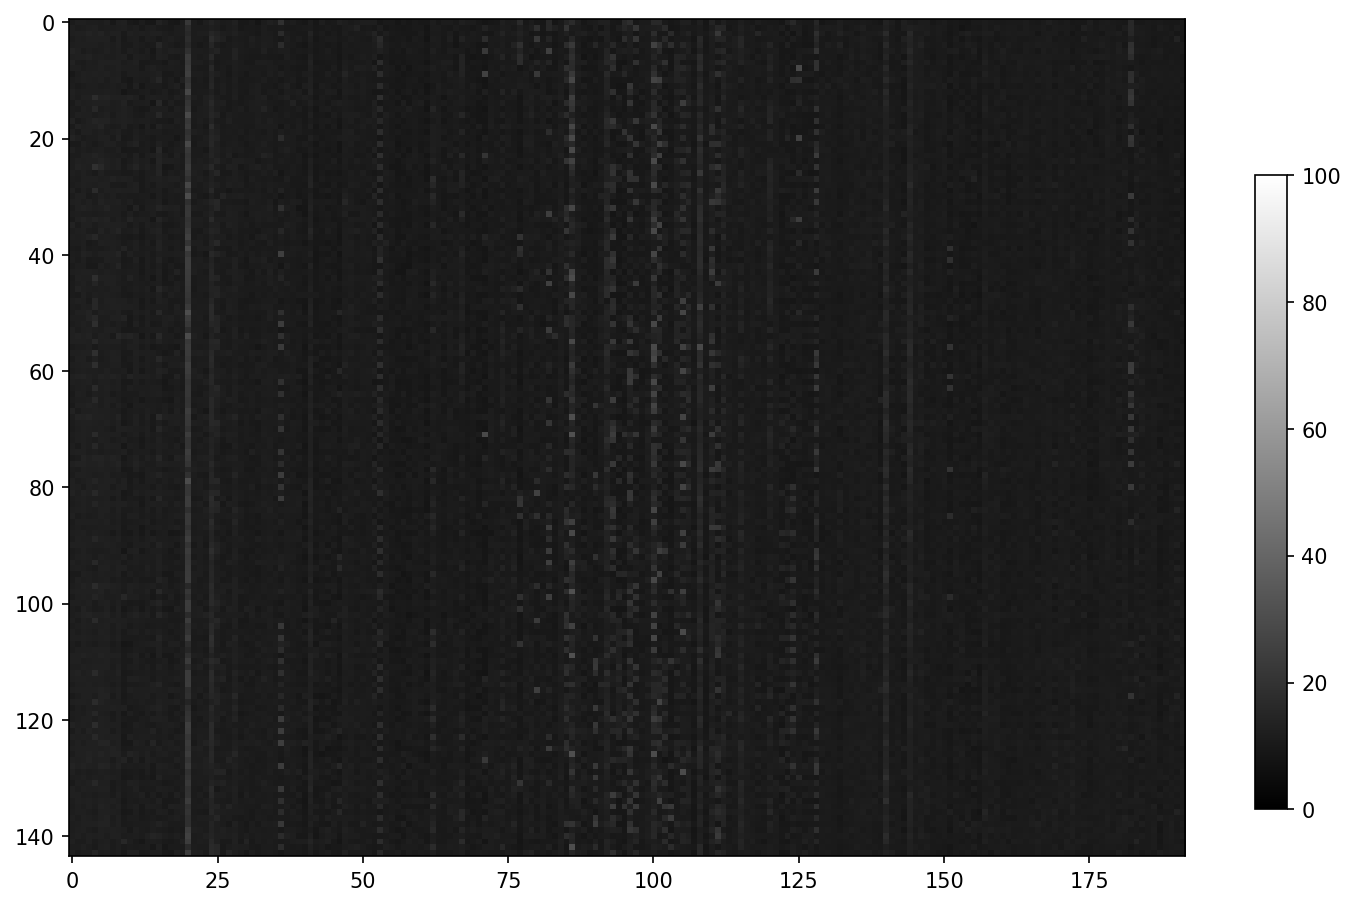

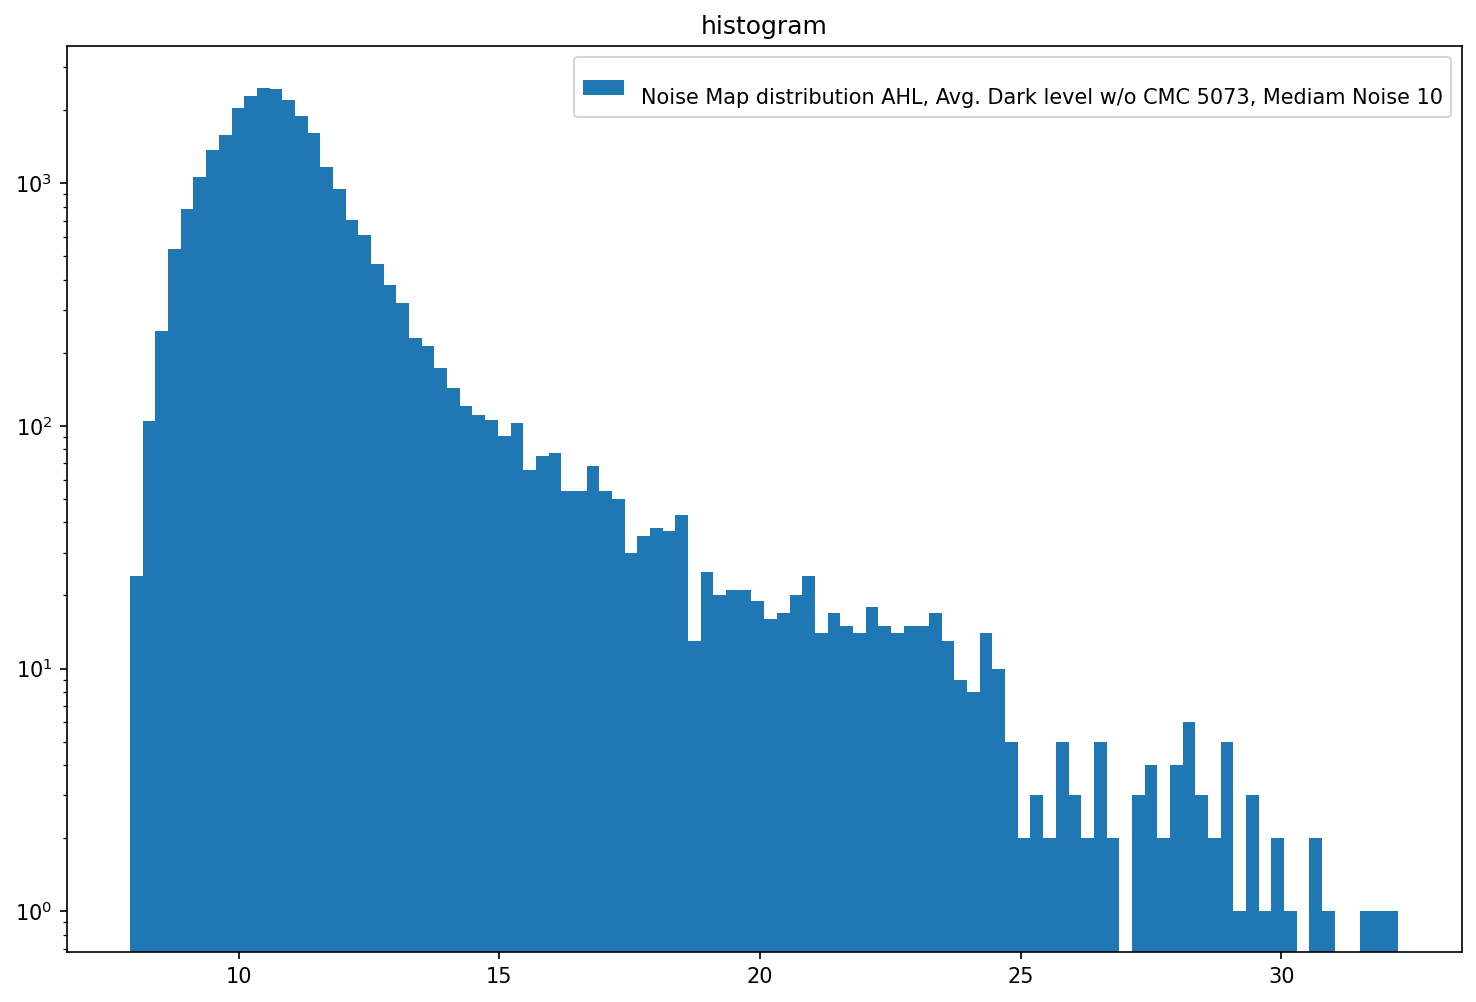


Preamp 2
Vld1_b 3
Pixel_CB 2
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_3_PixelCB_2_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1081132
Number of frames received: 10009
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


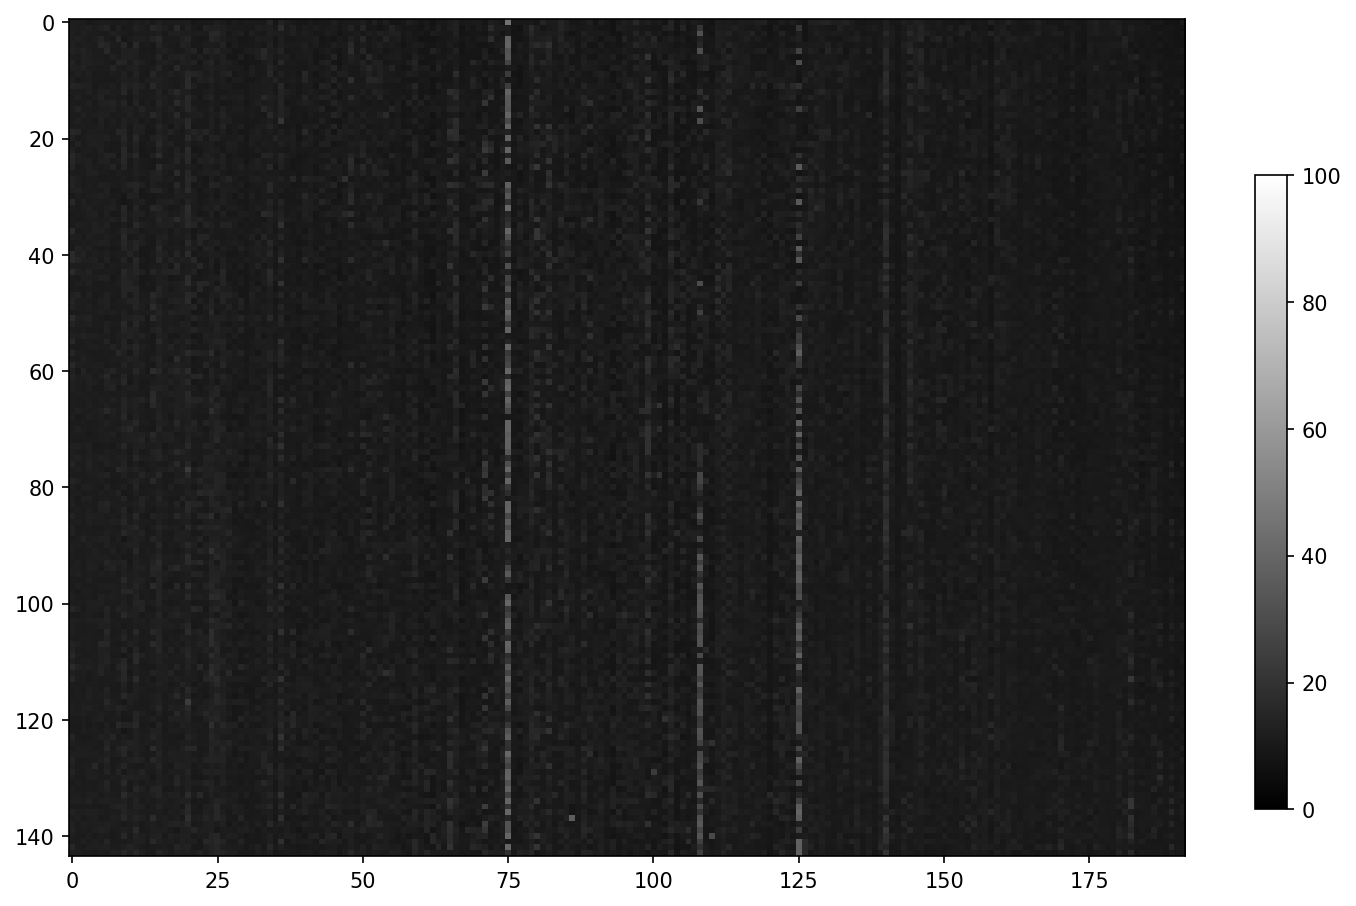

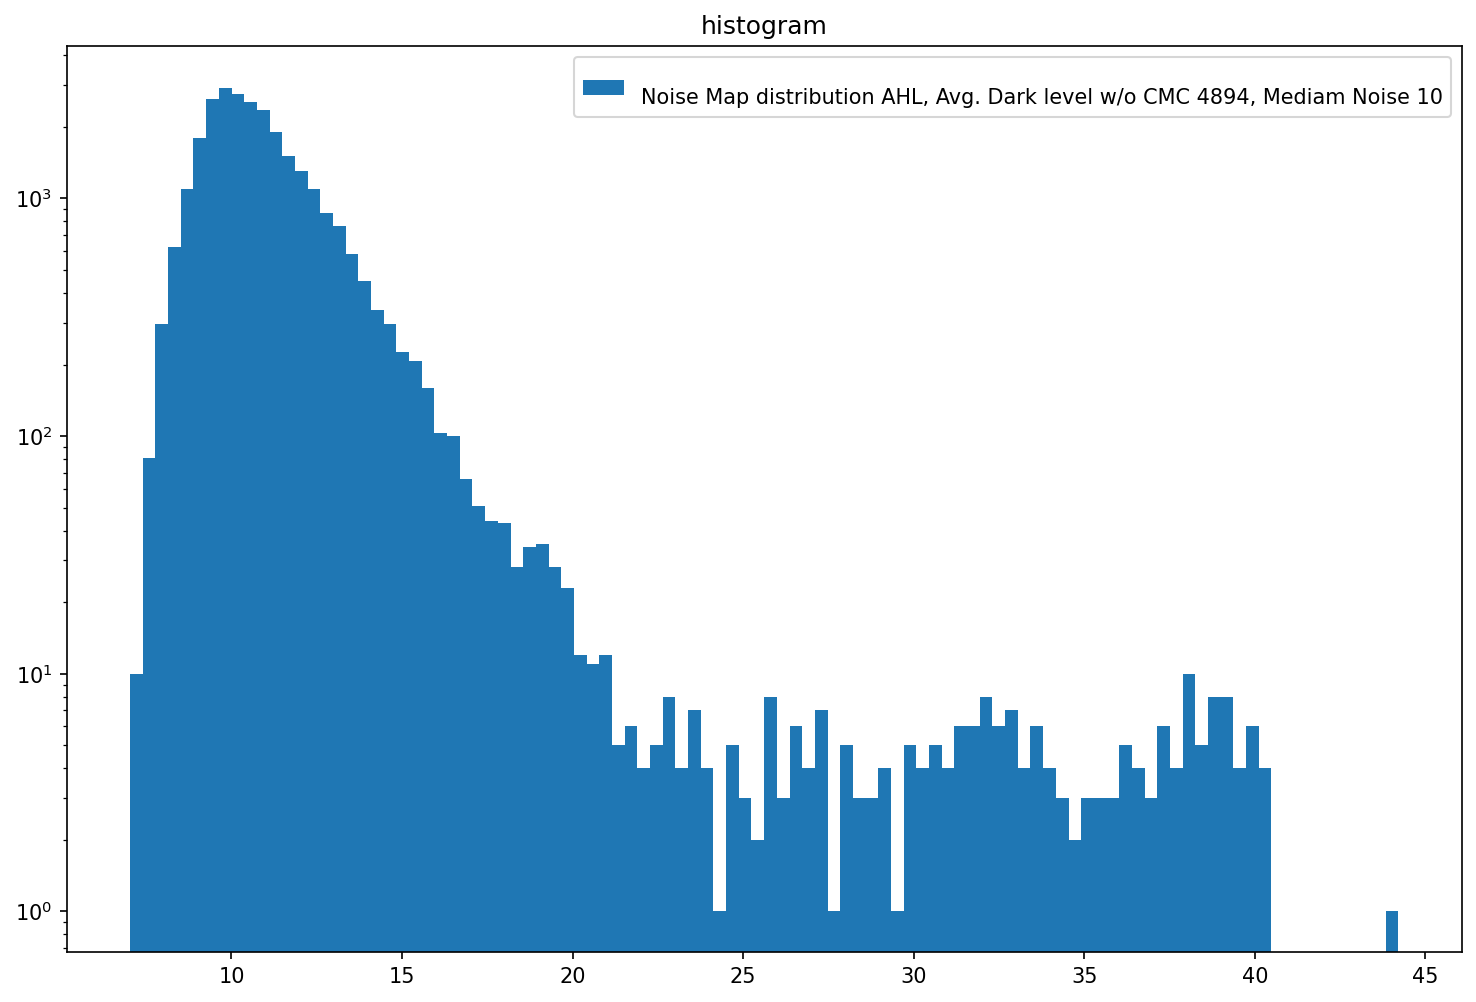

In [14]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

Preamp = 2
Vld1_bList = [0, 1, 2, 3]
Pixel_CB= 2
Filter_DAC= 17
VRef_DAC = 58

for Vld1_b in Vld1_bList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

Preamp 2
Vld1_b 0
Pixel_CB 7
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_7_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1095345
Number of frames received: 10008
Number of frames received: 12009
Number of frames received: 14012
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


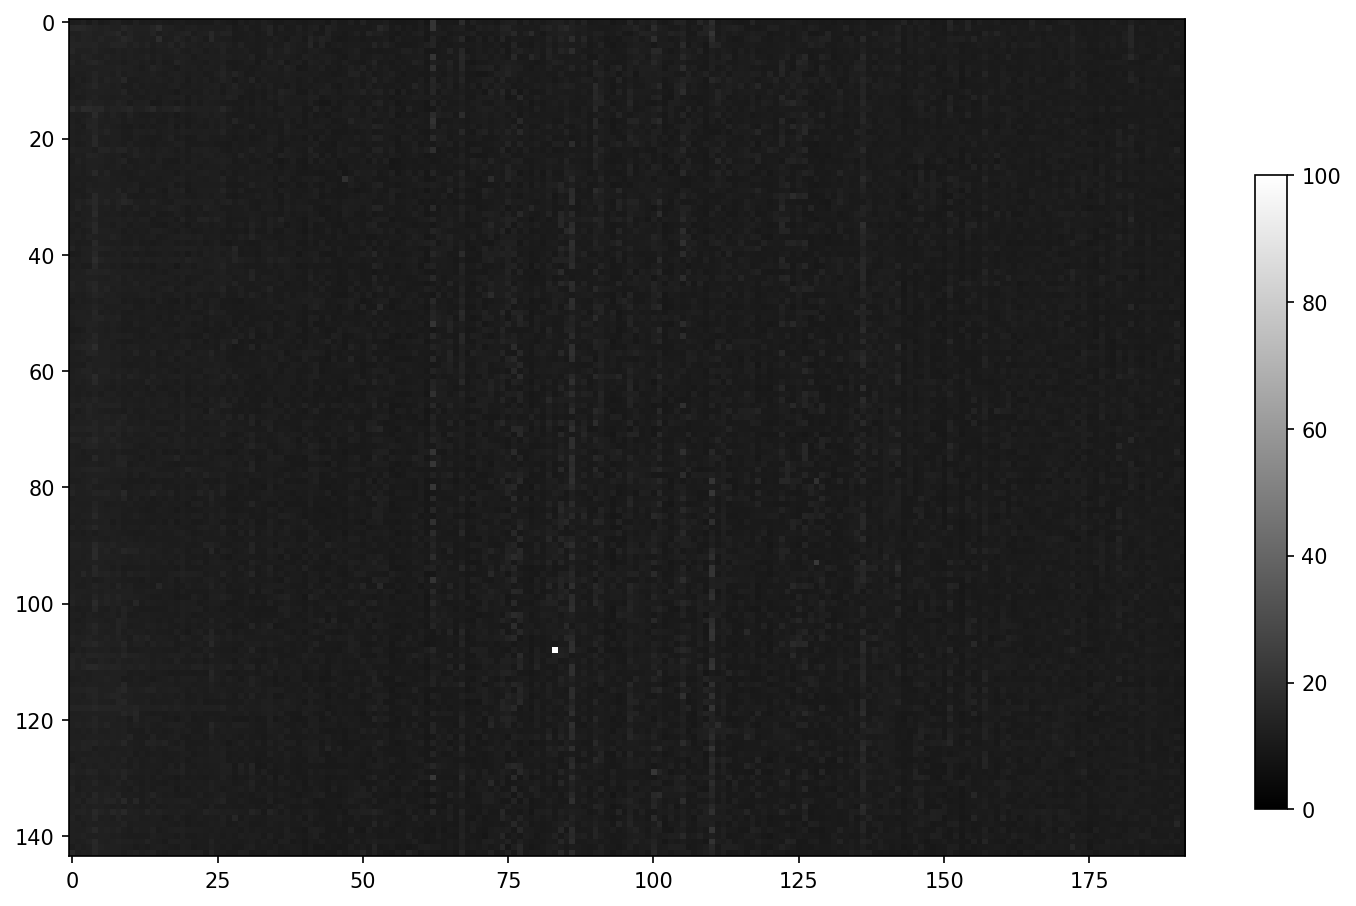

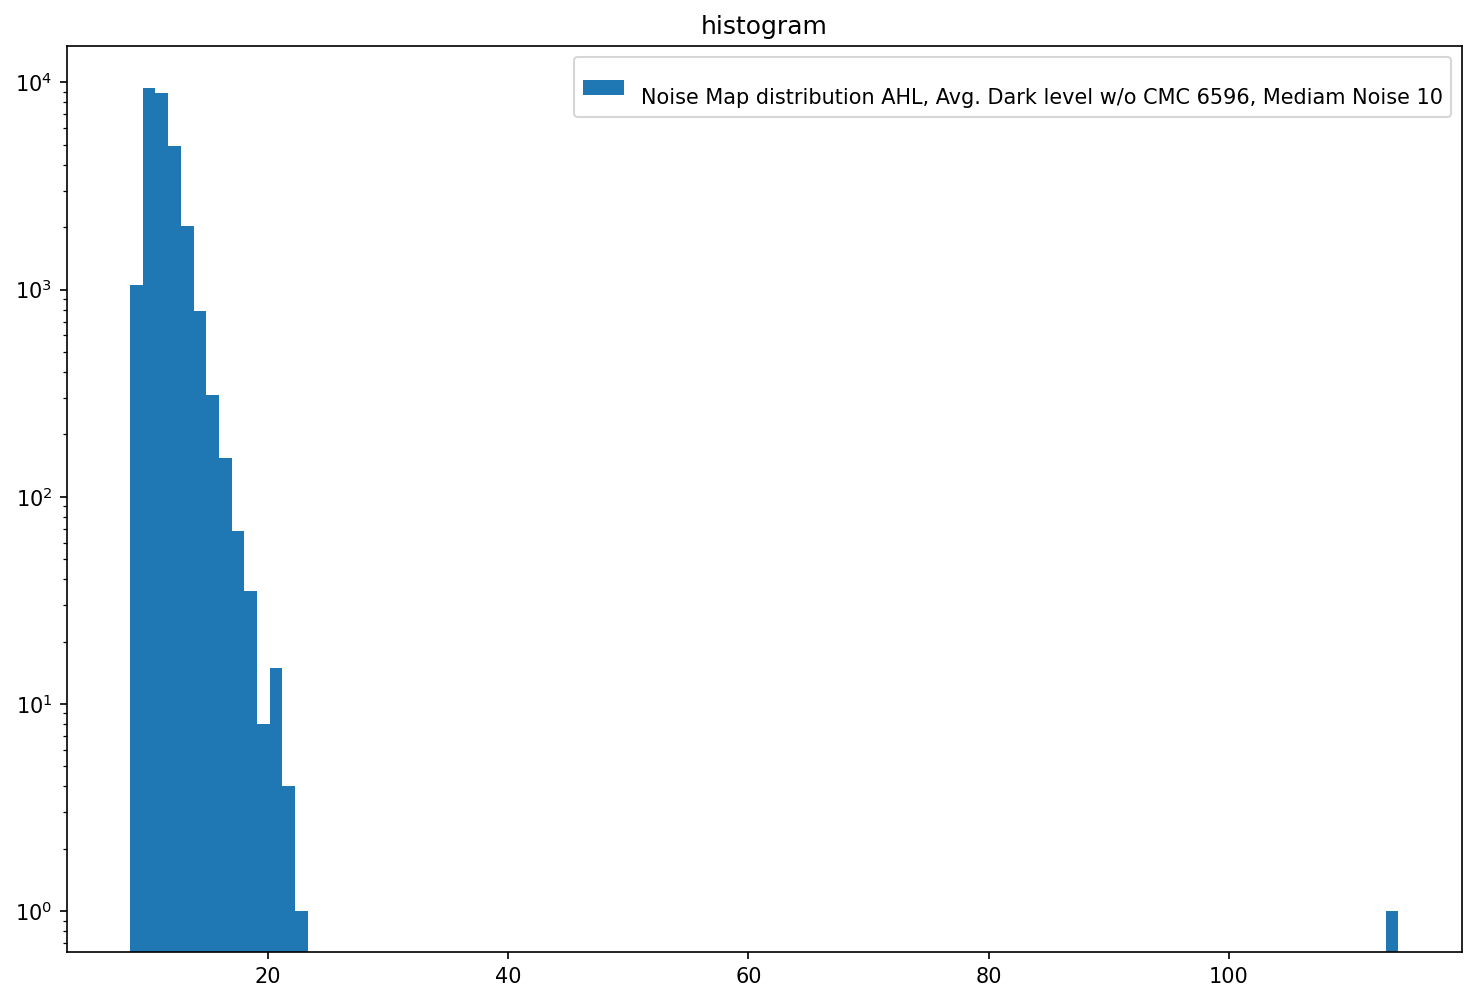


Preamp 2
Vld1_b 0
Pixel_CB 6
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_6_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1109357
Number of frames received: 10002
Number of frames received: 12005
Number of frames received: 14006
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


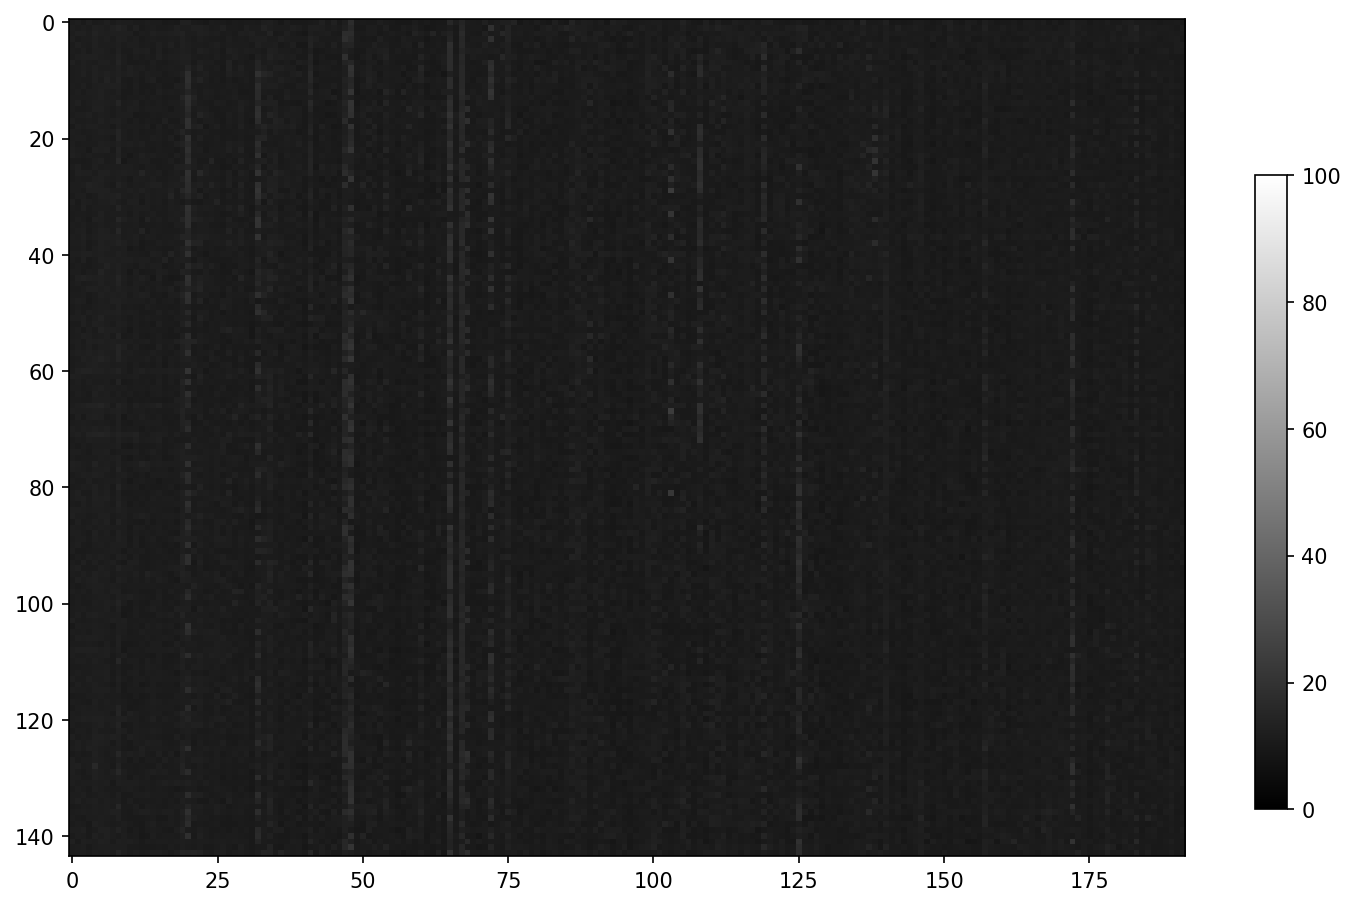

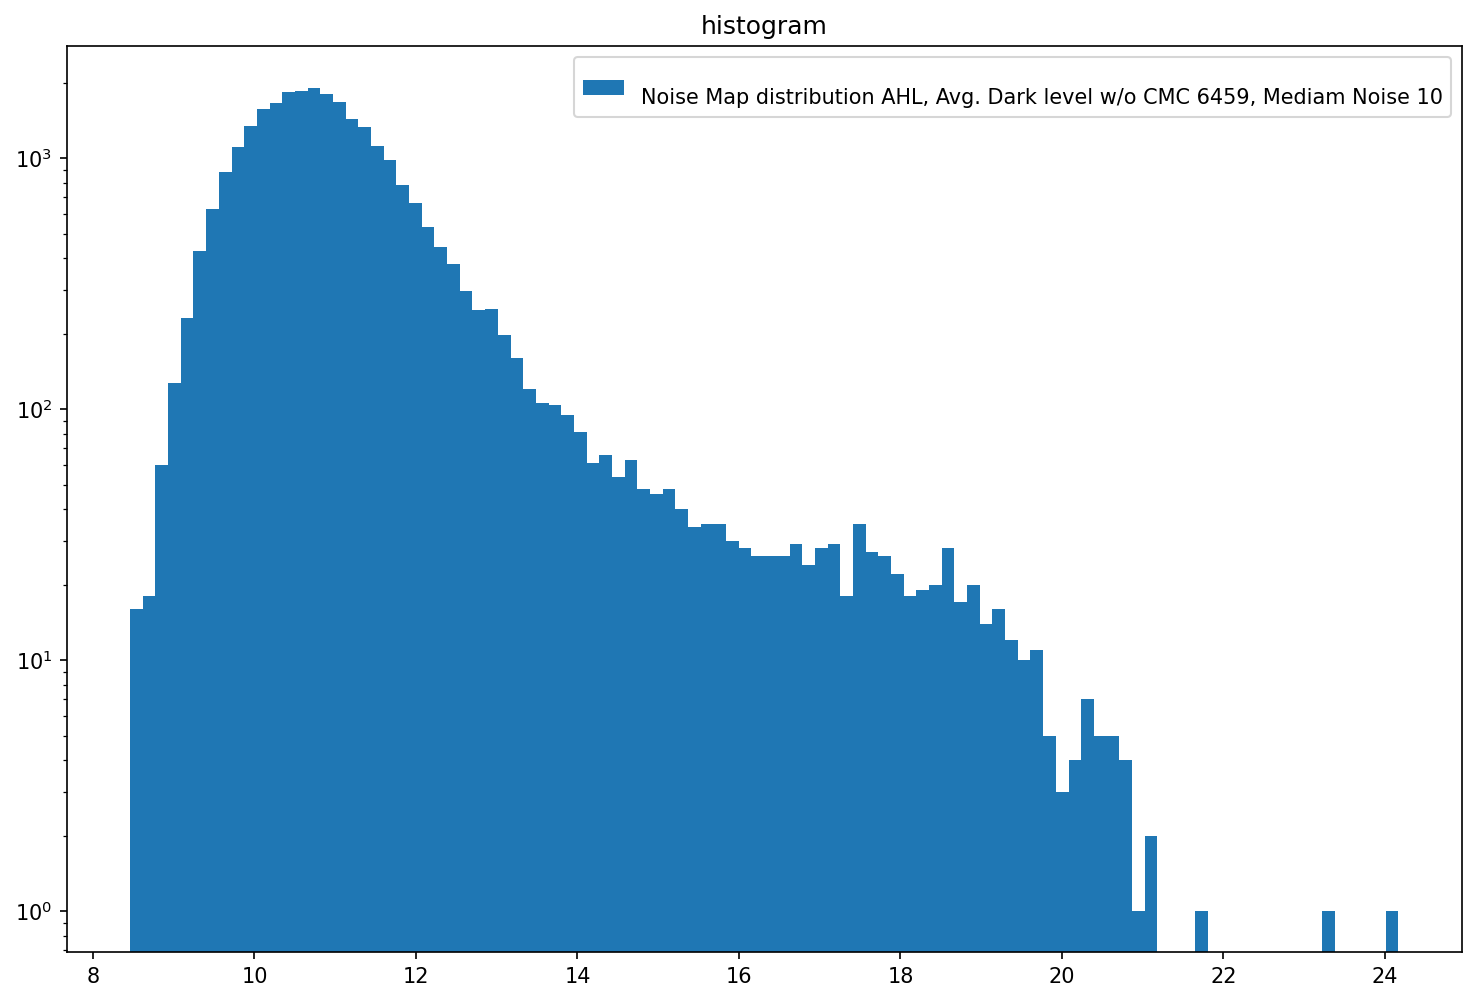


Preamp 2
Vld1_b 0
Pixel_CB 5
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_5_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1123363
Number of frames received: 10009
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


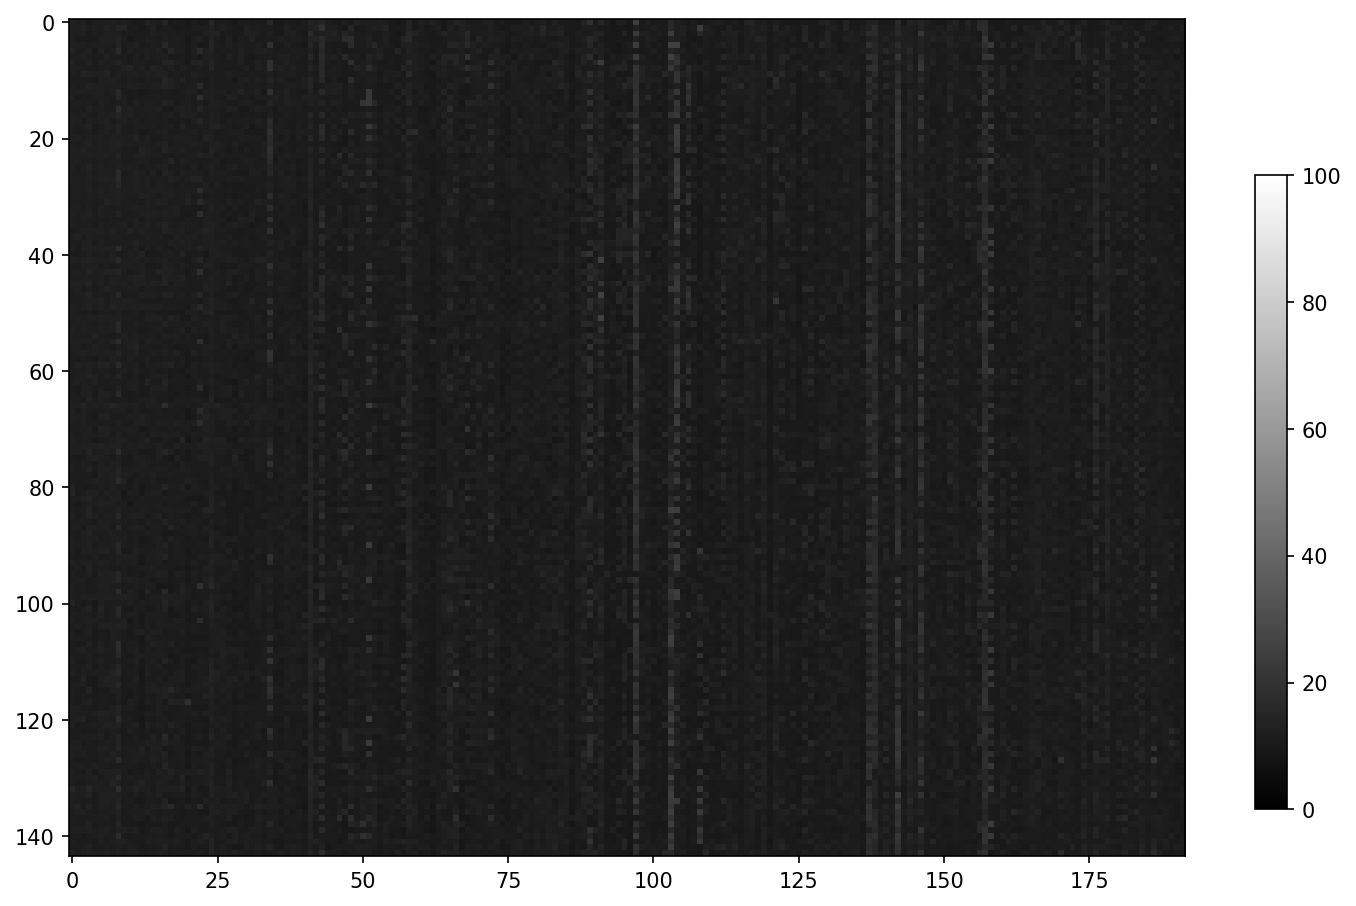

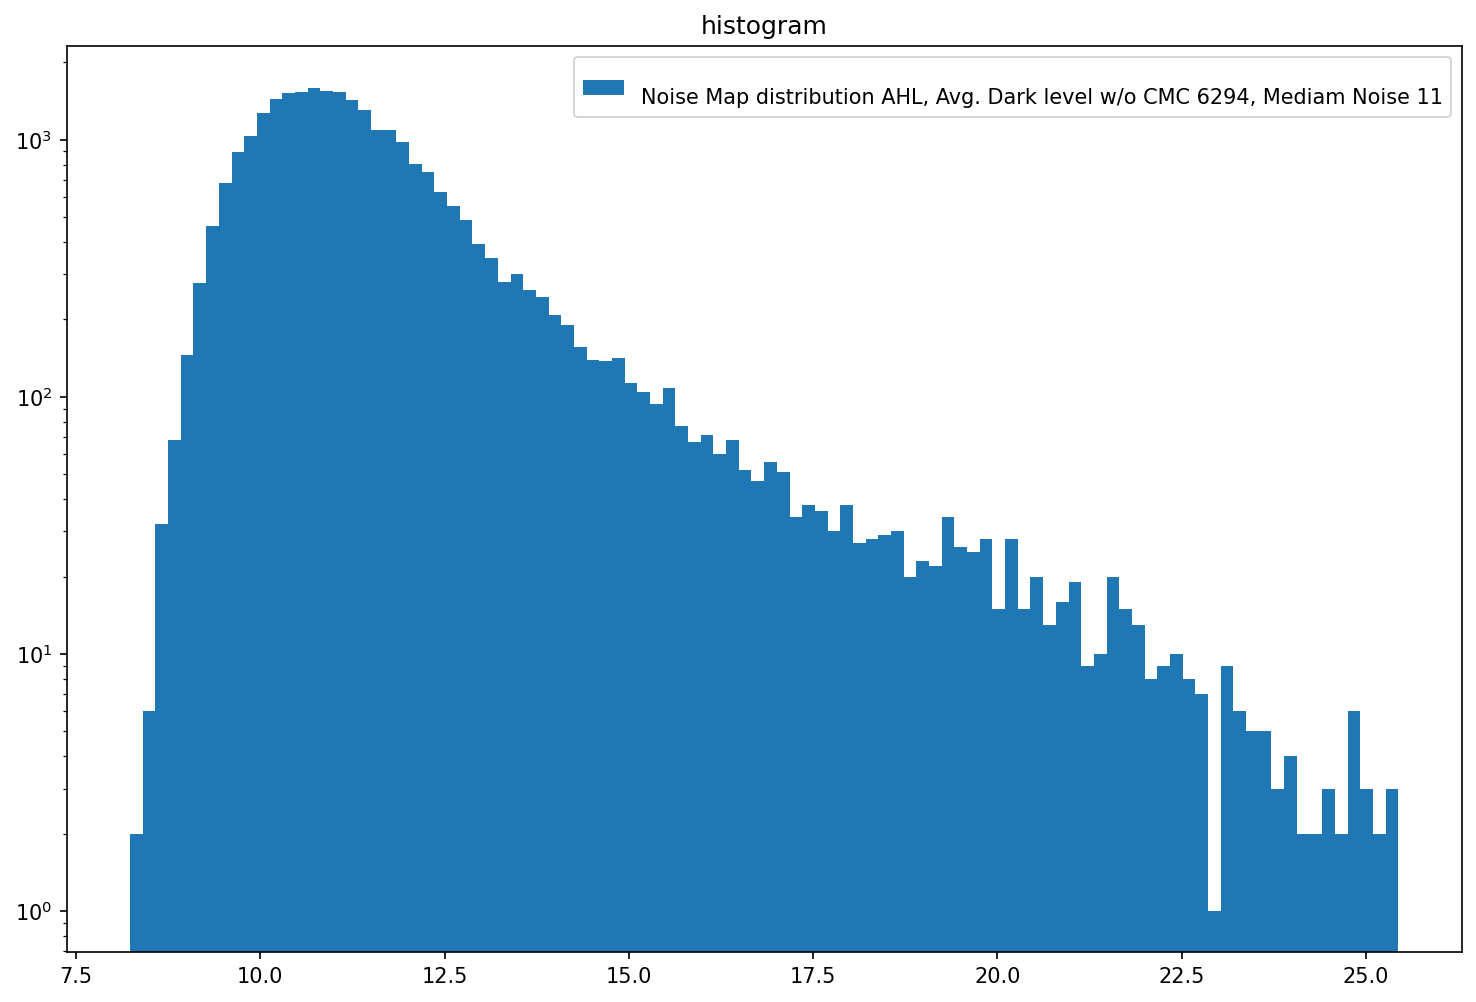


Preamp 2
Vld1_b 0
Pixel_CB 4
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_4_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1137377
Number of frames received: 10008
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


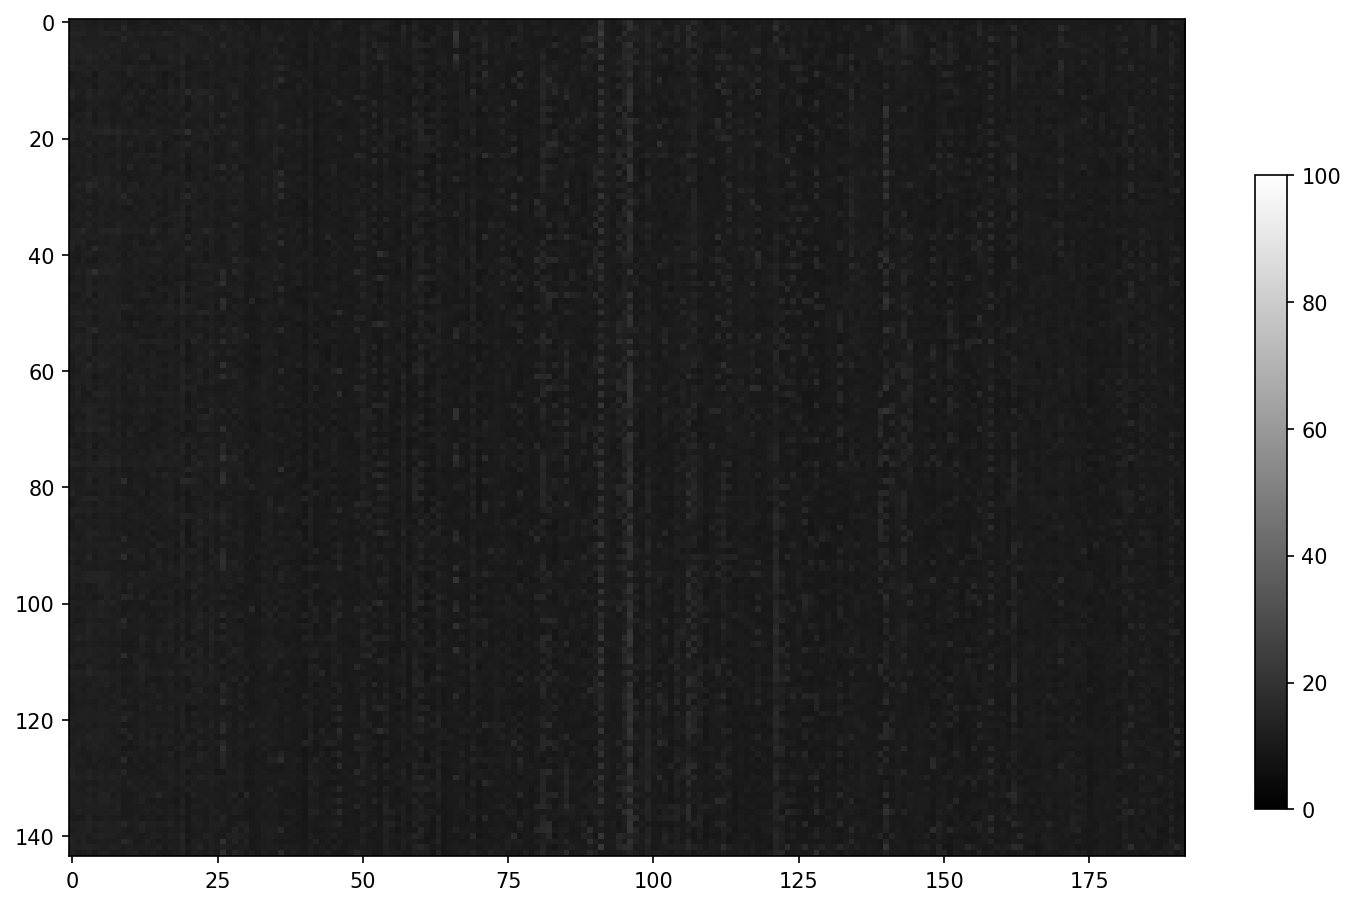

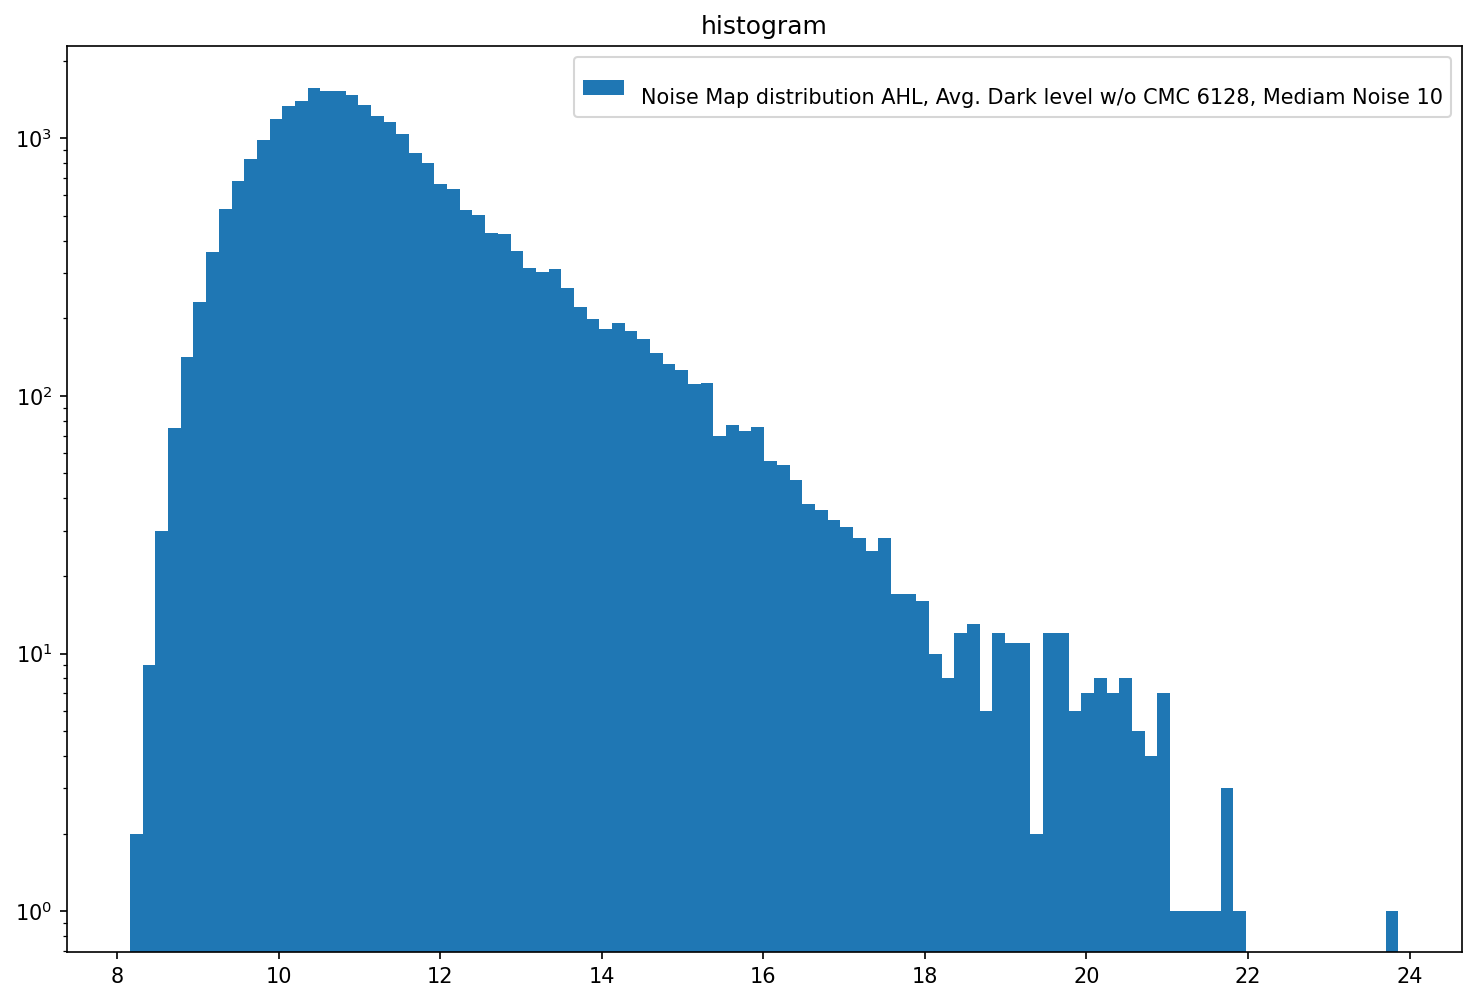


Preamp 2
Vld1_b 0
Pixel_CB 3
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_3_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1151391
Number of frames received: 10008
Number of frames received: 12011
Number of frames received: 14012
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


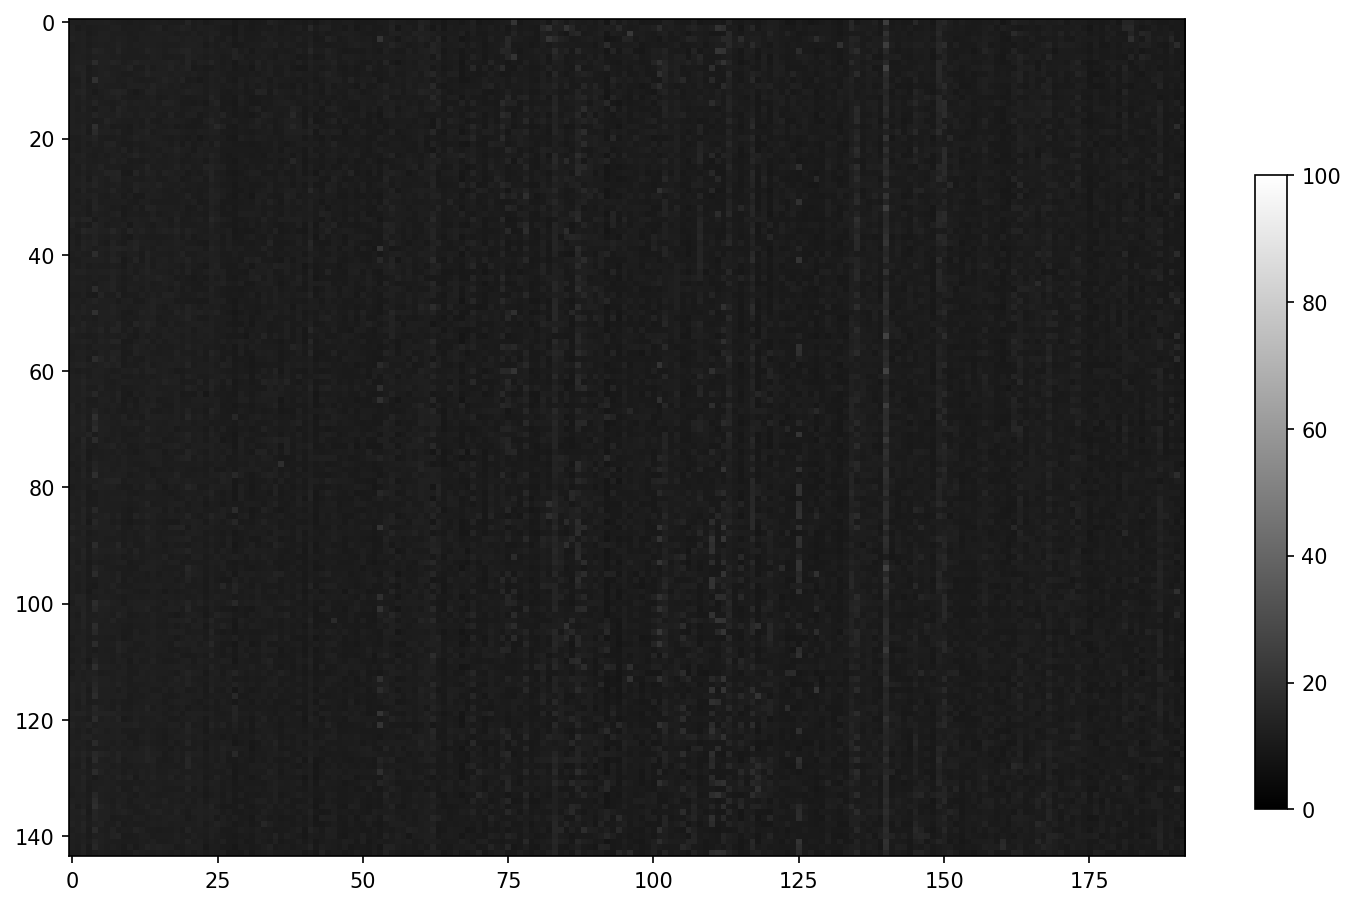

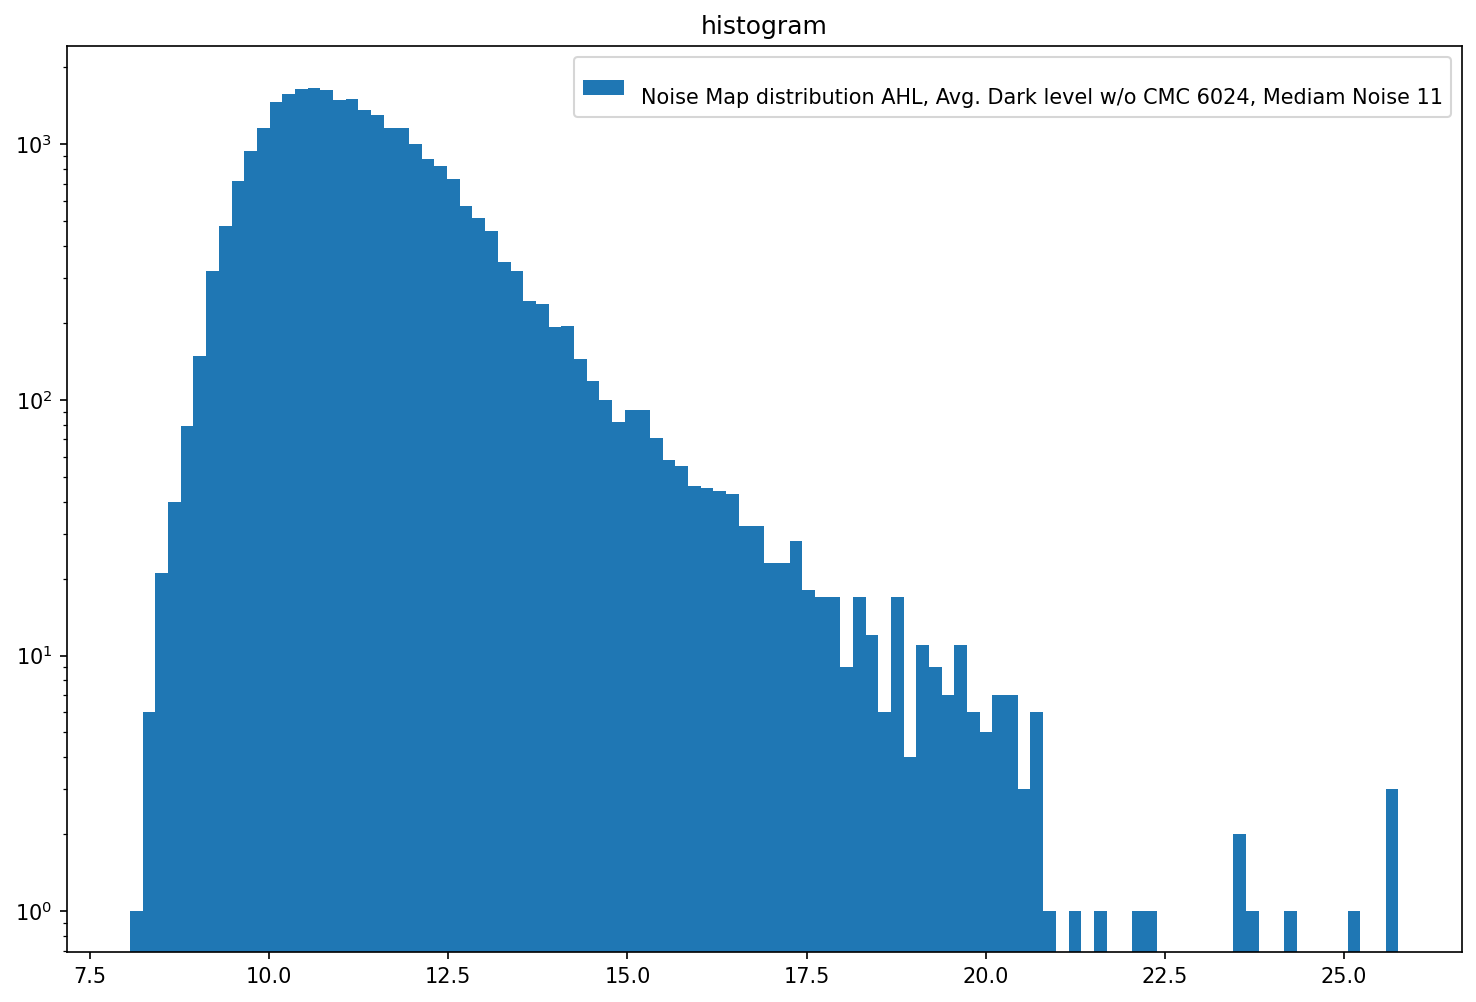


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1165403
Number of frames received: 10009
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)



Preamp 2
Vld1_b 0
Pixel_CB 1
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_1_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1179417
Number of frames received: 10009
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


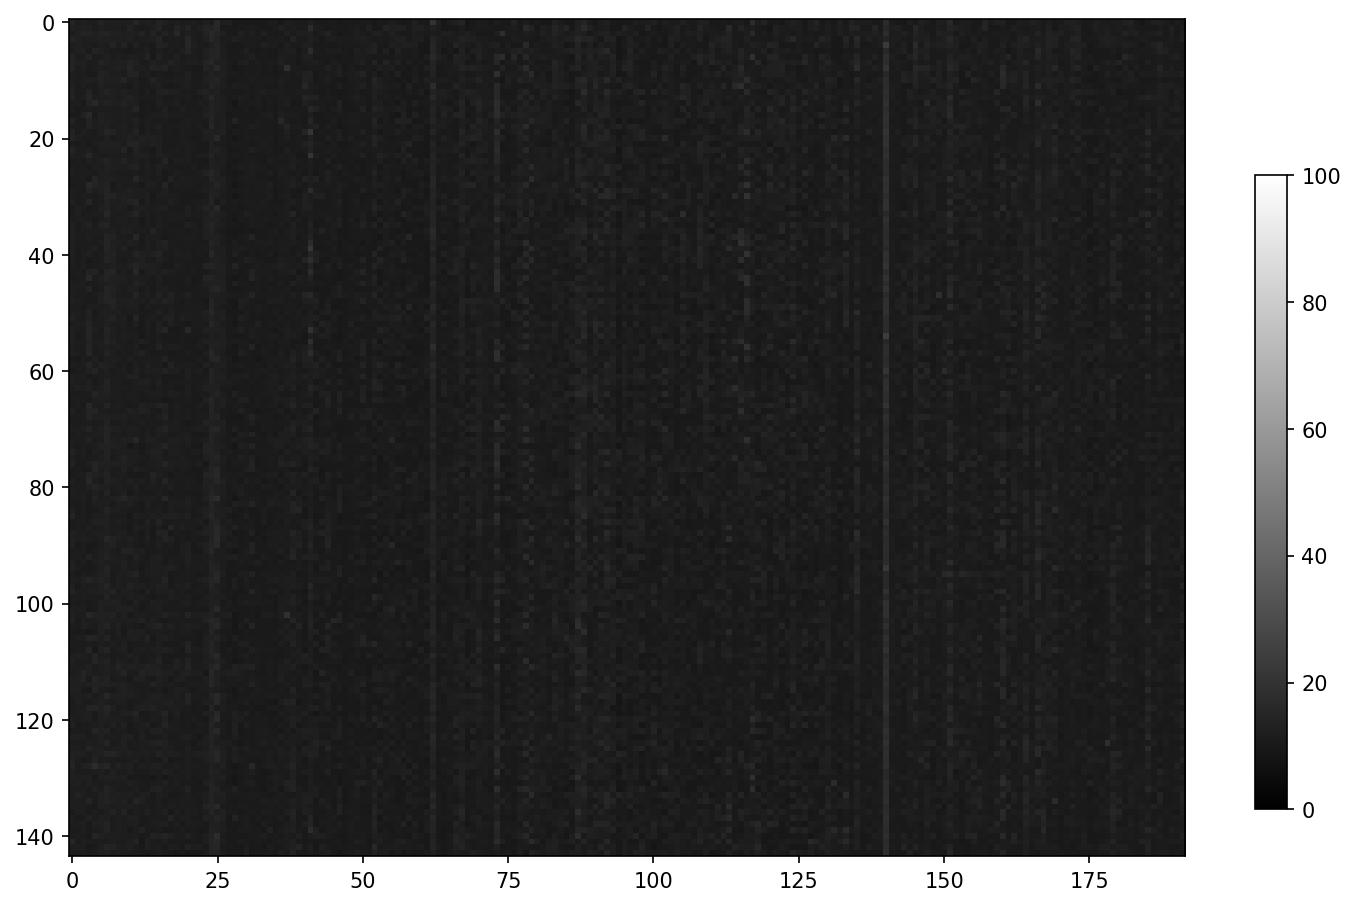


Preamp 2
Vld1_b 0
Pixel_CB 0
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_0_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1193431
Number of frames received: 10008
Number of frames received: 12010
Number of frames received: 14013
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


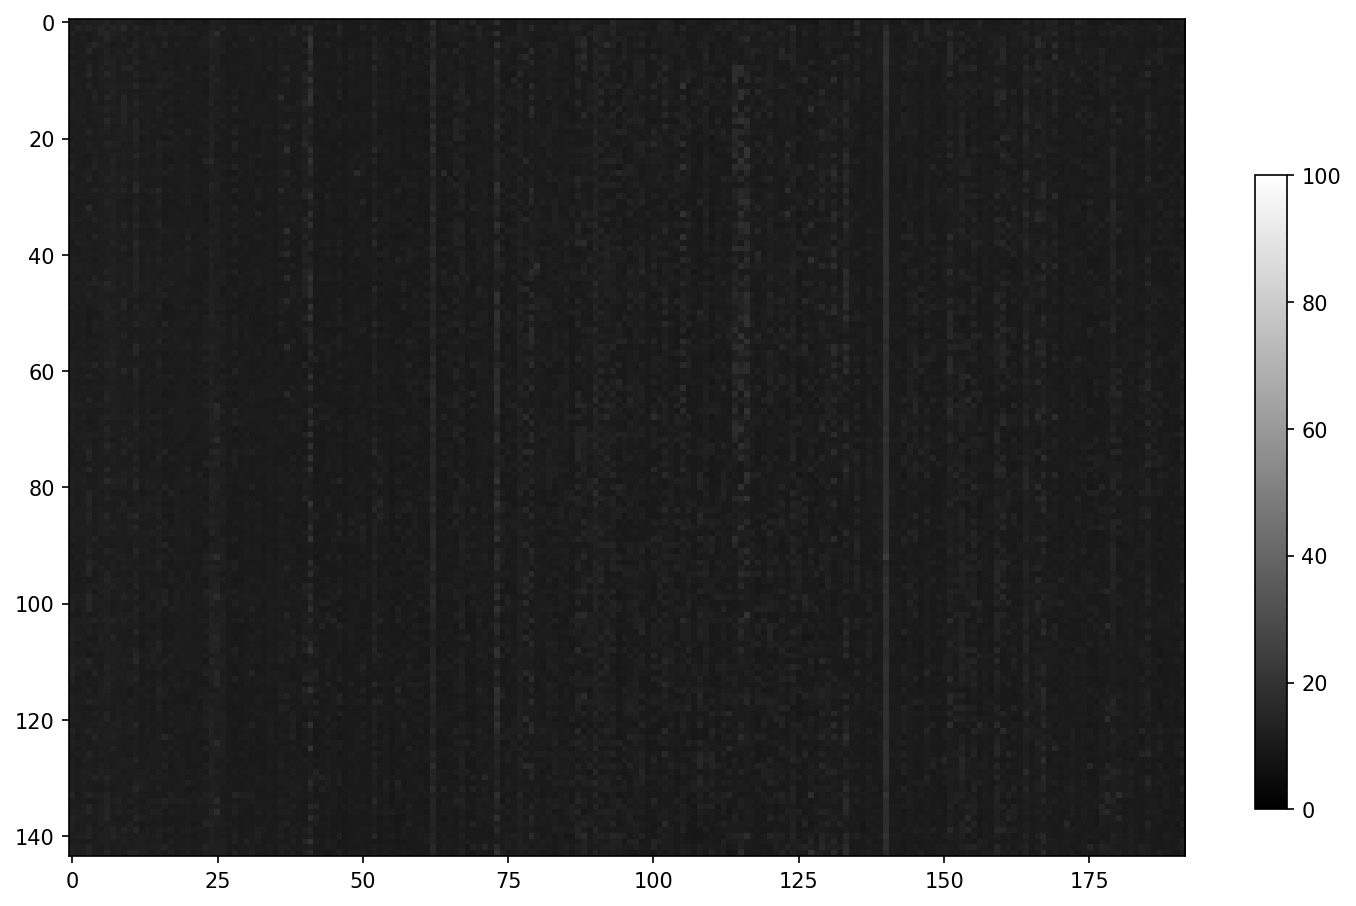

In [15]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

Preamp = 2
Vld1_b = 0
Pixel_CBList= [7,6,5,4,3,2,1,0]
Filter_DAC= 17
VRef_DAC = 58

for Pixel_CB in Pixel_CBList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 7
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_7_VRrefdac_58_run1.dat
Aquisition Counter 1207643
Number of frames received: 10009
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


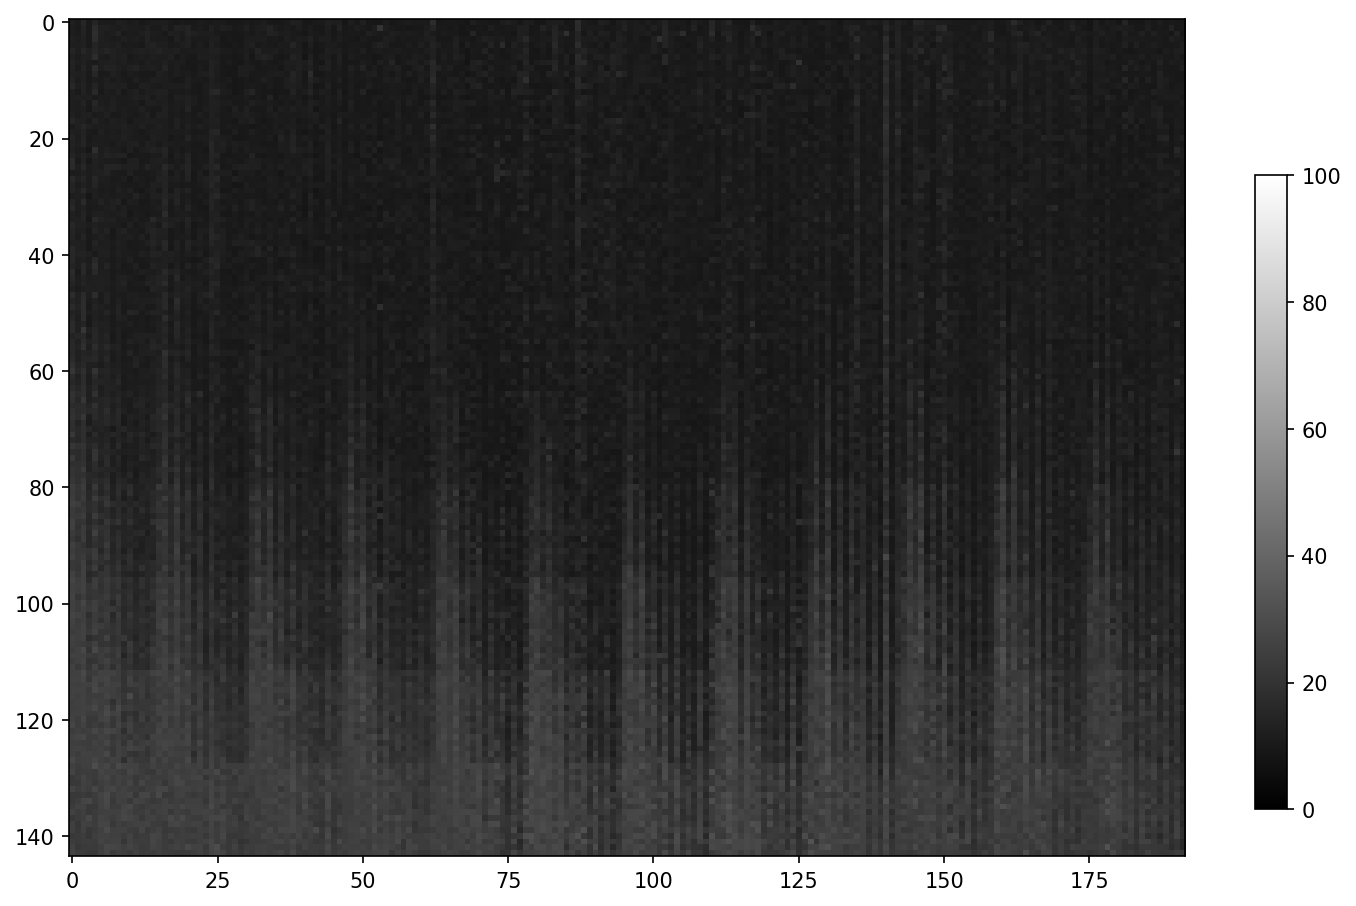

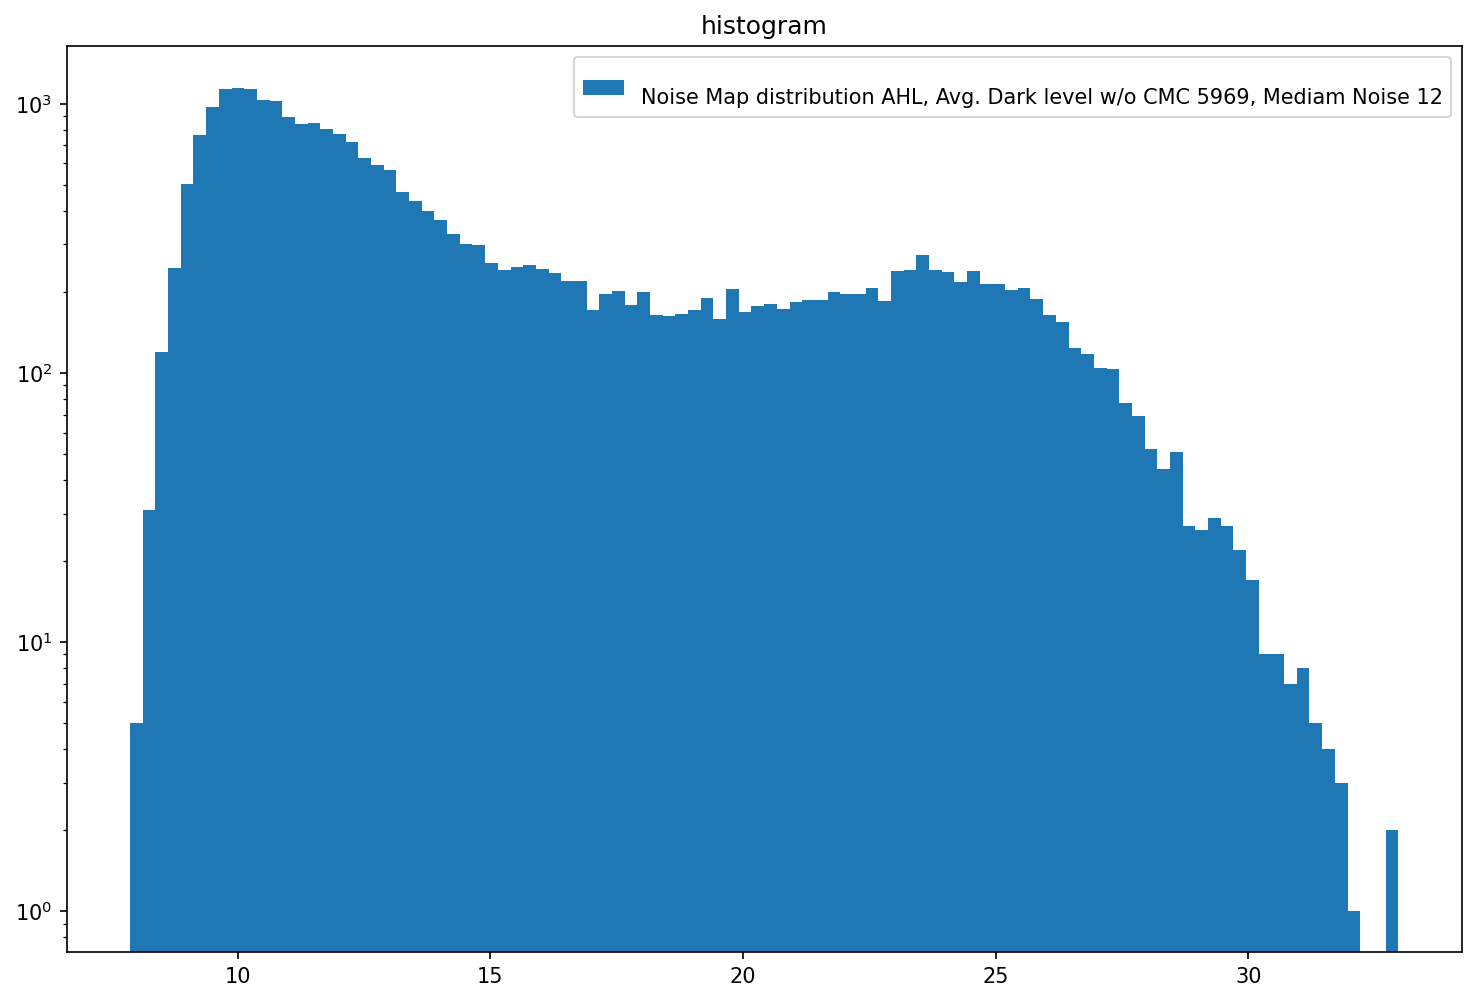


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 13
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_13_VRrefdac_58_run1.dat
Aquisition Counter 1221657
Number of frames received: 10009
Number of frames received: 12011
Number of frames received: 14013
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


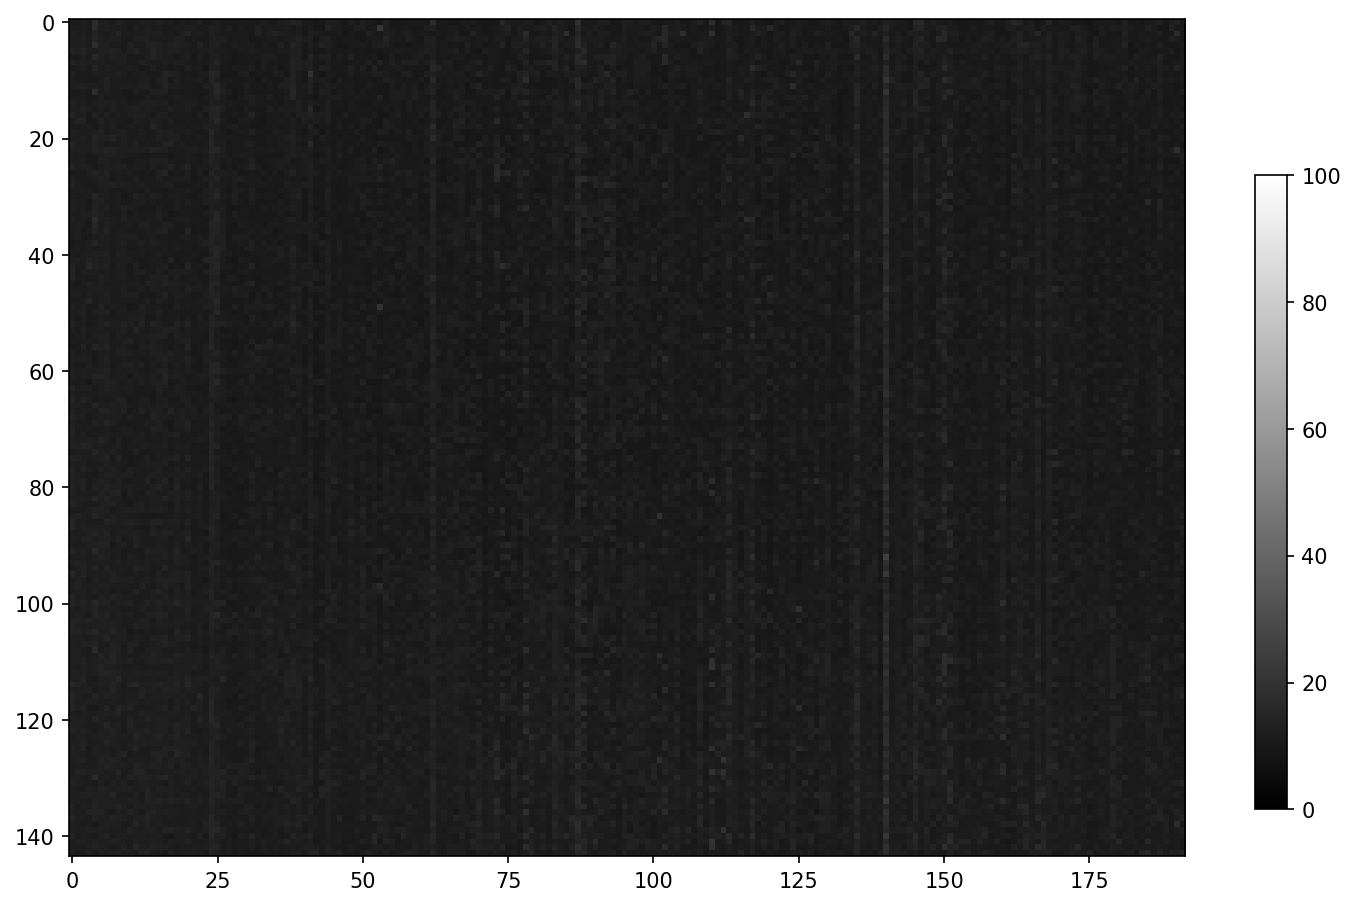

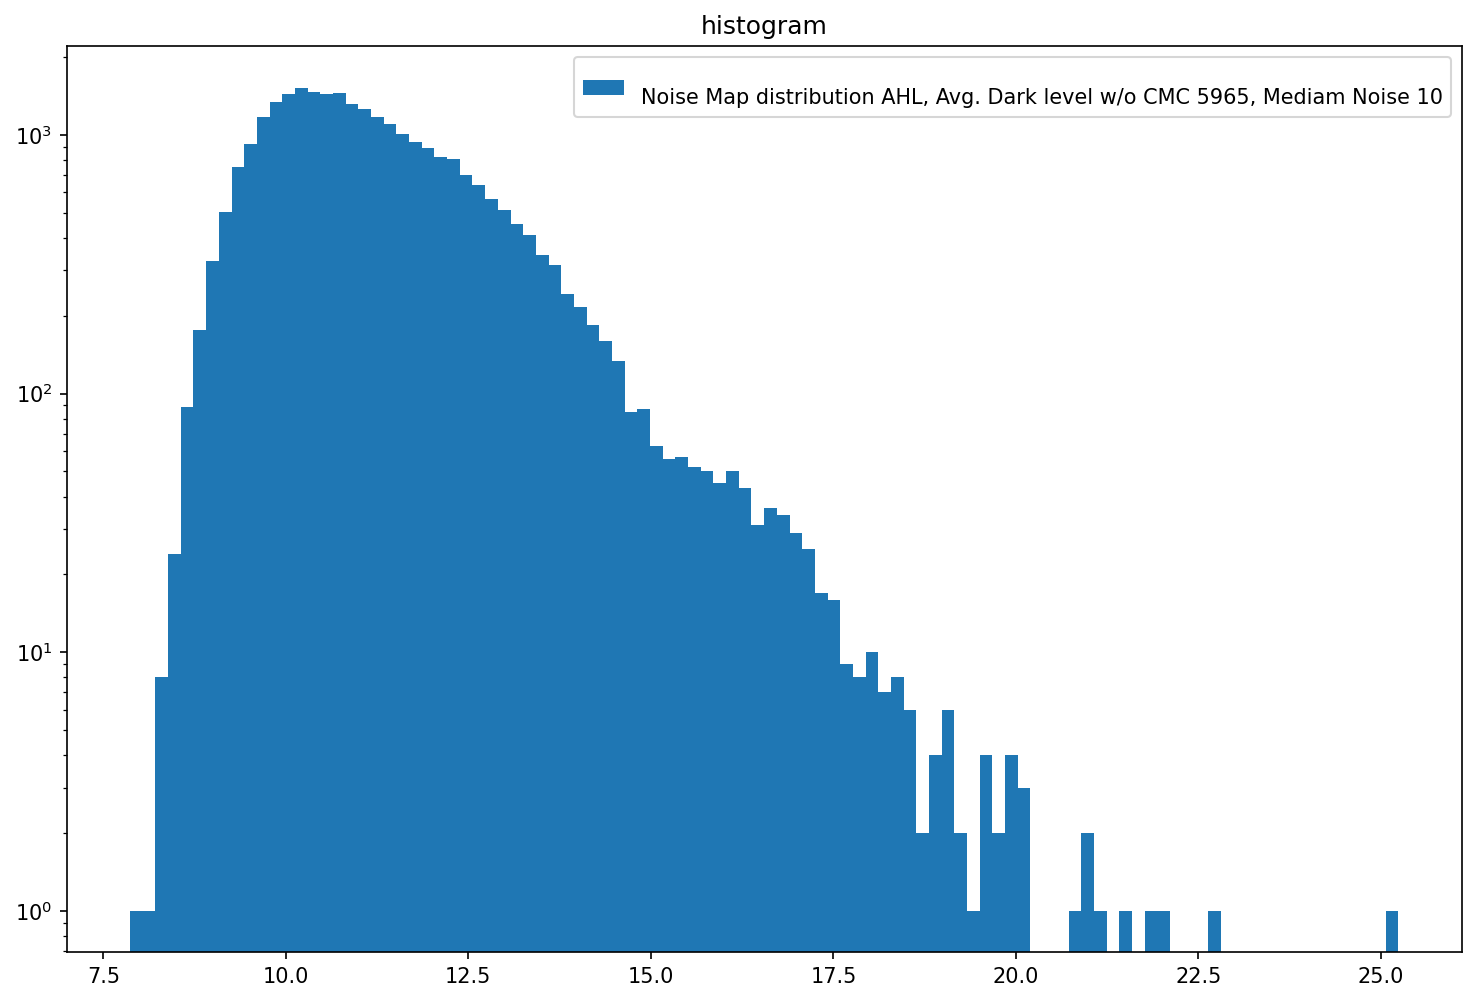


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 15
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_15_VRrefdac_58_run1.dat
Aquisition Counter 1235670
Number of frames received: 10009
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


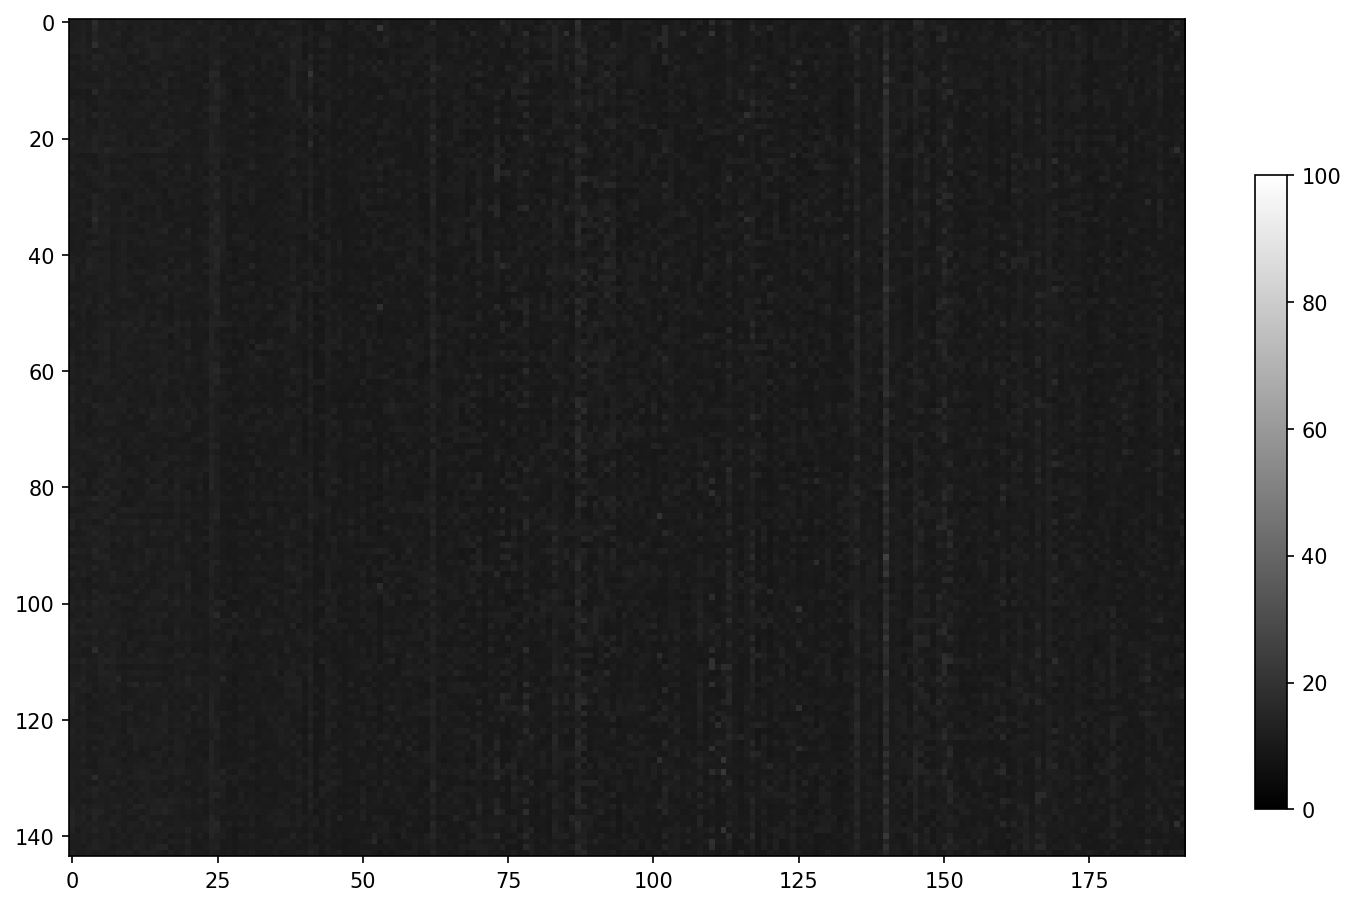


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1249684
Number of frames received: 10009
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


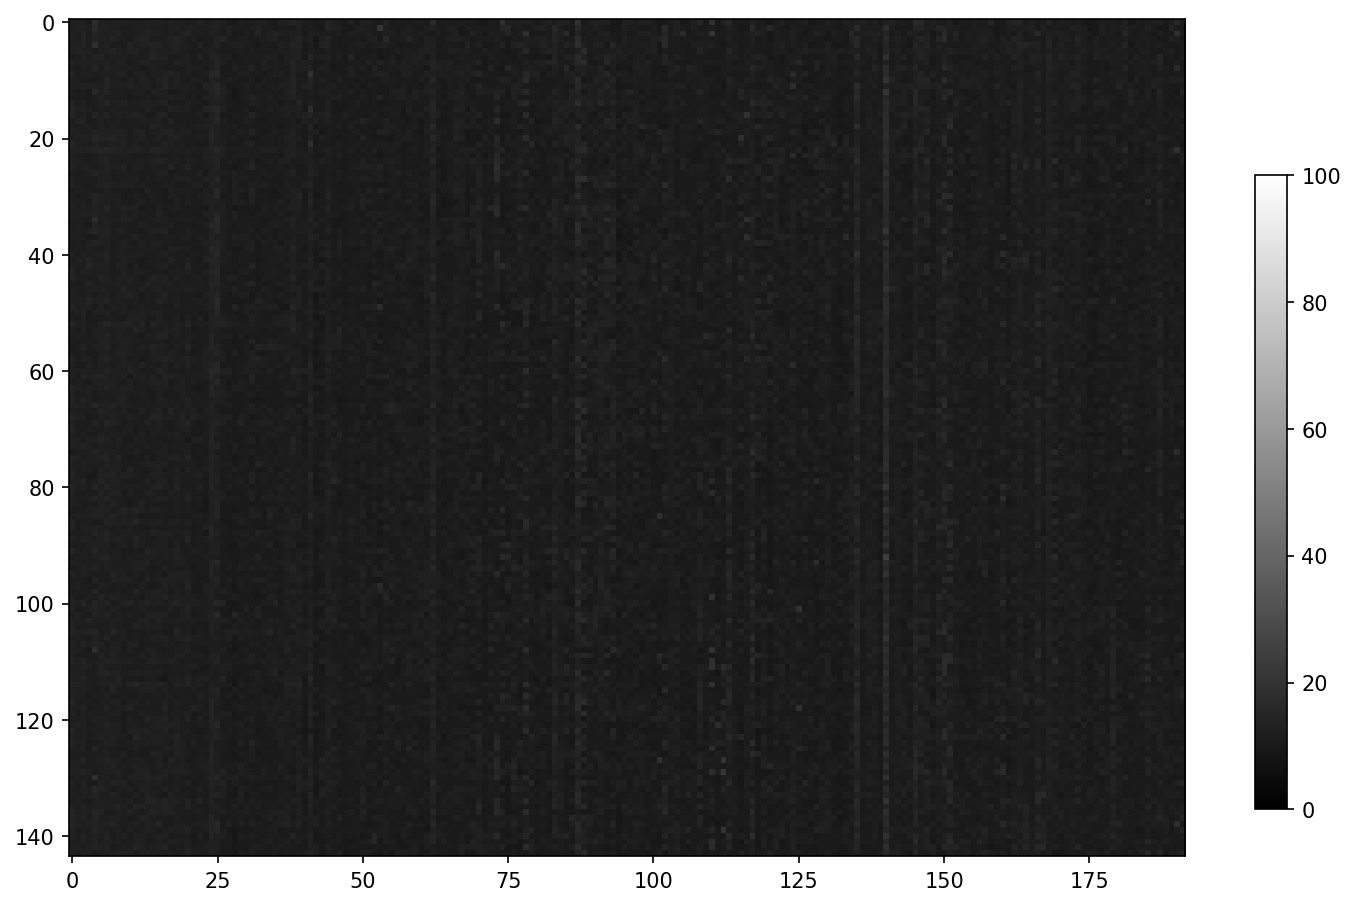


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 19
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_19_VRrefdac_58_run1.dat
Aquisition Counter 1263698
Number of frames received: 9944
Number of frames received: 11947
Number of frames received: 13949
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


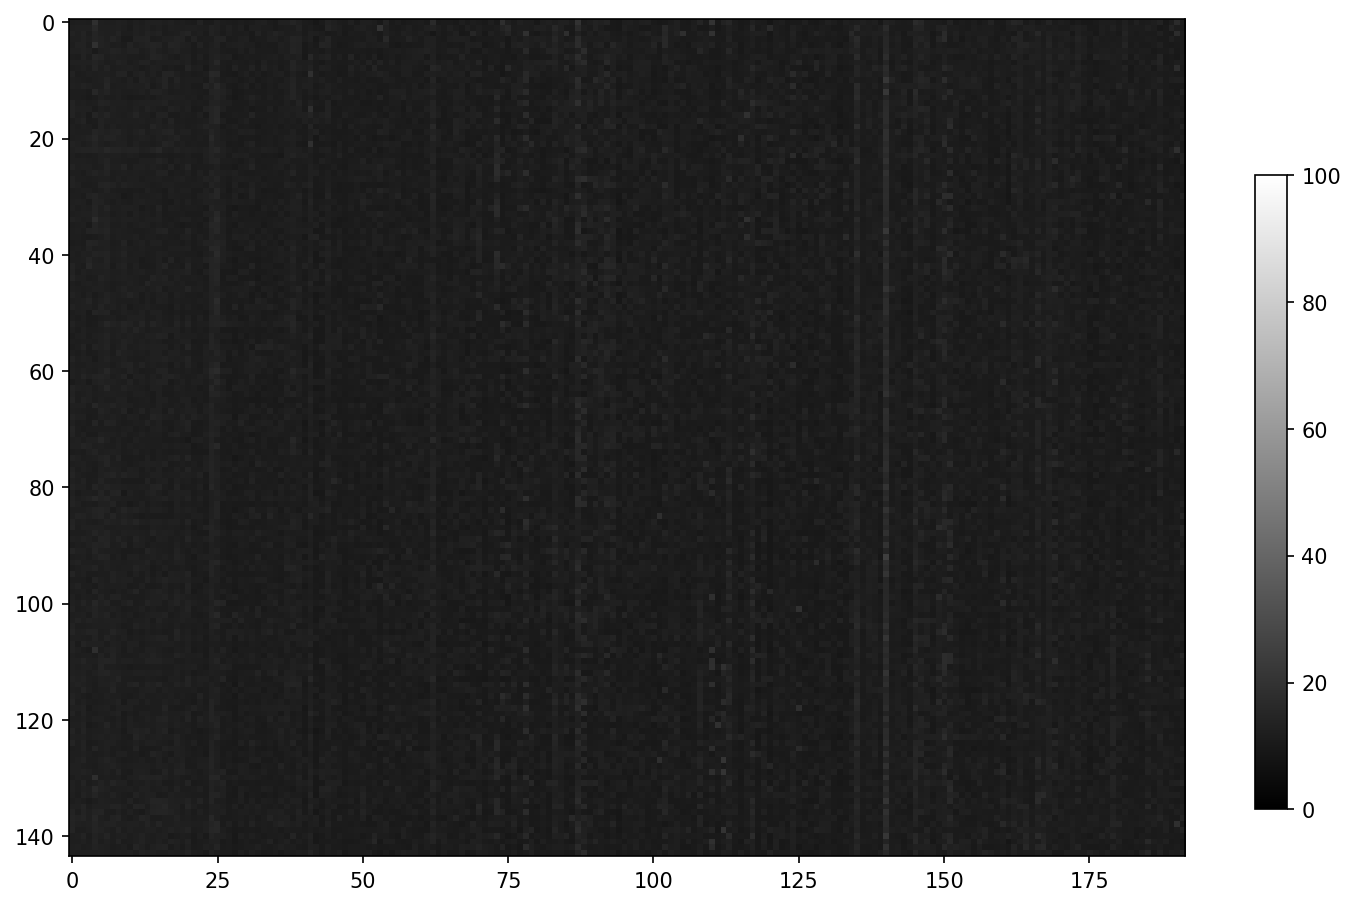

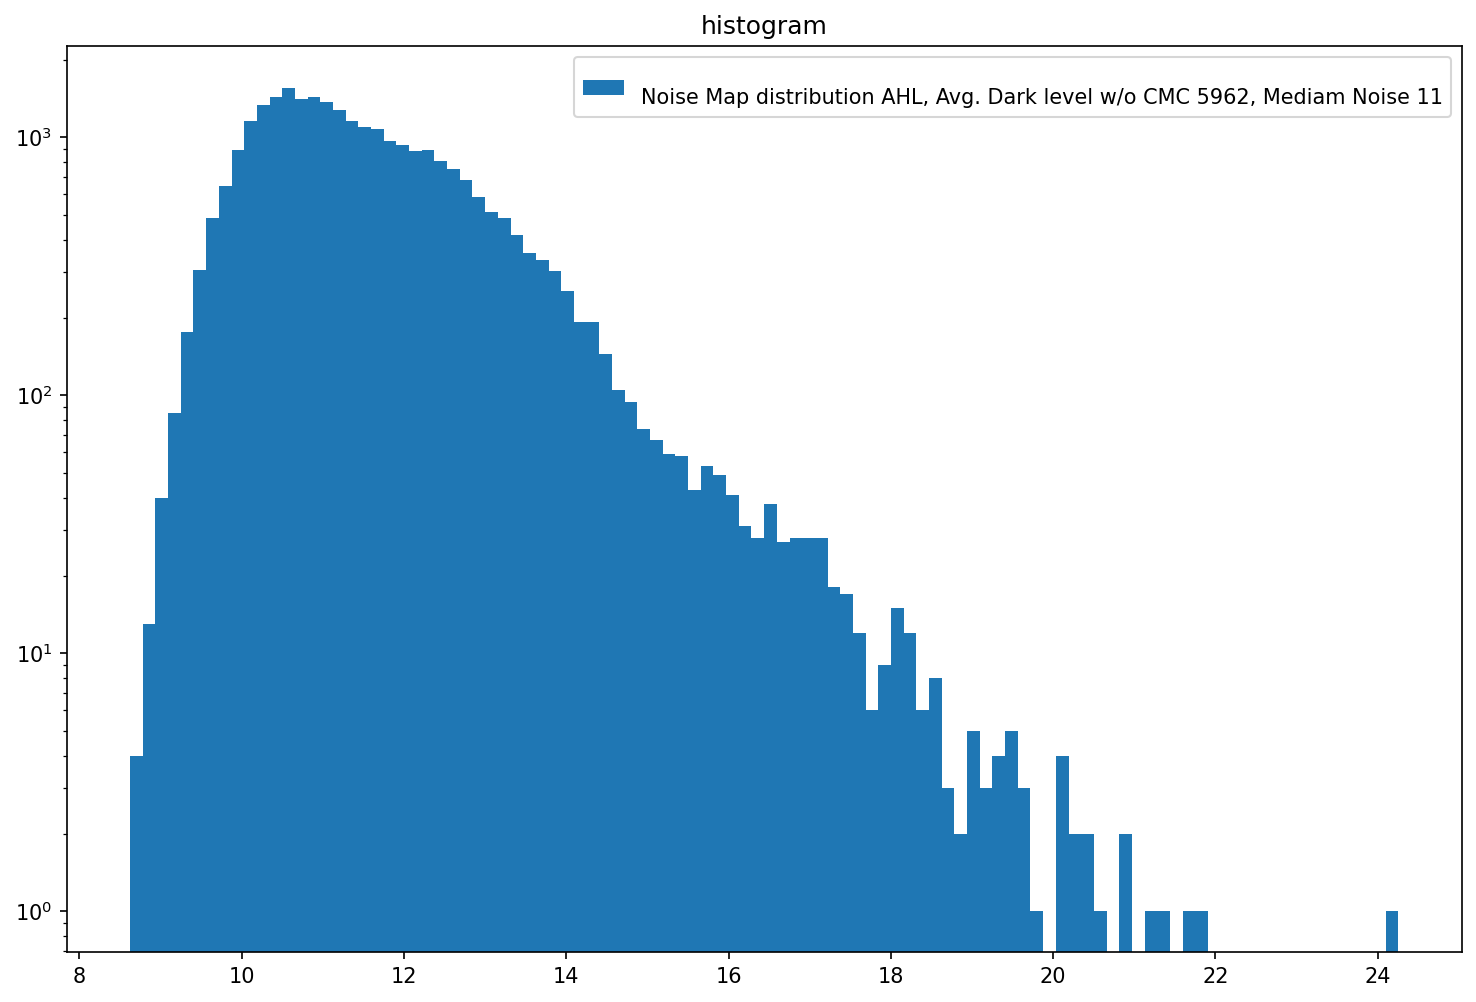


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 21
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_21_VRrefdac_58_run1.dat
Aquisition Counter 1277705
Number of frames received: 10006
Number of frames received: 12008
Number of frames received: 14011
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


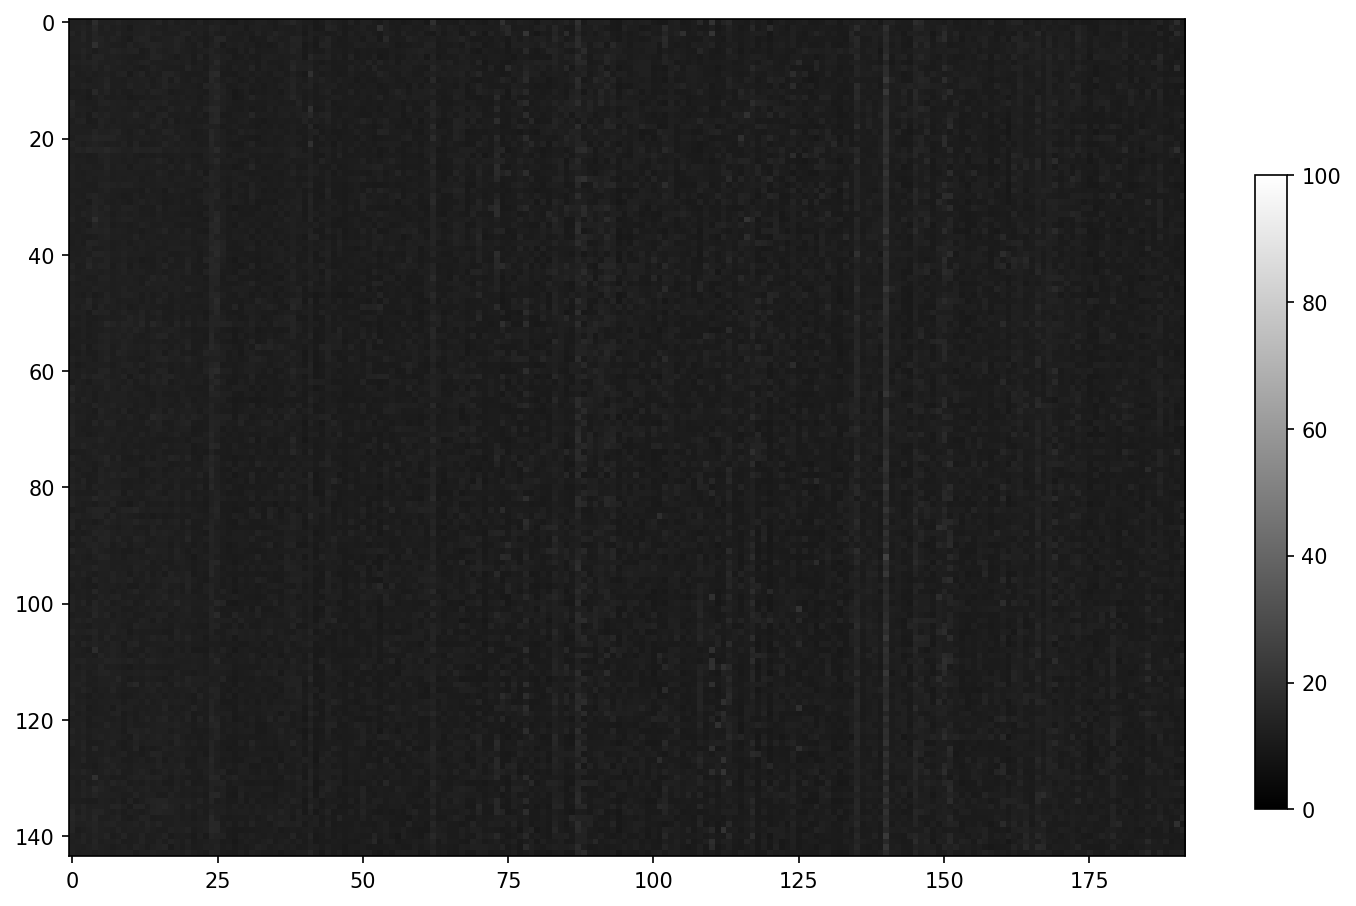

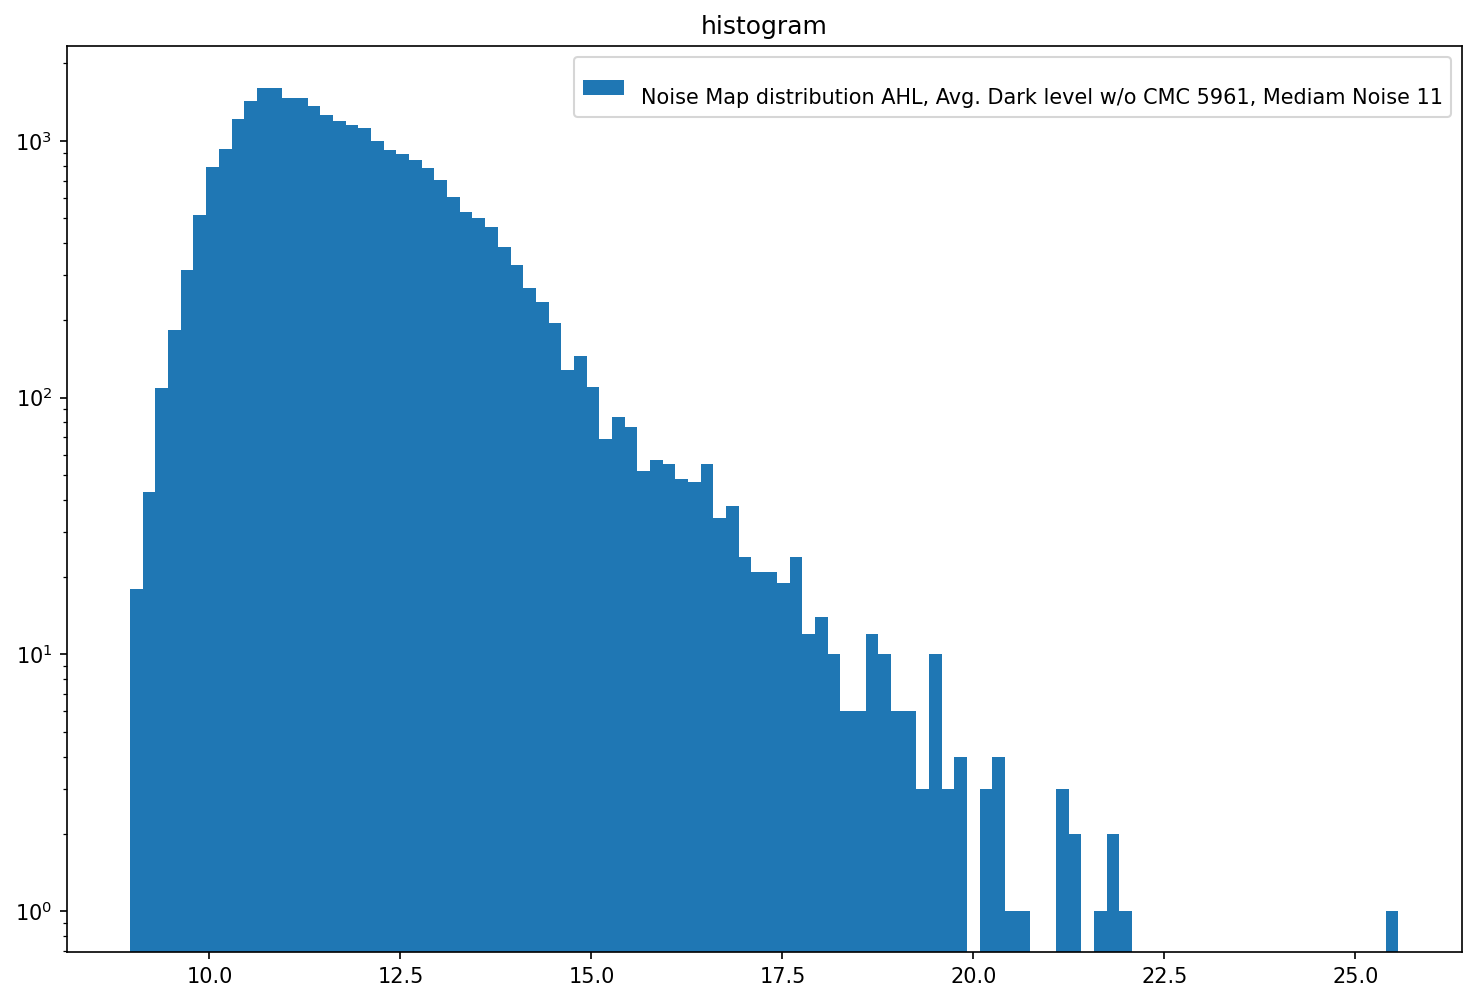


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 27
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_27_VRrefdac_58_run1.dat
Aquisition Counter 1291716
Number of frames received: 9915
Number of frames received: 11918
Number of frames received: 13921
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


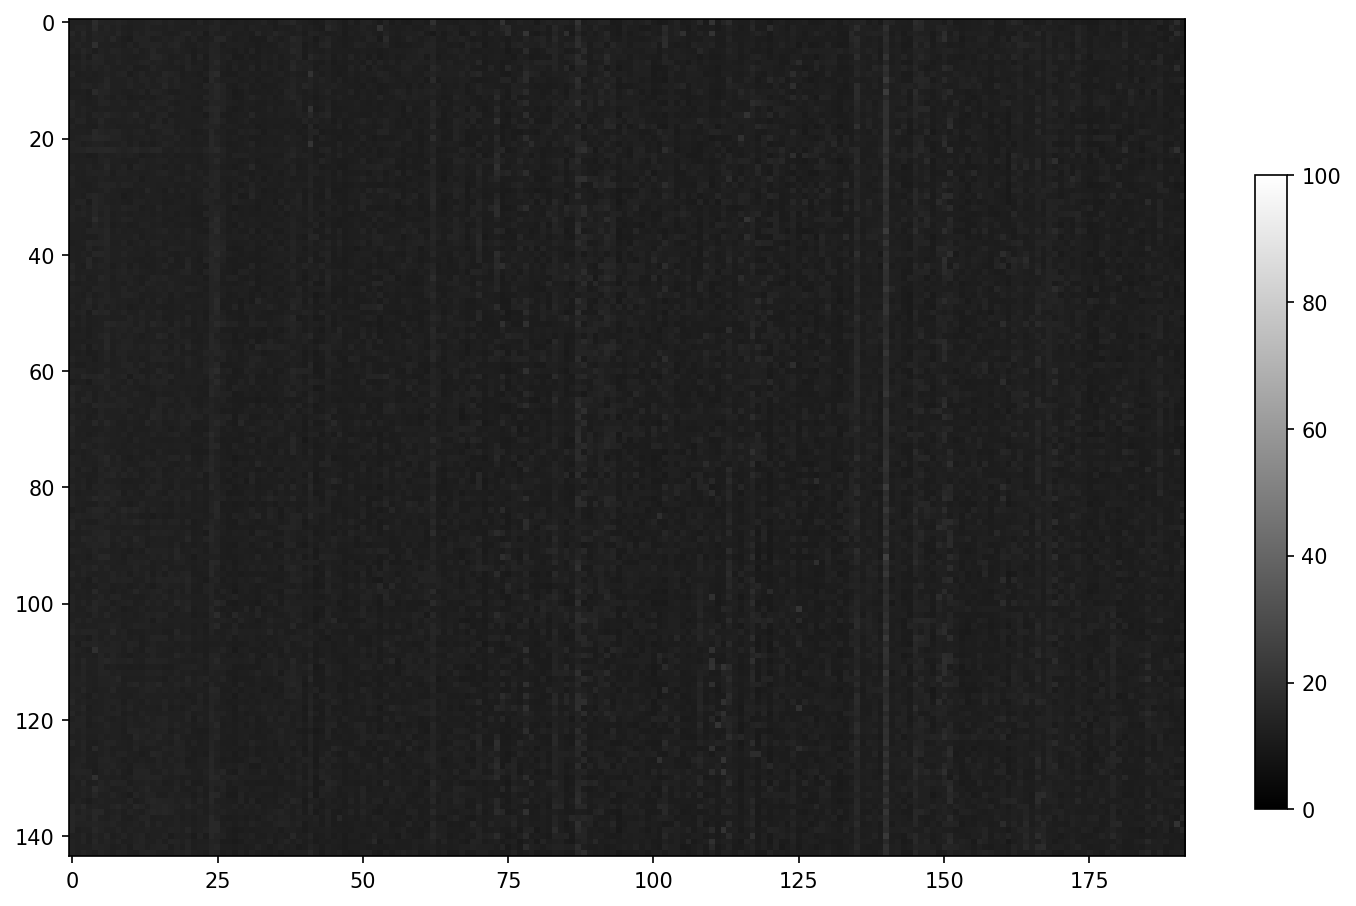

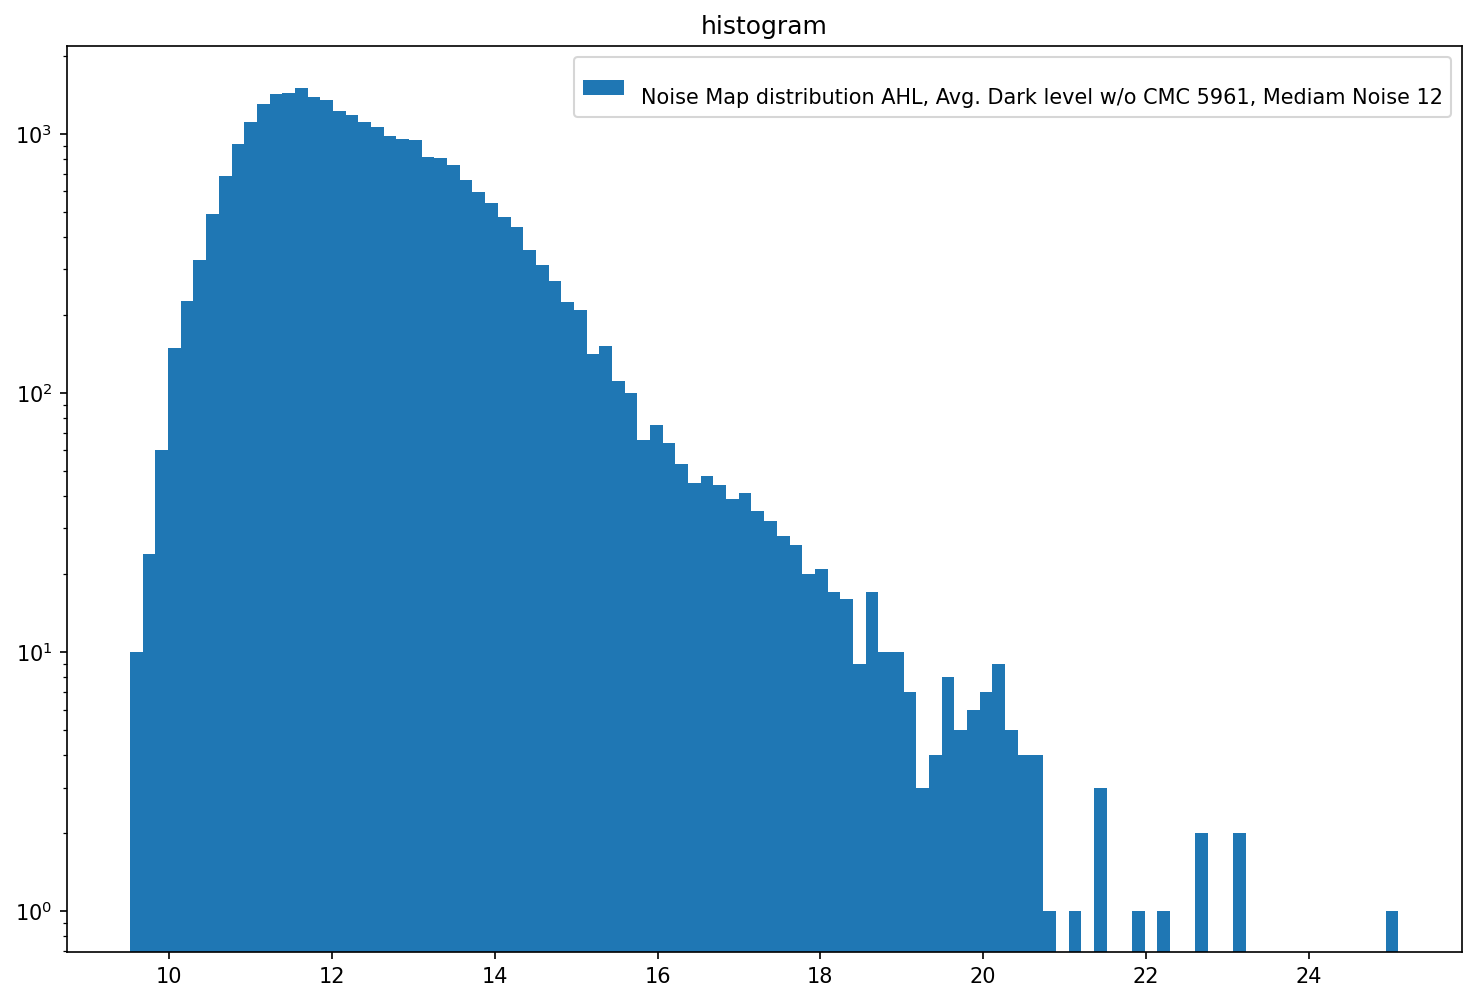


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 37
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_37_VRrefdac_58_run1.dat
Aquisition Counter 1305731
Number of frames received: 10008
Number of frames received: 12010
Number of frames received: 14013
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


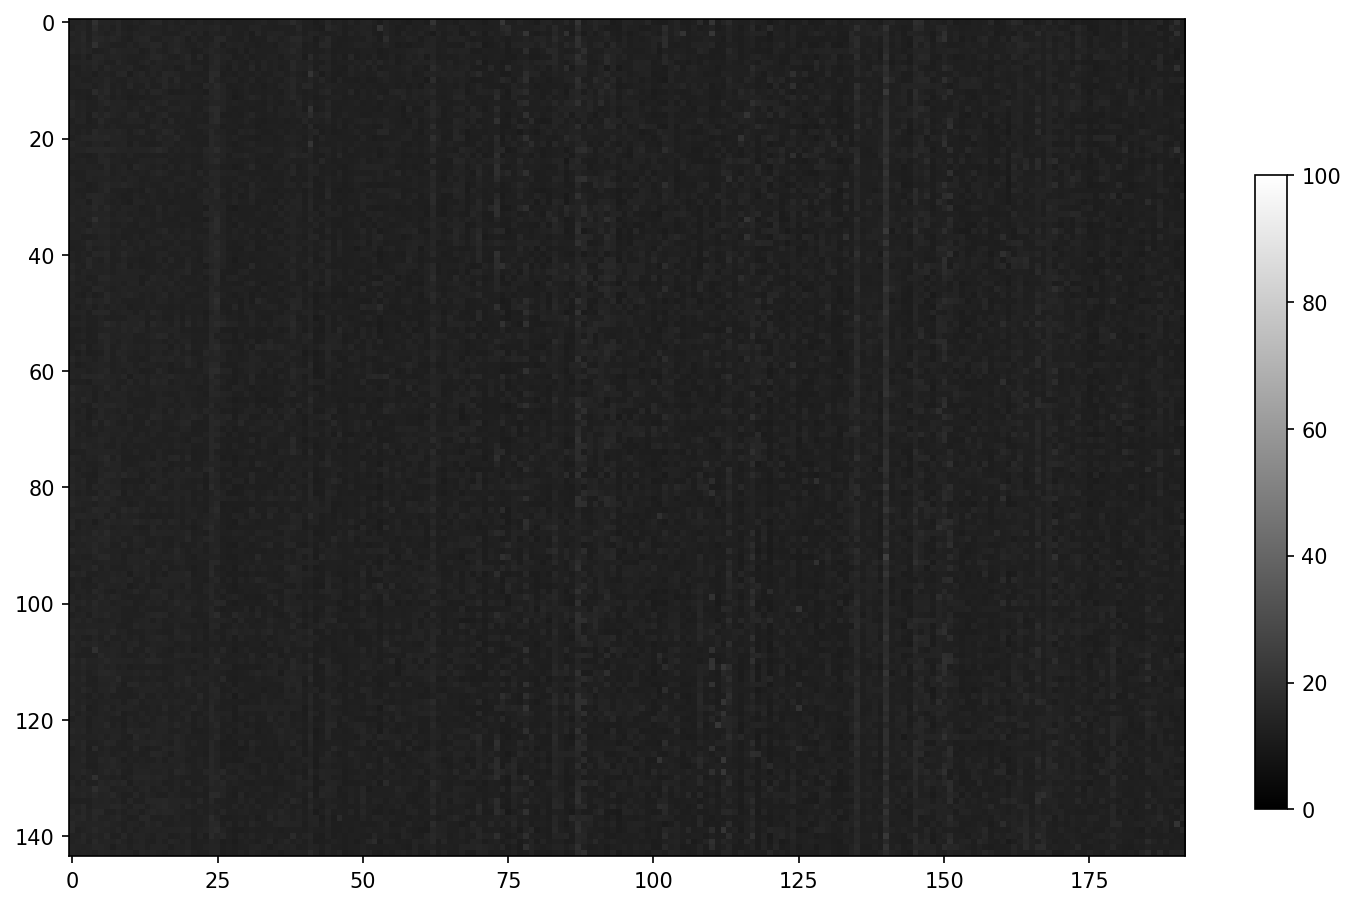

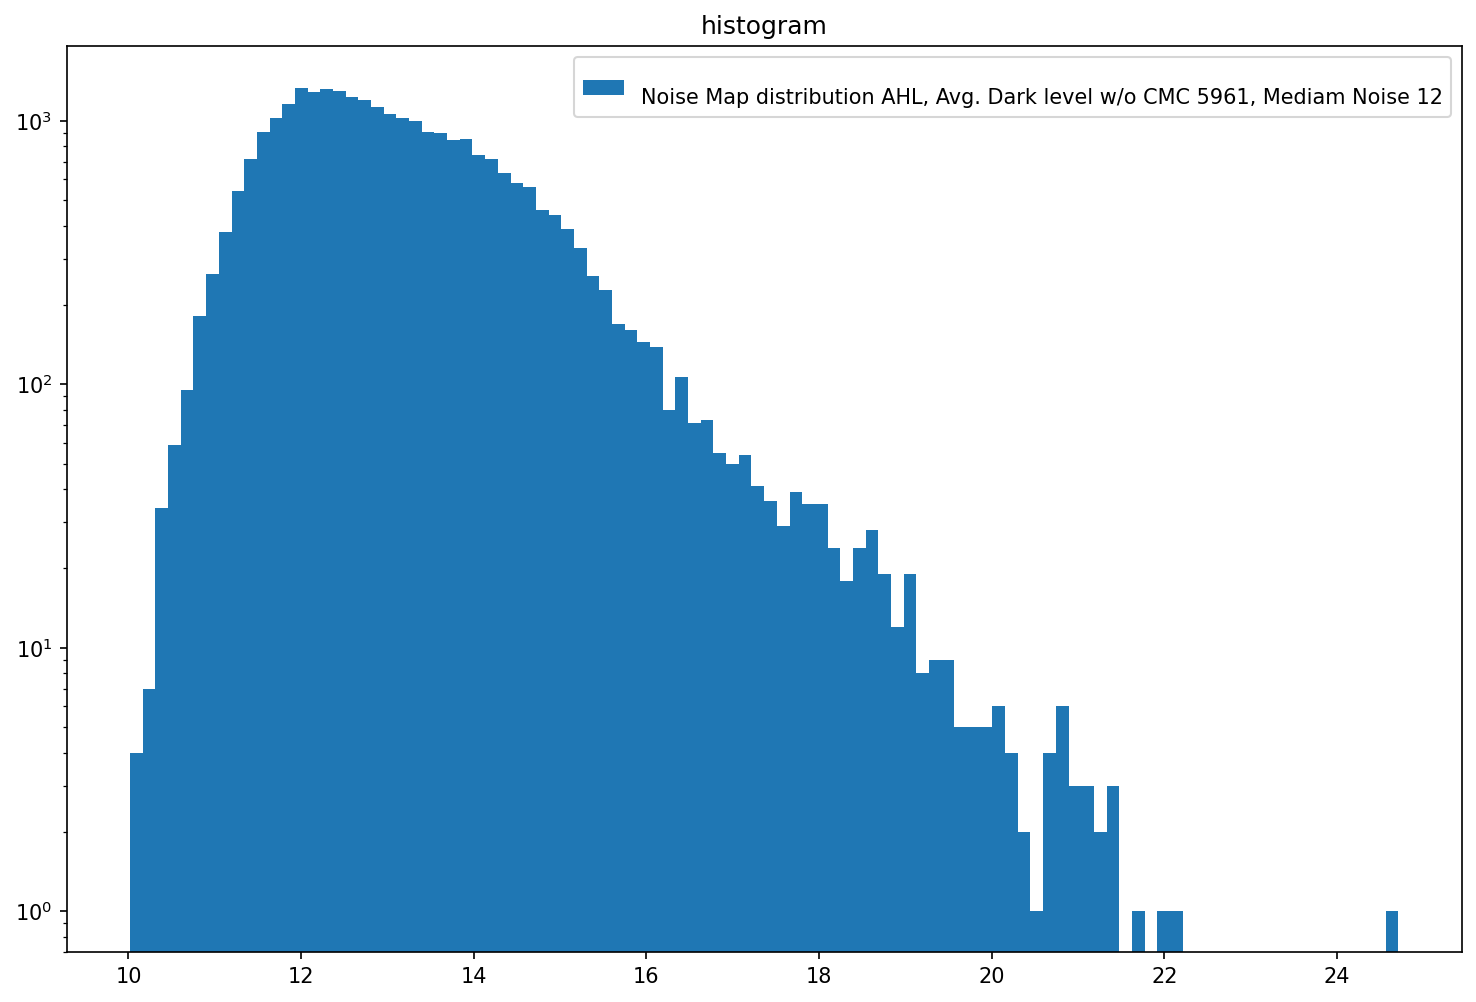


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 47
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_47_VRrefdac_58_run1.dat
Aquisition Counter 1319744
Number of frames received: 10009
Number of frames received: 12012
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


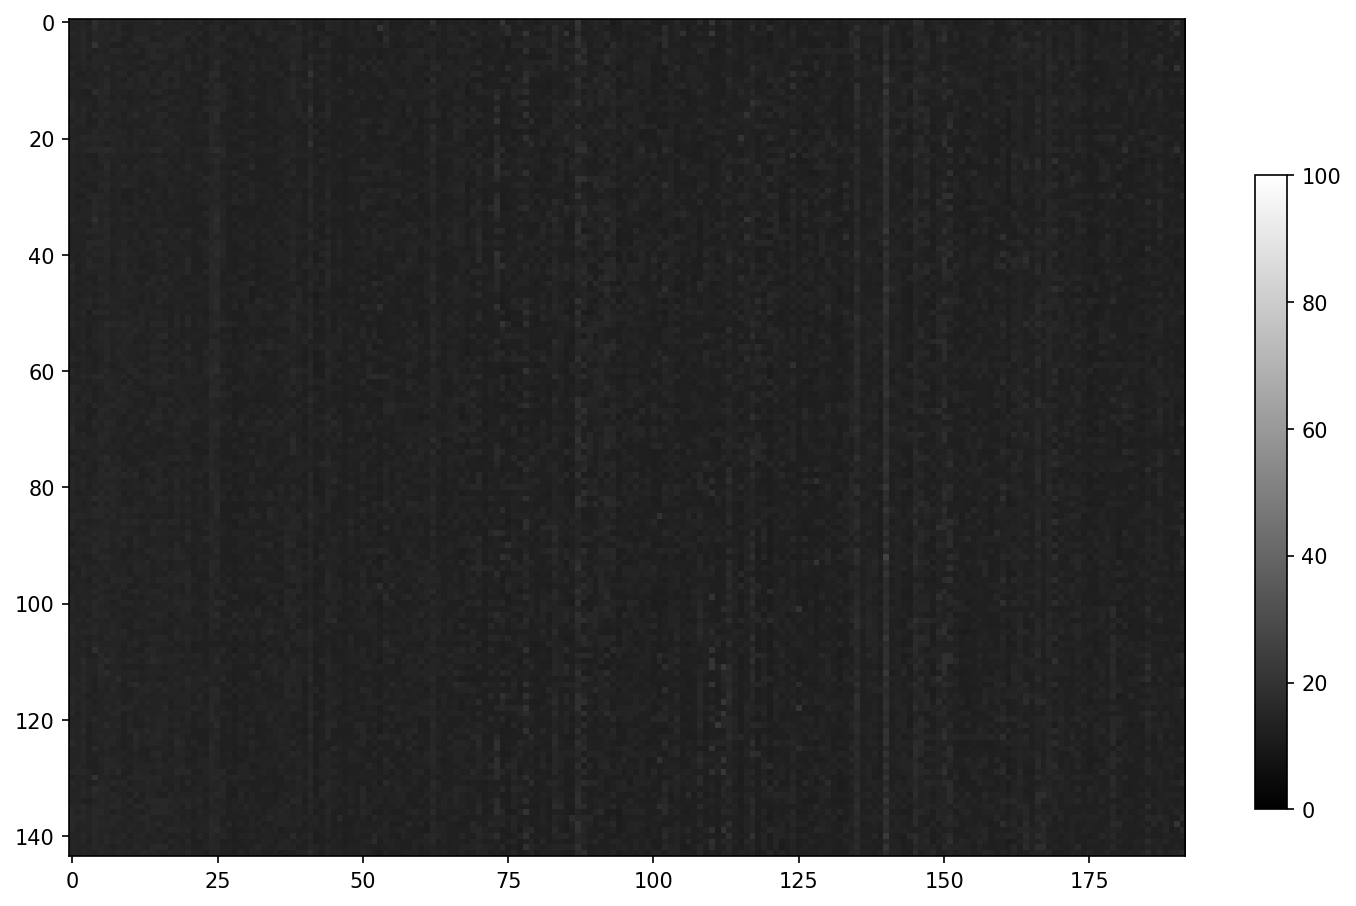

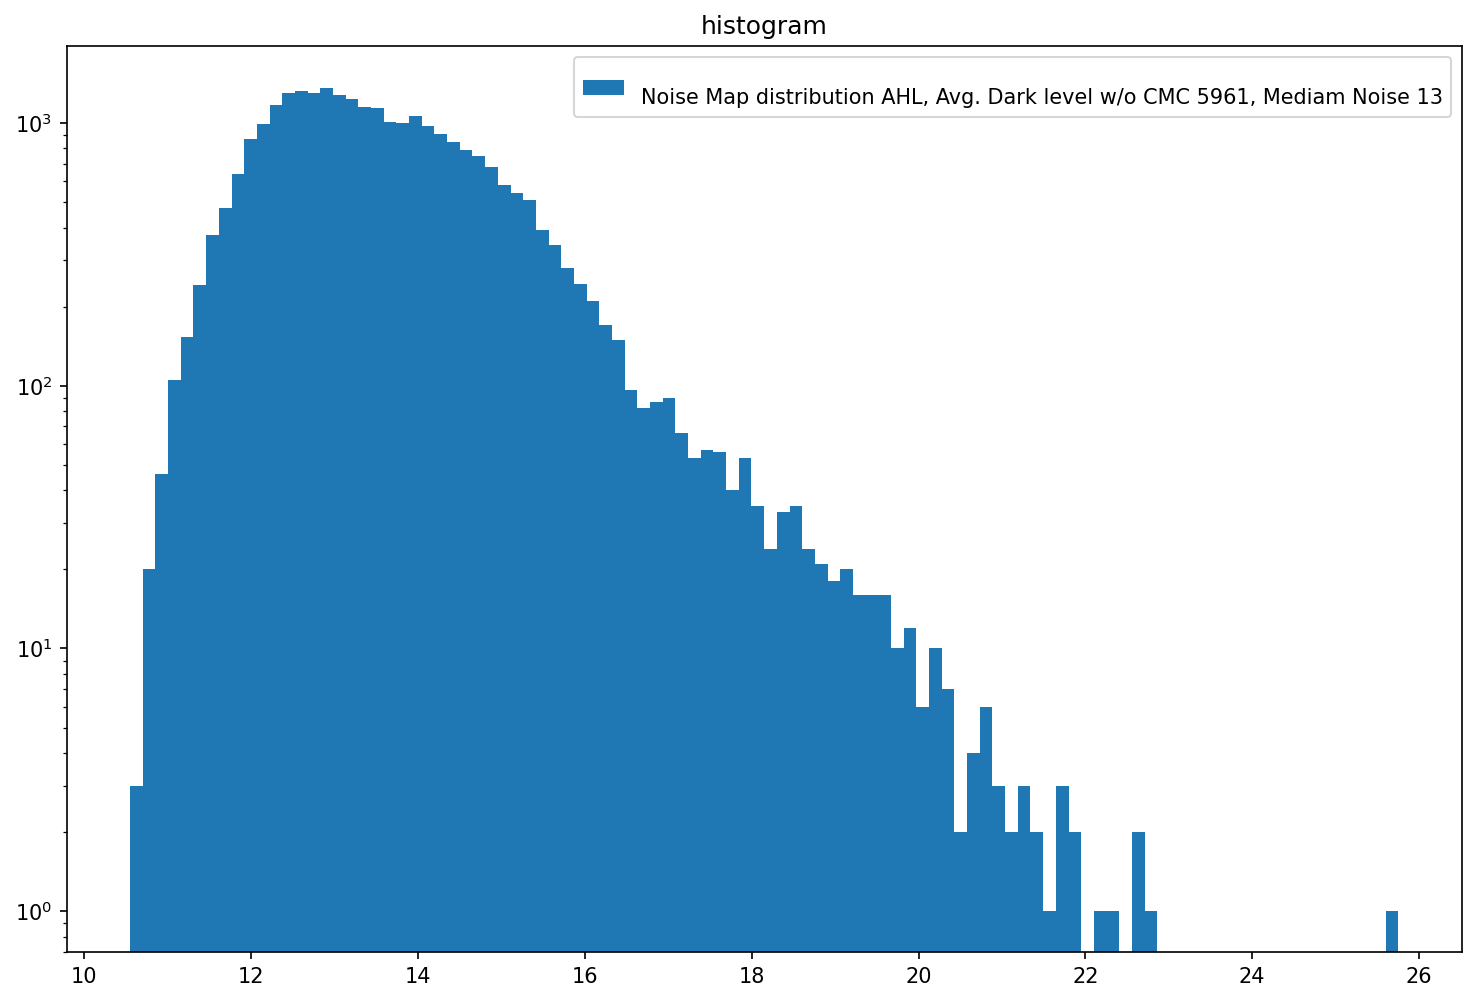


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 57
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_57_VRrefdac_58_run1.dat
Aquisition Counter 1333758
Number of frames received: 10009
Number of frames received: 12012
Number of frames received: 14015
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


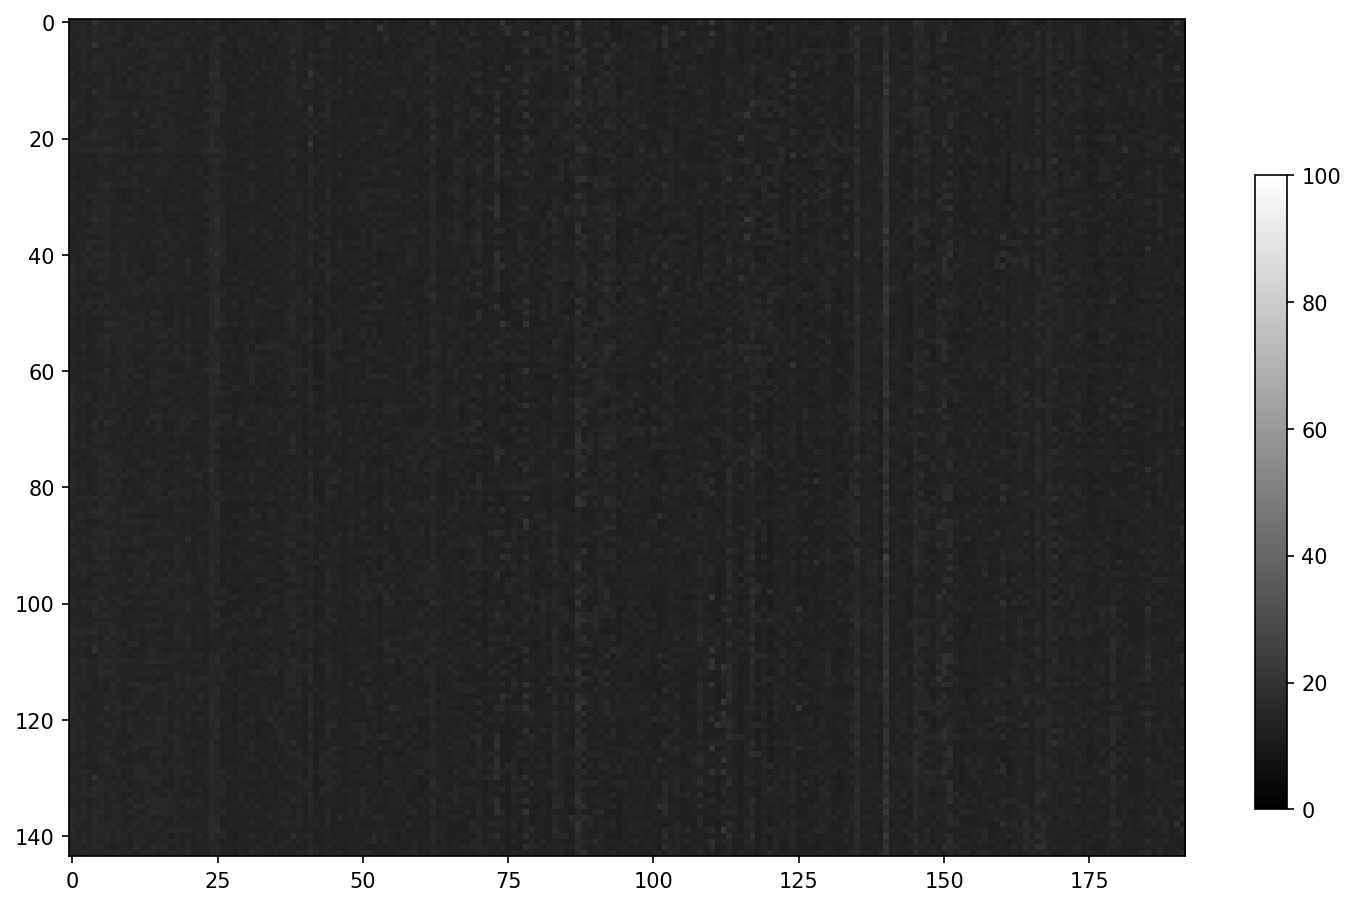

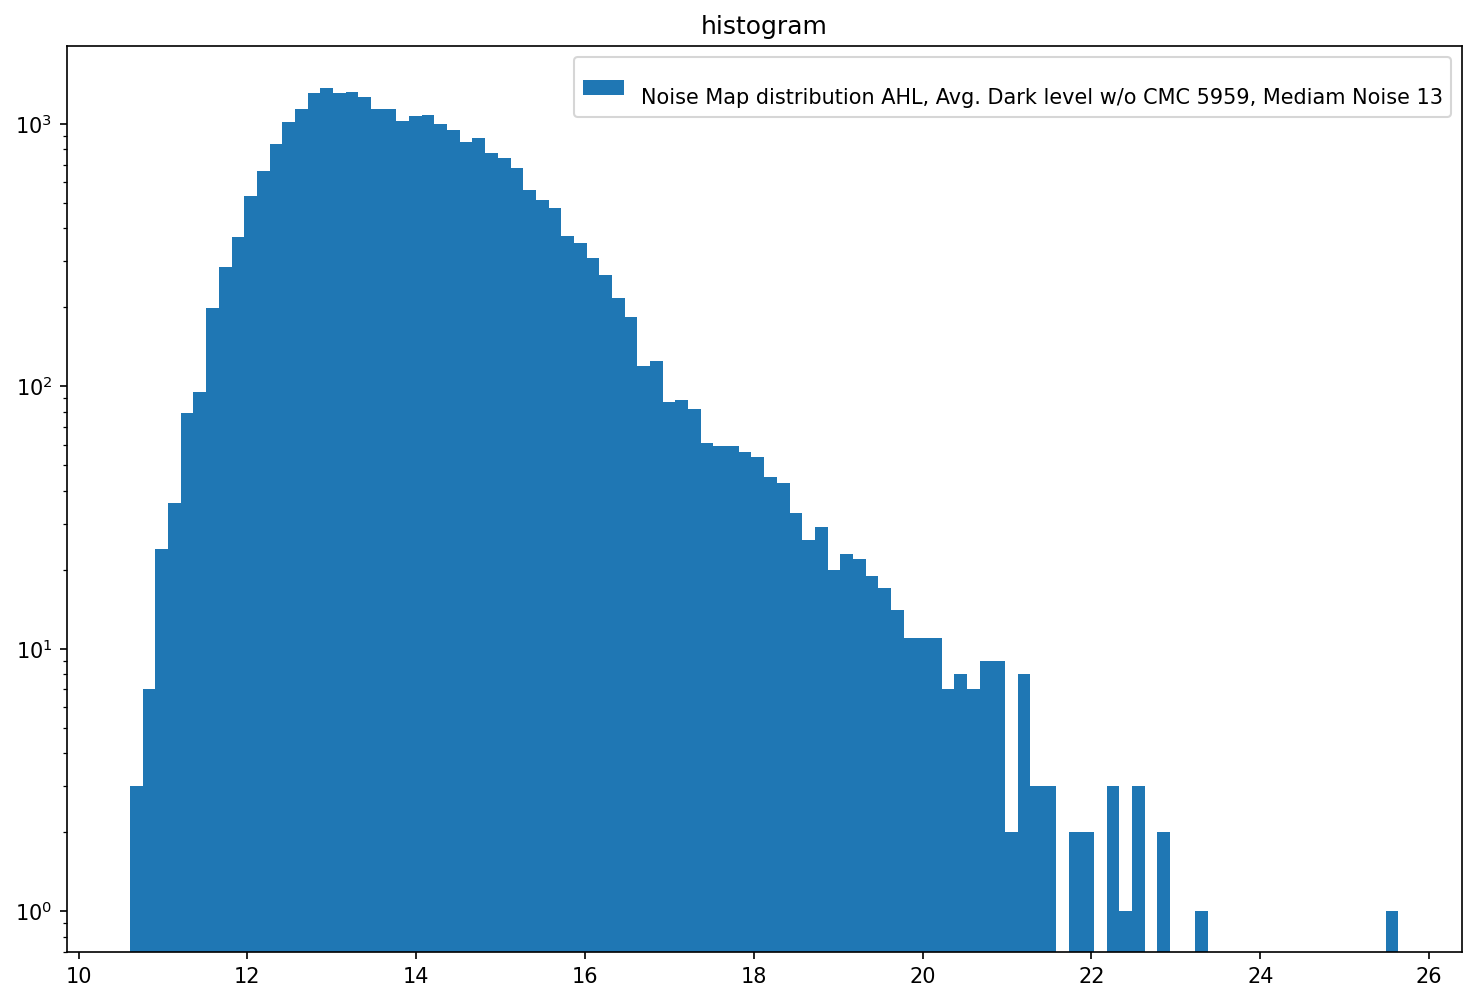

In [16]:
#Makes sure triggers are off
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(True)
time.sleep(0.1)
root.EpixHR.TriggerRegisters.RunTriggerEnable.set(False)
time.sleep(0.1)

Preamp = 2
Vld1_b = 0
Pixel_CB= 2
Filter_DACList=[7, 13, 15, 17, 19, 21, 27, 37, 47, 57]
VRef_DAC = 58

for Filter_DAC in Filter_DACList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()

Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 17
VRef_DAC 3
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_17_VRrefdac_3_run1.dat
Aquisition Counter 1347773
Number of frames received: 10008
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


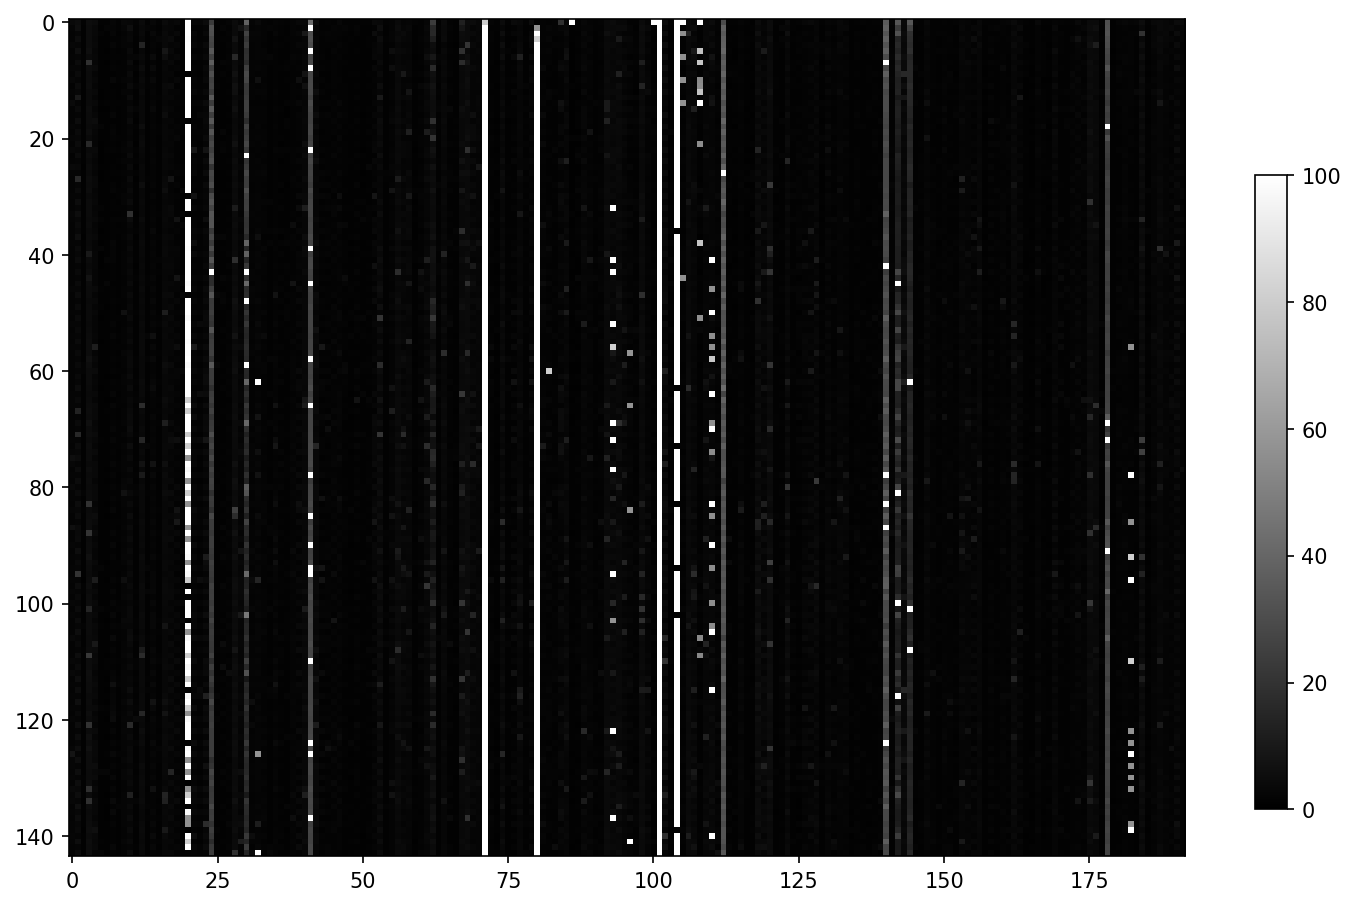

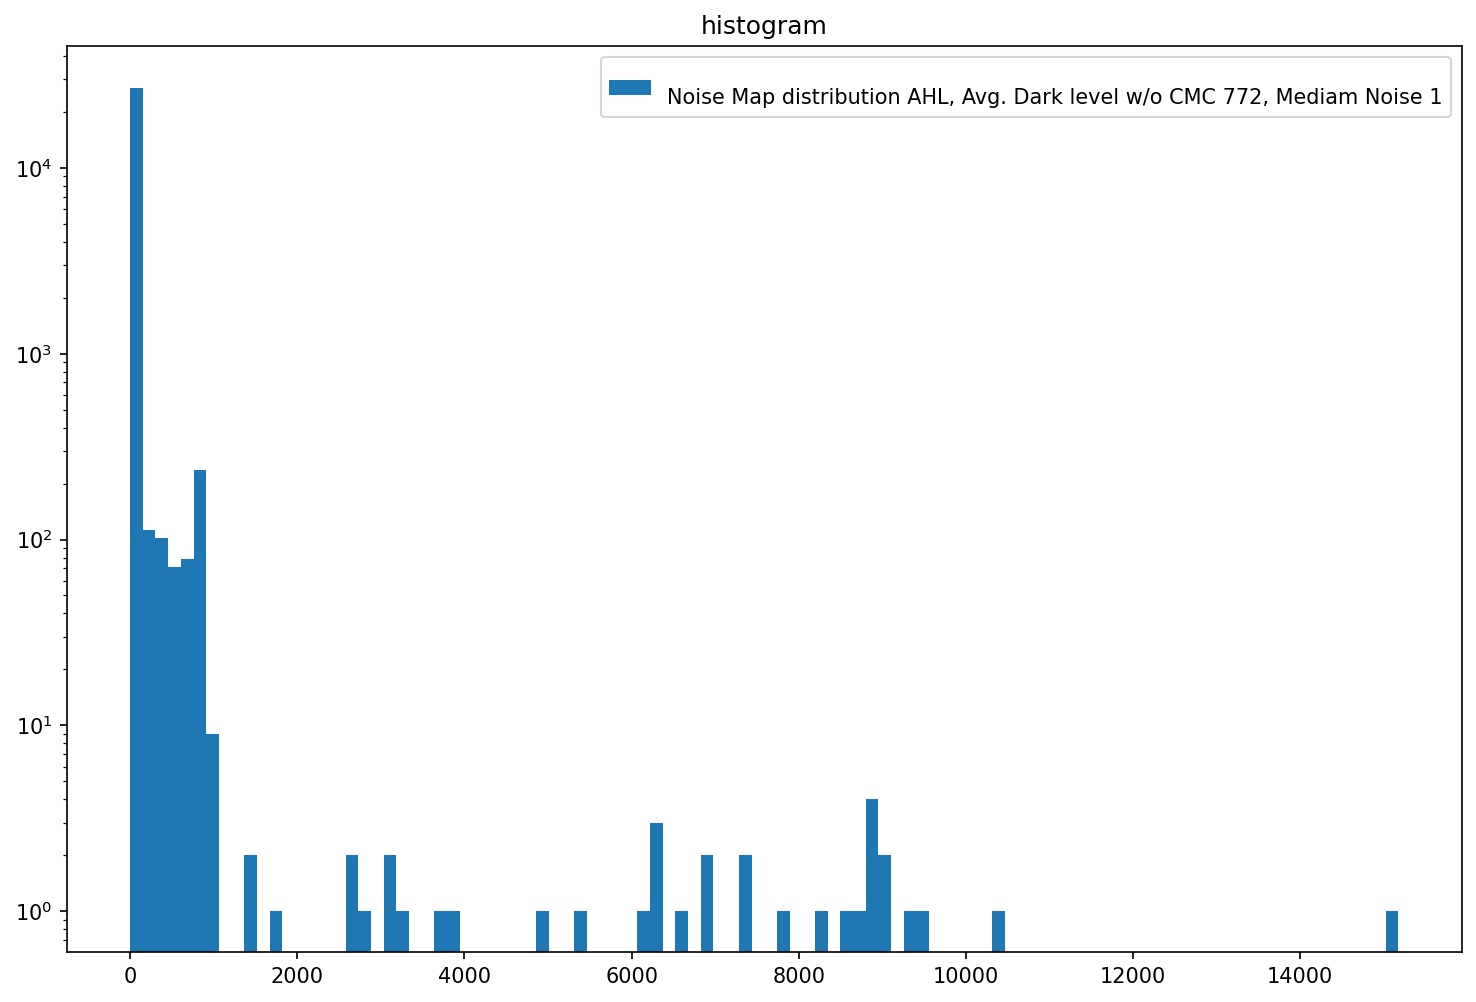


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 17
VRef_DAC 13
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_17_VRrefdac_13_run1.dat
Aquisition Counter 1361787
Number of frames received: 10009
Number of frames received: 12012
Number of frames received: 14015
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


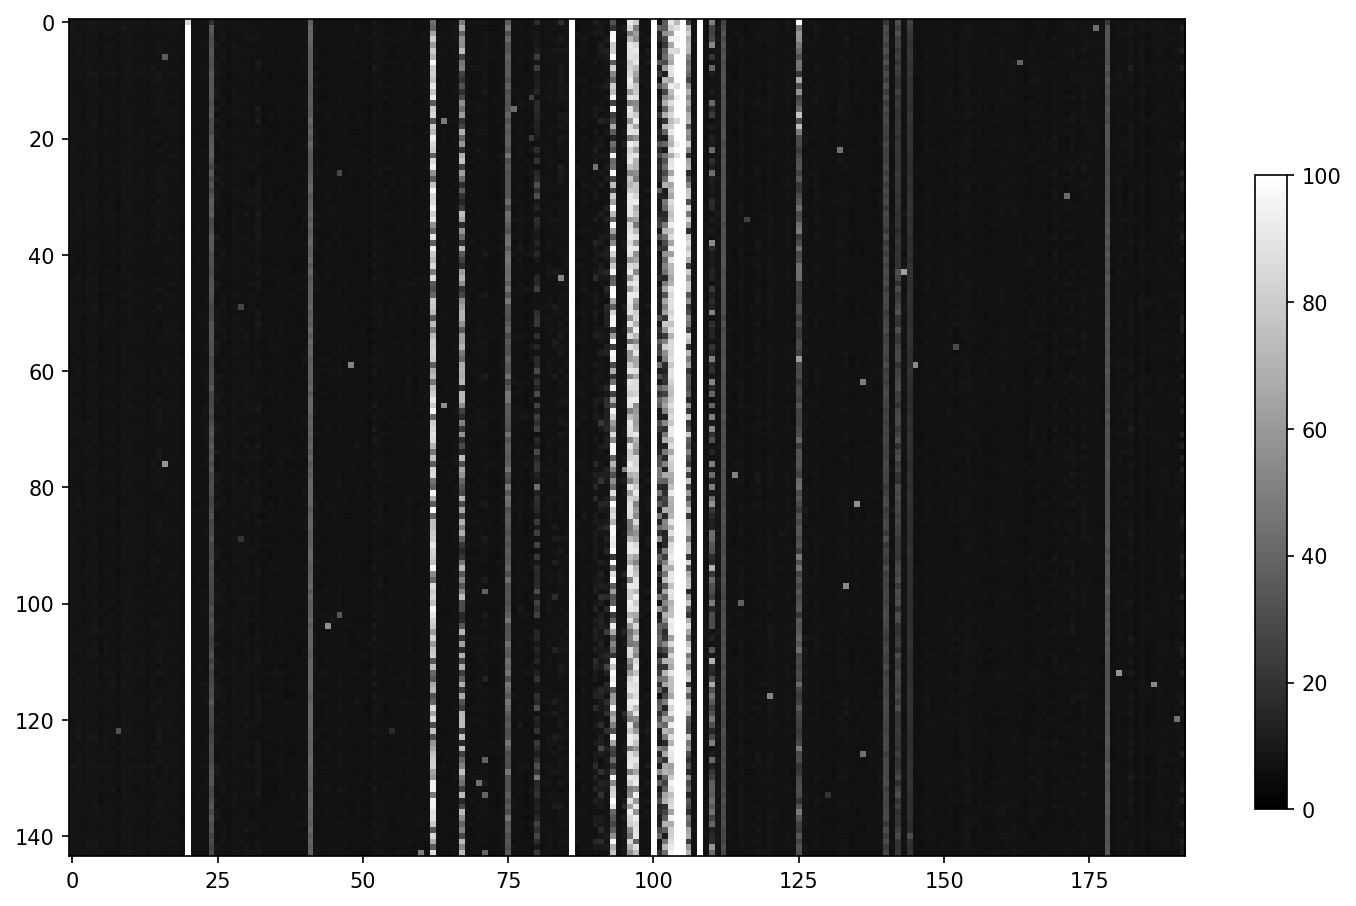

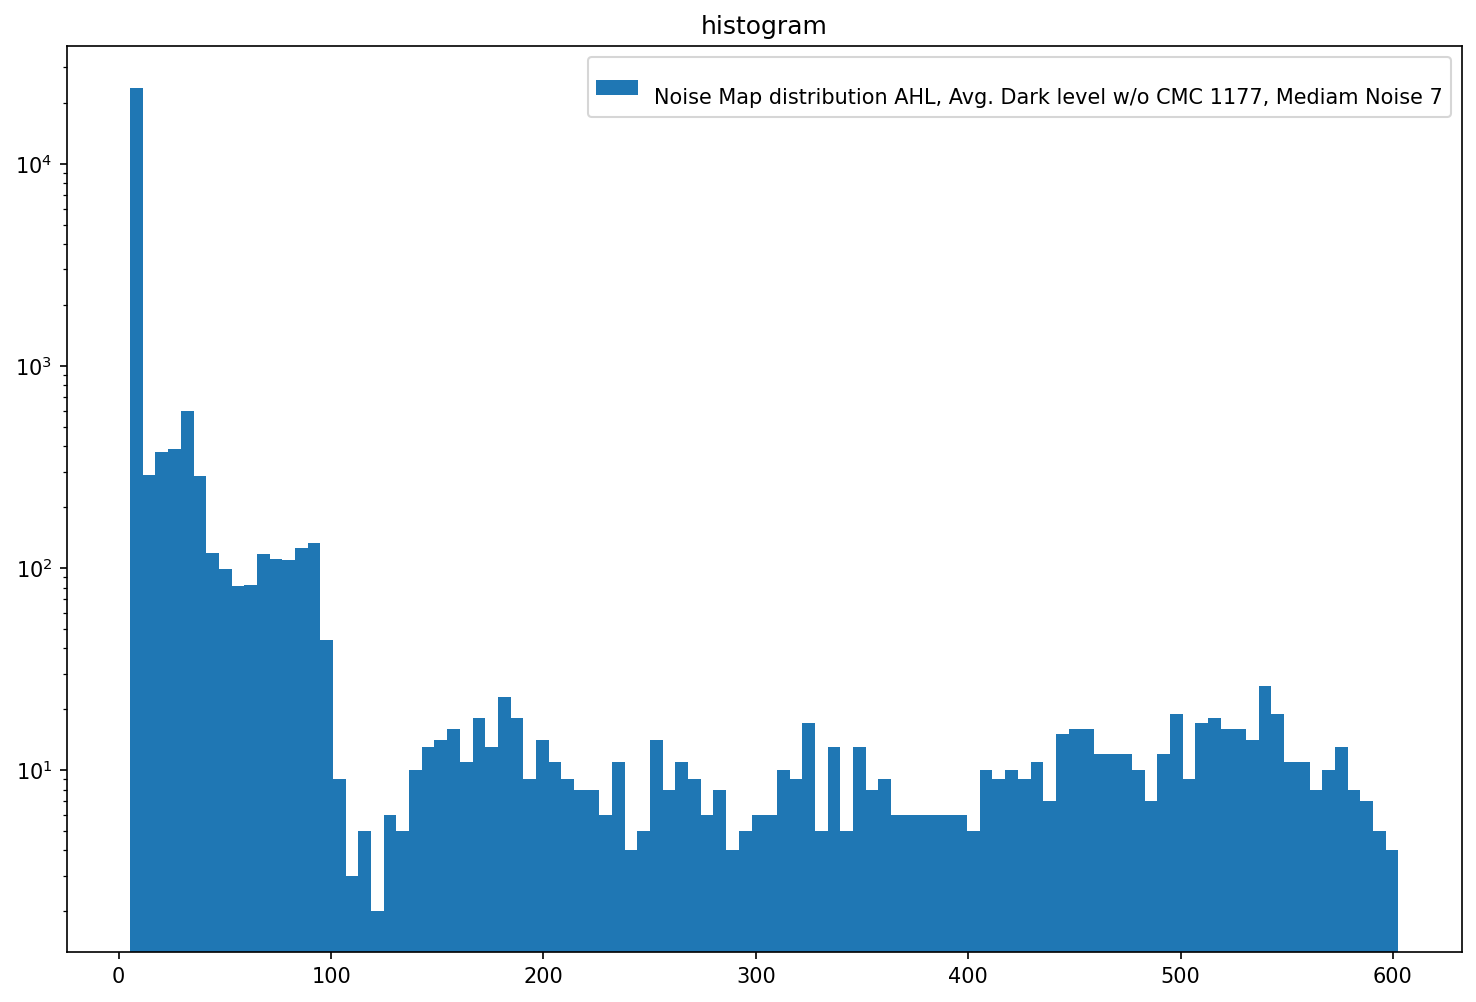


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 17
VRef_DAC 23
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_17_VRrefdac_23_run1.dat
Aquisition Counter 1375802
Number of frames received: 10008
Number of frames received: 12010
Number of frames received: 14013
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


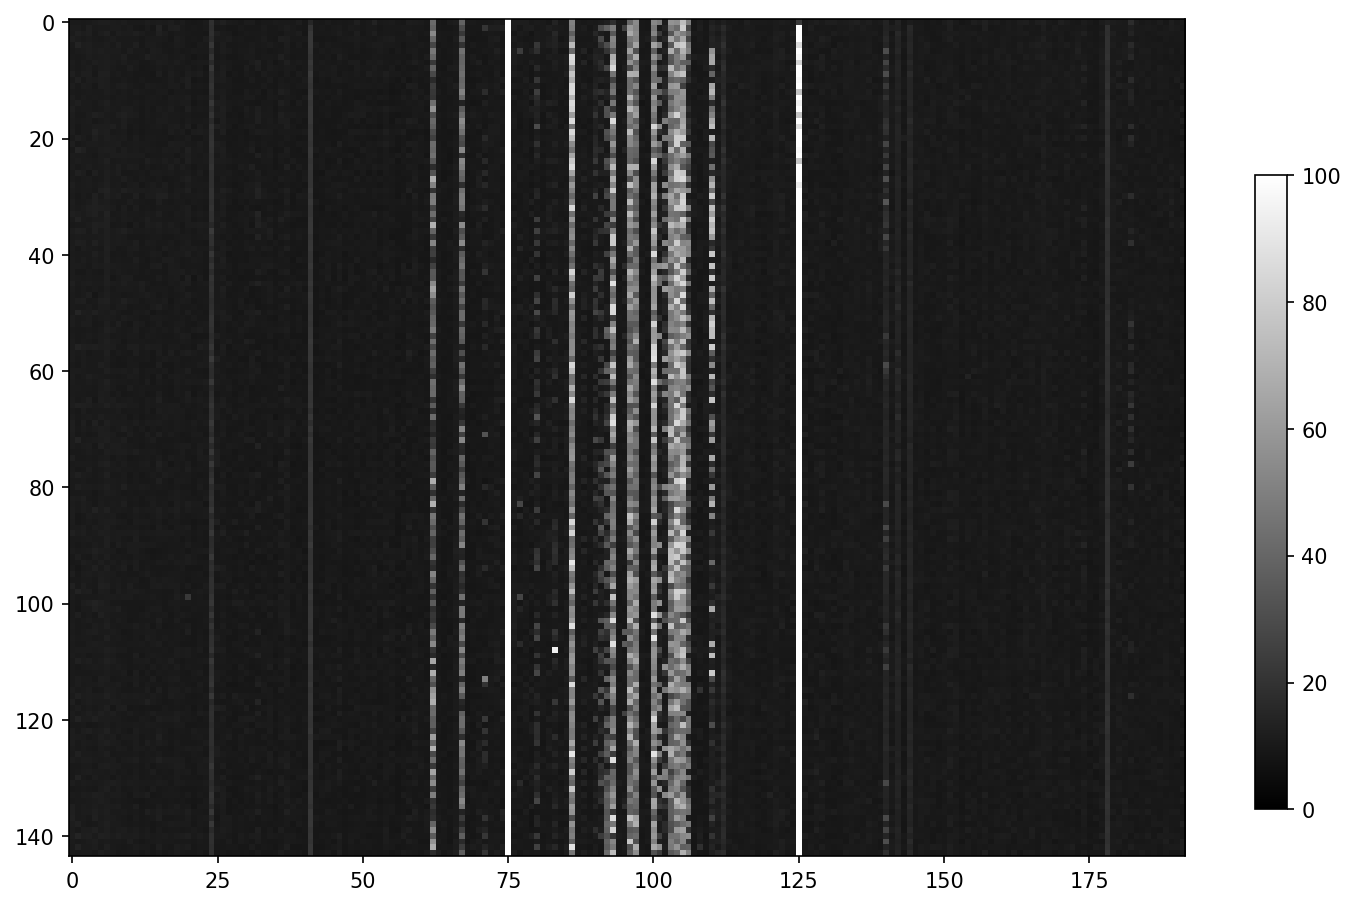

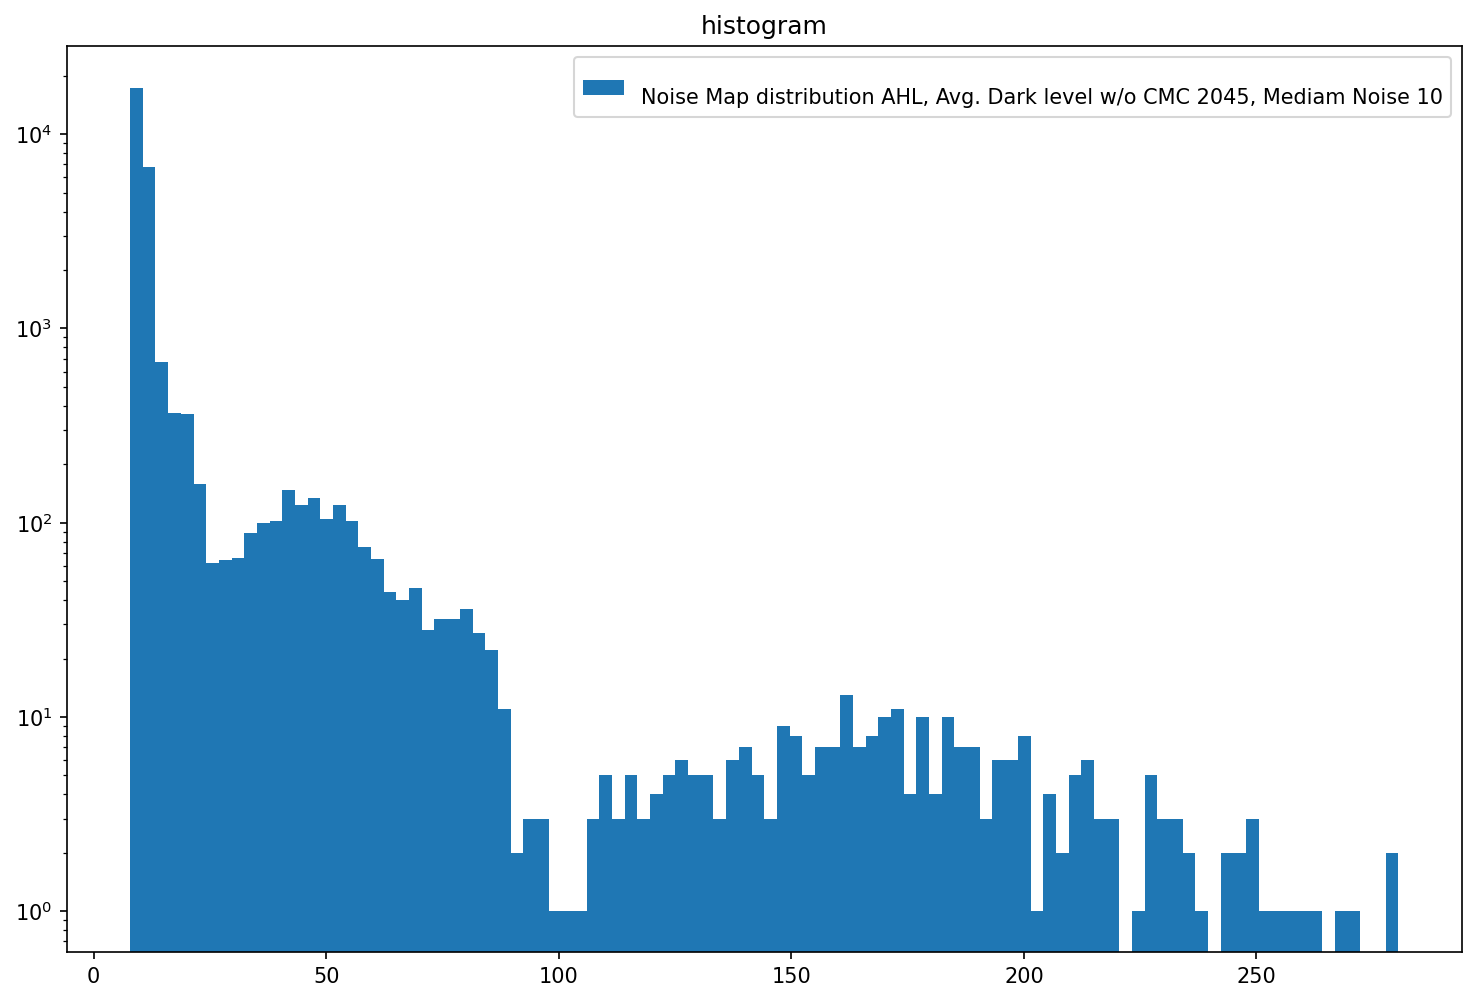


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 17
VRef_DAC 33
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_17_VRrefdac_33_run1.dat
Aquisition Counter 1389815
Number of frames received: 10009
Number of frames received: 12012
Number of frames received: 14015
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


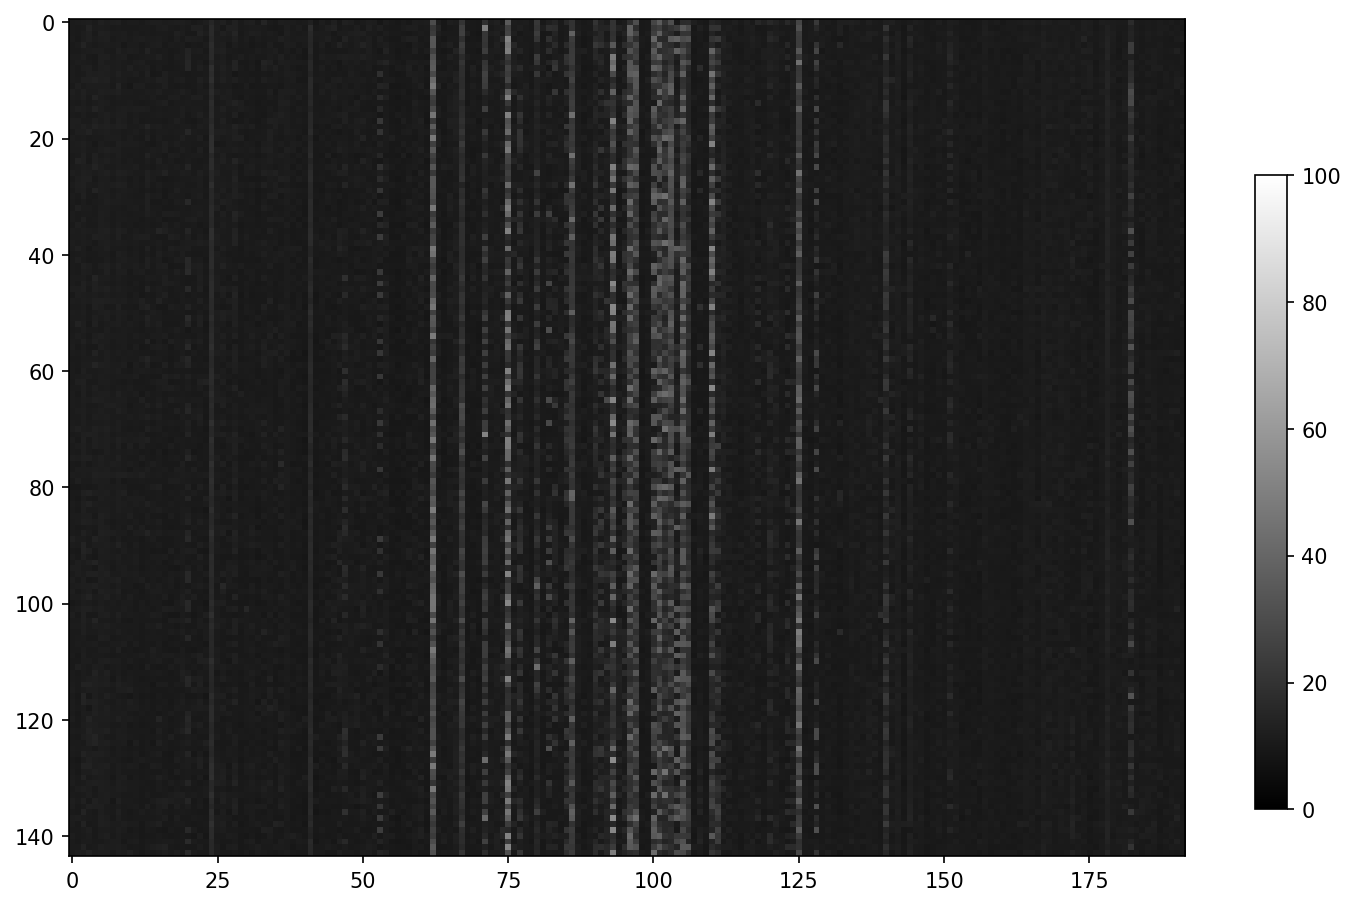

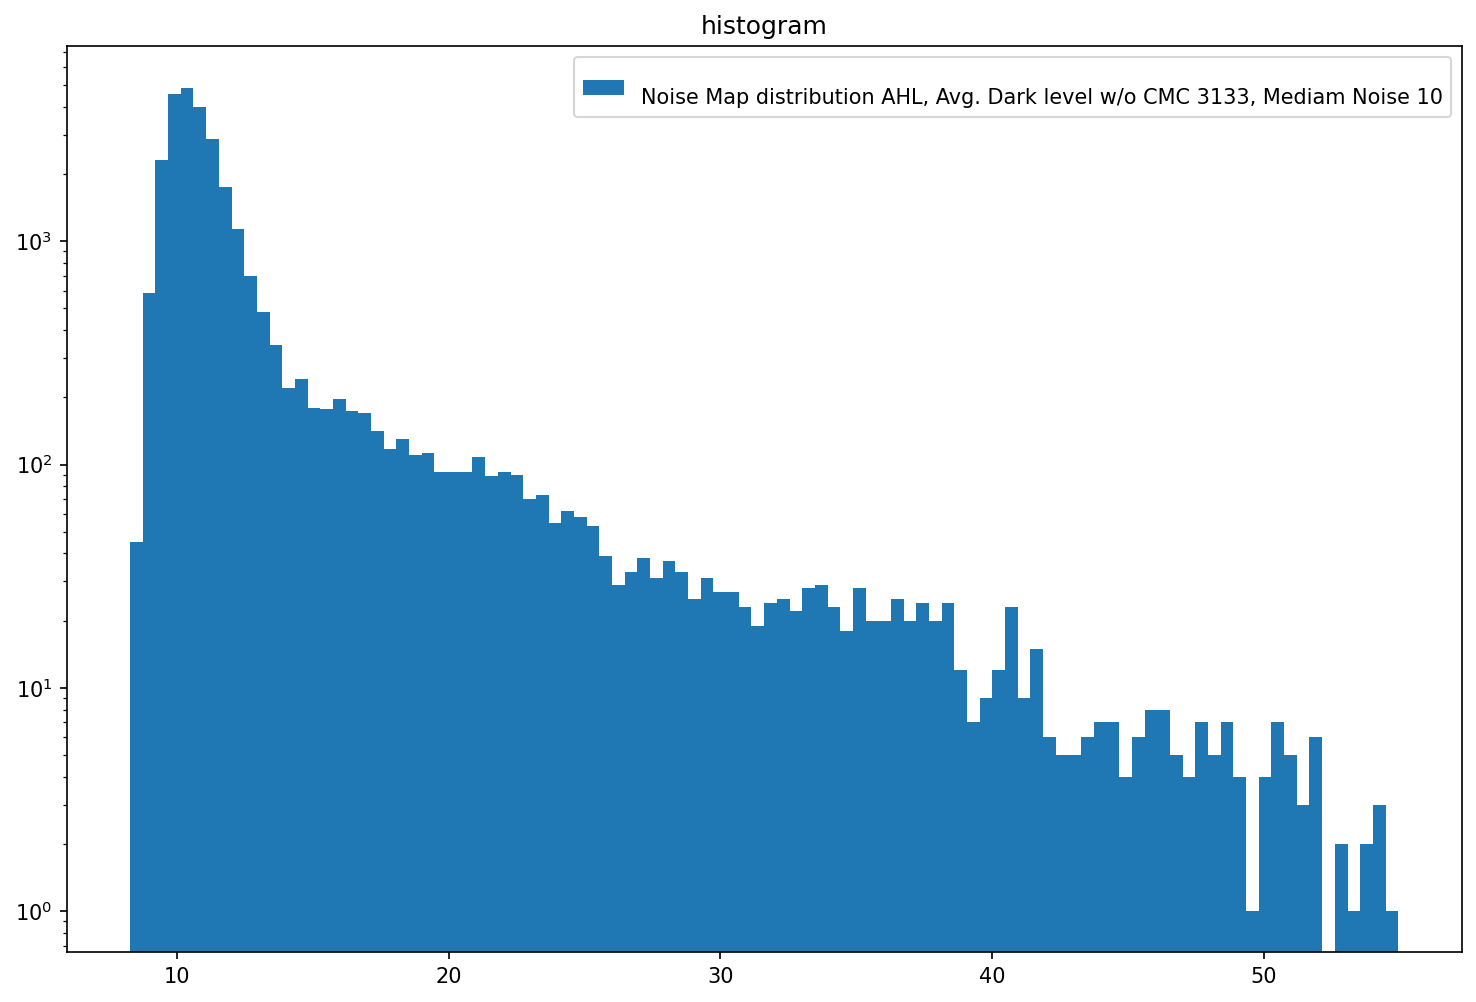


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 17
VRef_DAC 43
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_17_VRrefdac_43_run1.dat
Aquisition Counter 1403830
Number of frames received: 10009
Number of frames received: 12012
Number of frames received: 14015
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


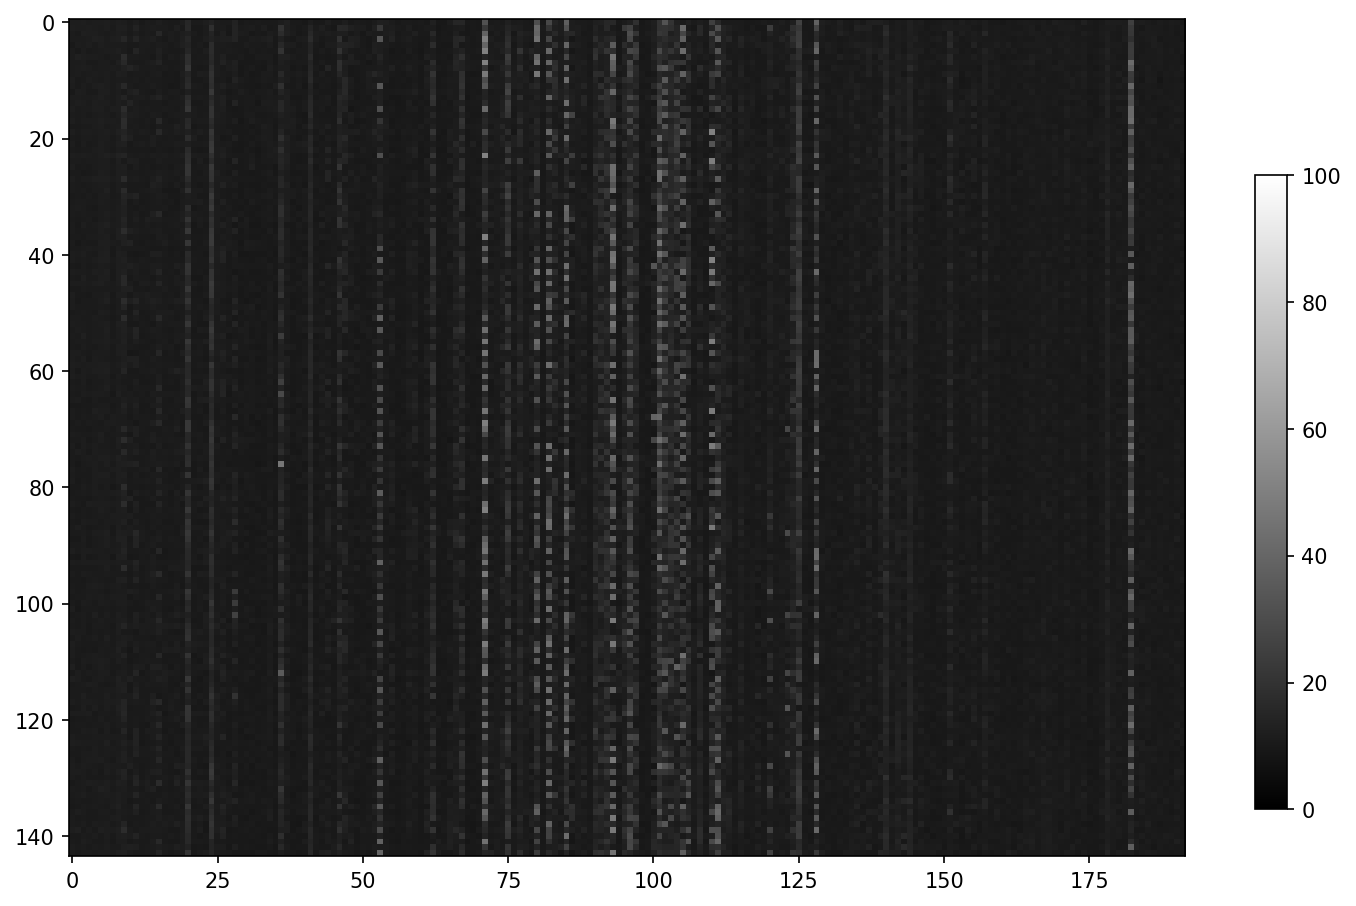

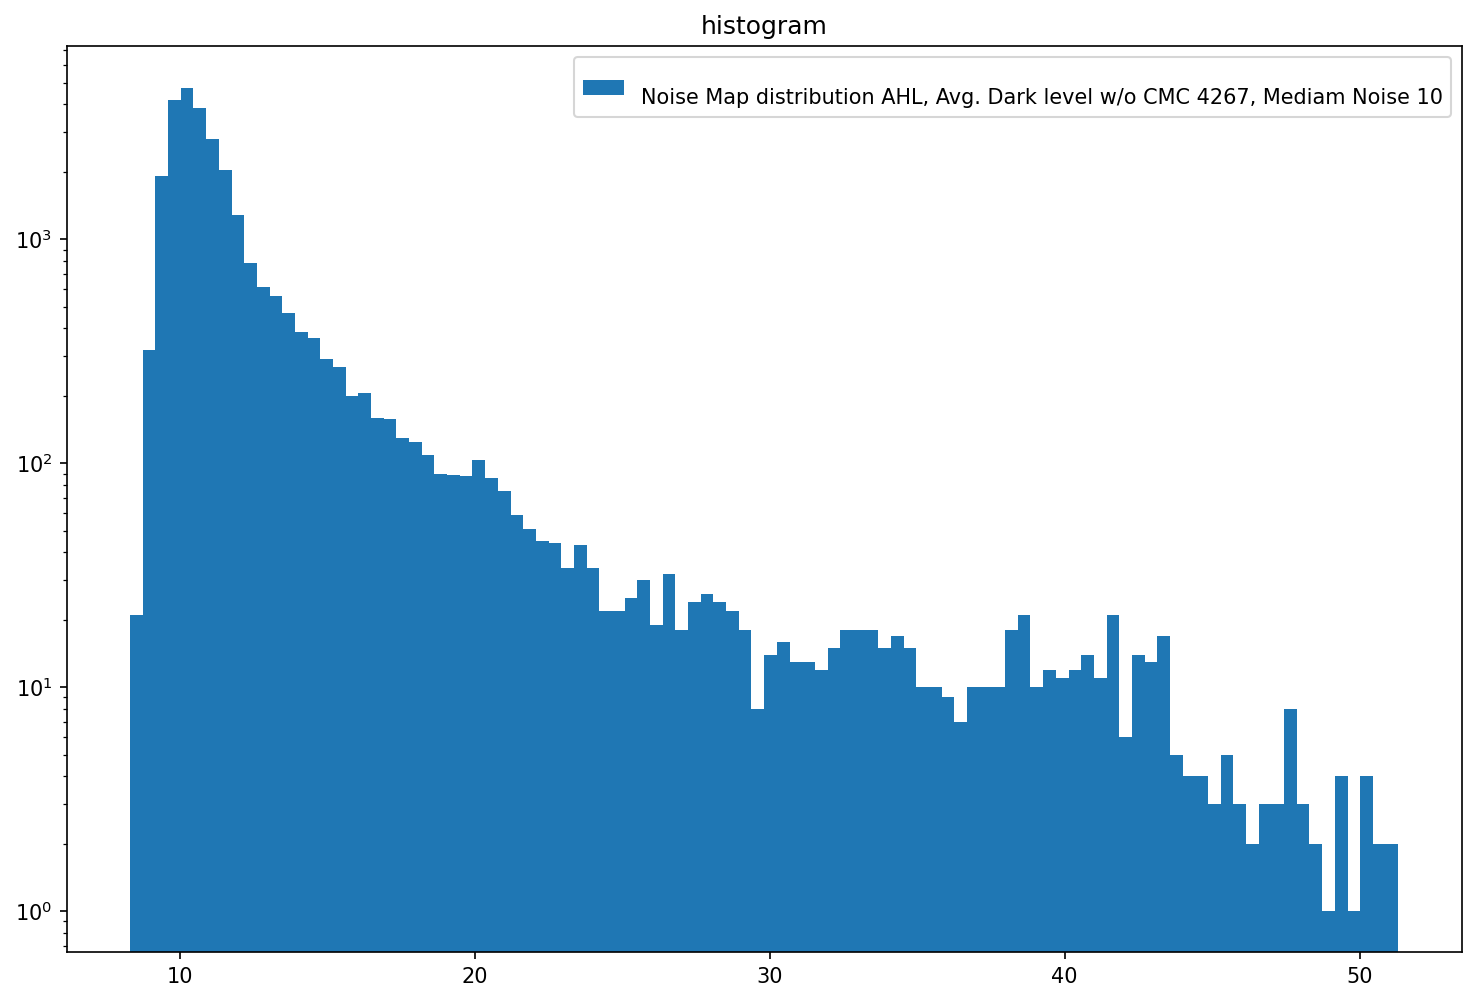


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 17
VRef_DAC 48
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_17_VRrefdac_48_run1.dat
Aquisition Counter 1417845
Number of frames received: 10009
Number of frames received: 12011
Number of frames received: 14014
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


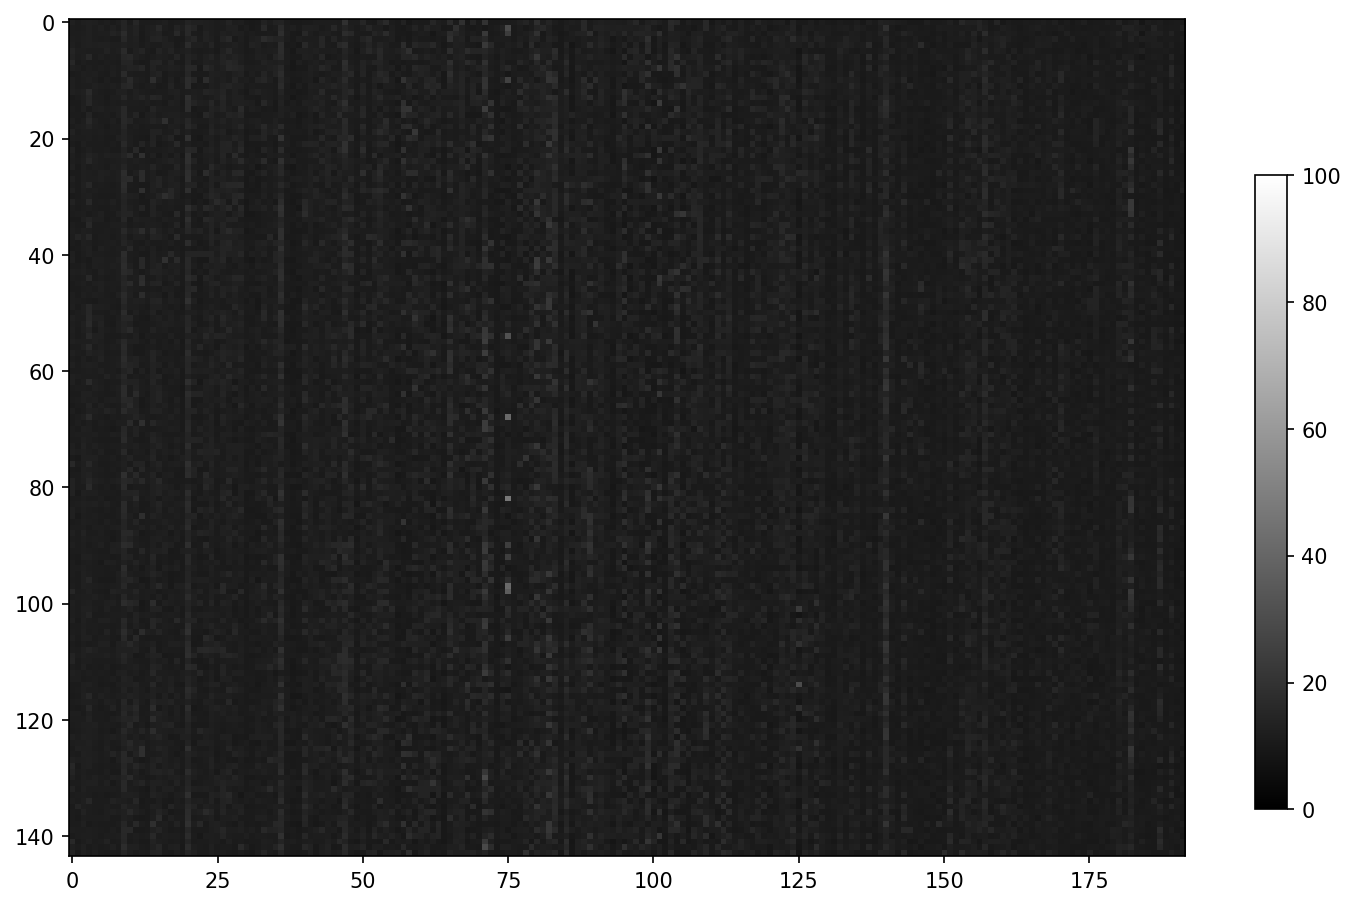

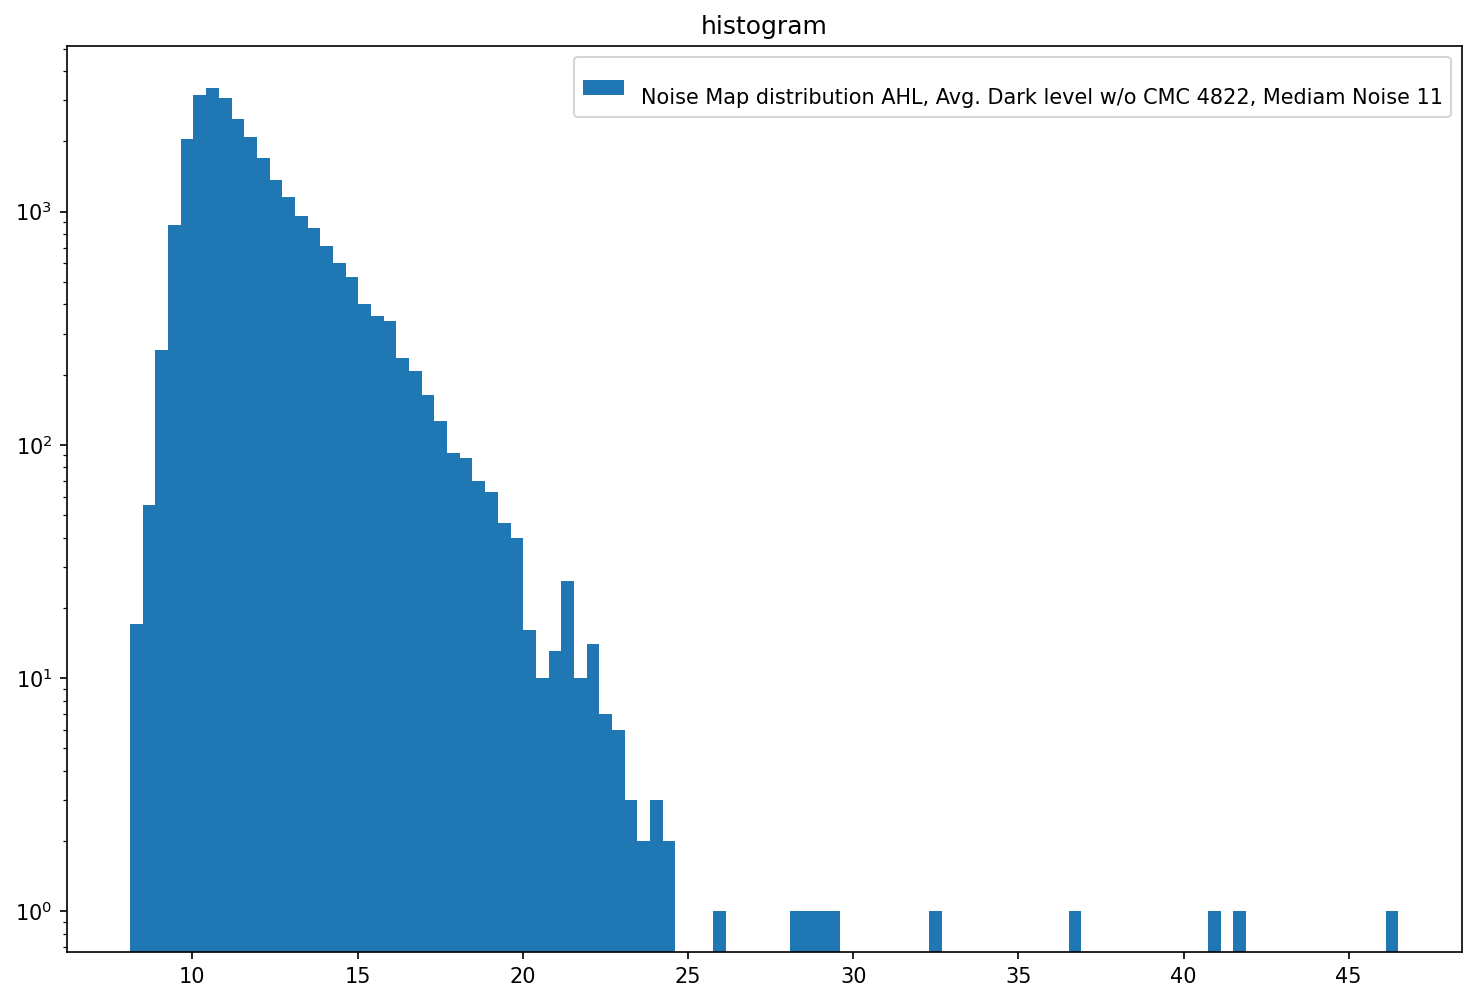


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 17
VRef_DAC 53
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_17_VRrefdac_53_run1.dat
Aquisition Counter 1431859
Number of frames received: 10004
Number of frames received: 12006
Number of frames received: 14009
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


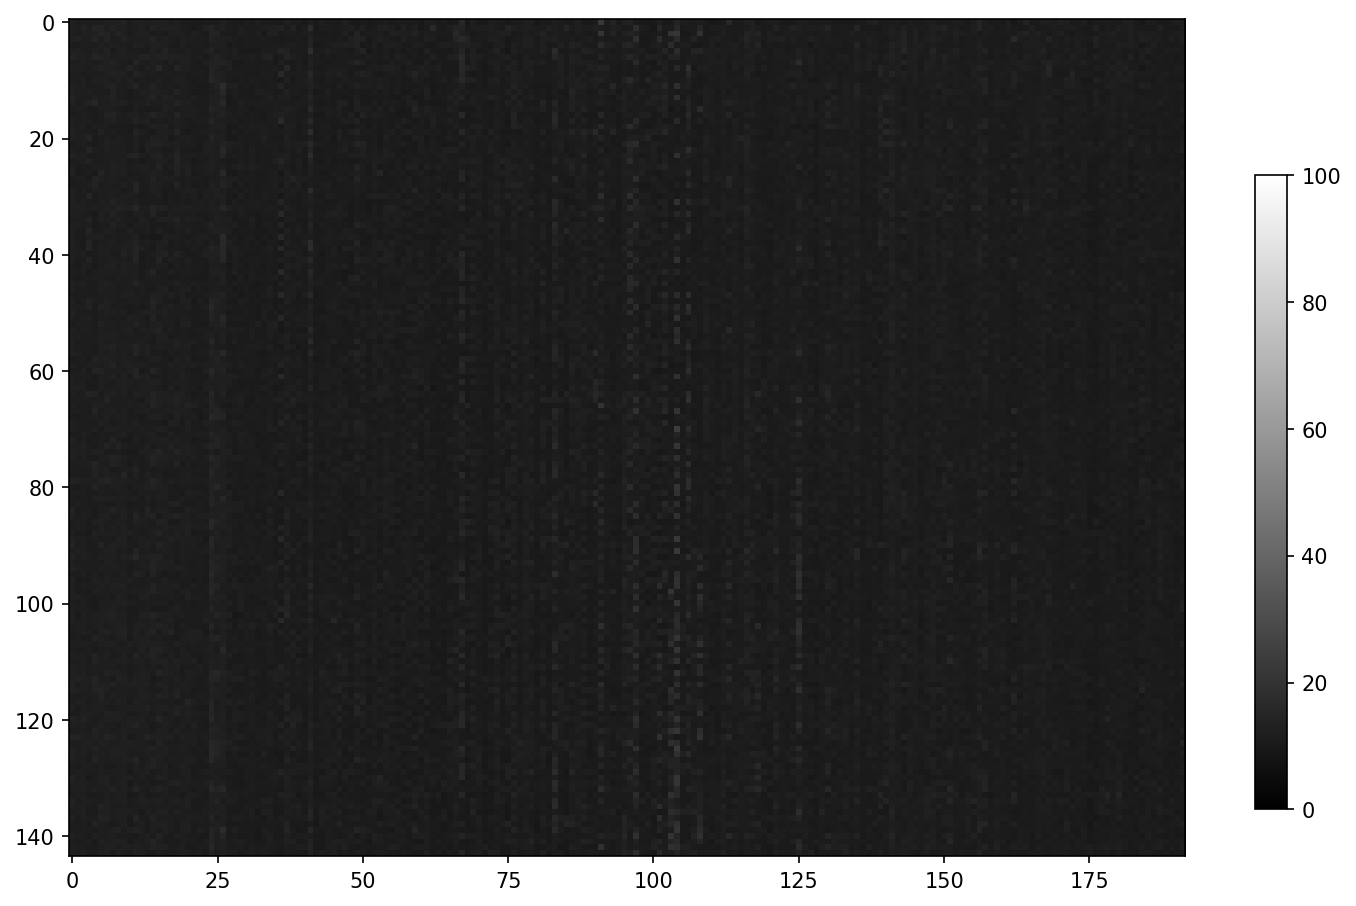

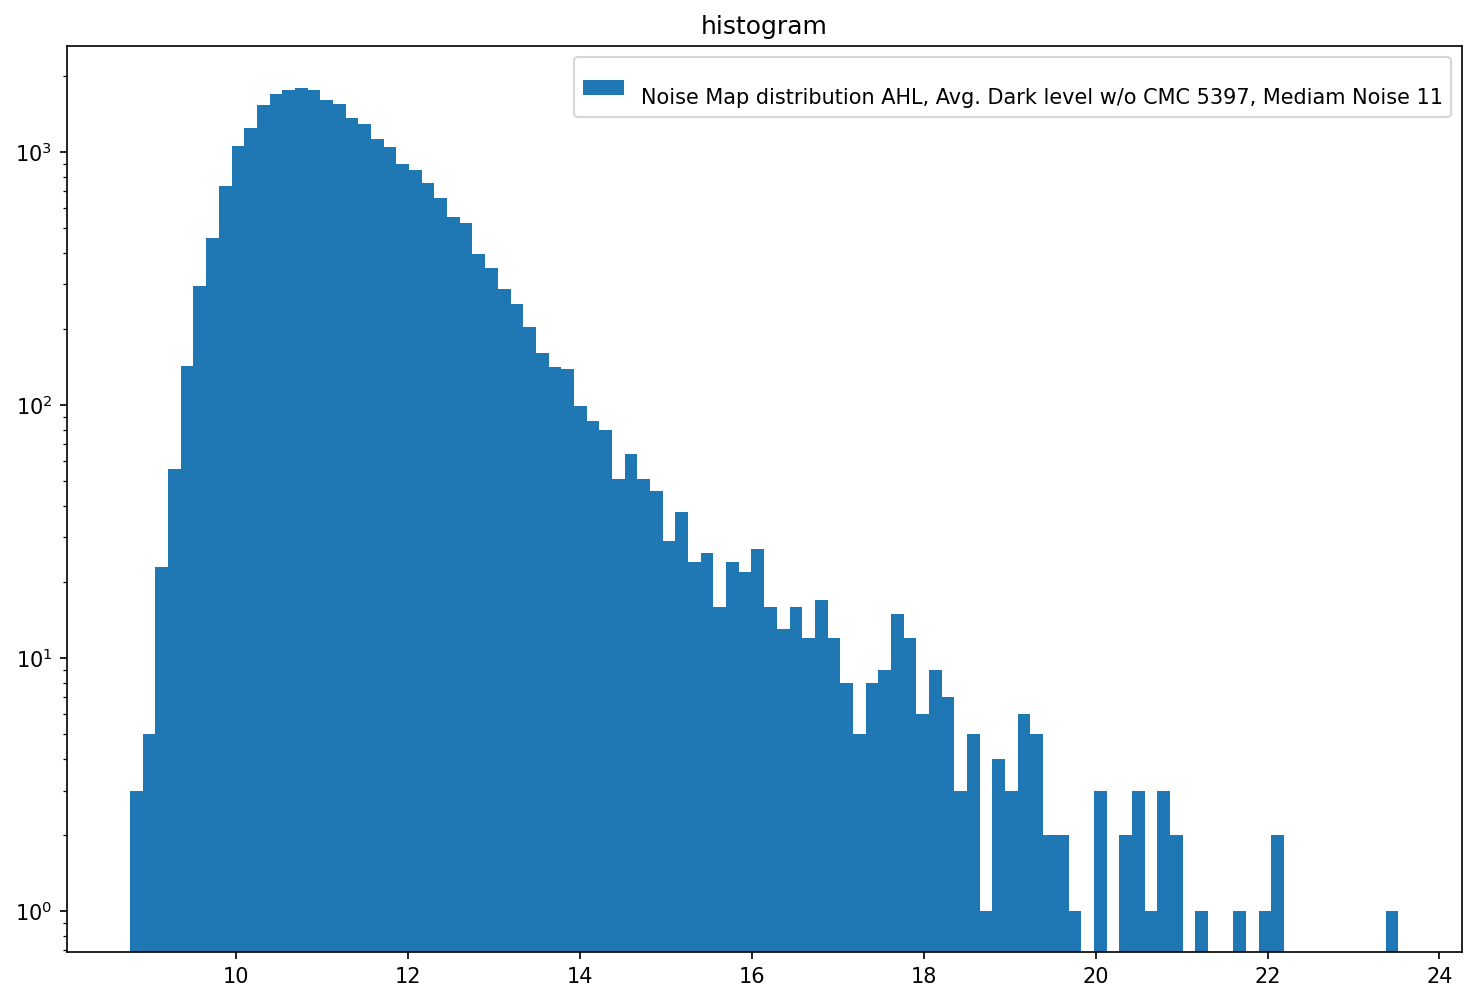


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 17
VRef_DAC 58
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_17_VRrefdac_58_run1.dat
Aquisition Counter 1445868
Number of frames received: 10008
Number of frames received: 12011
Number of frames received: 14013
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


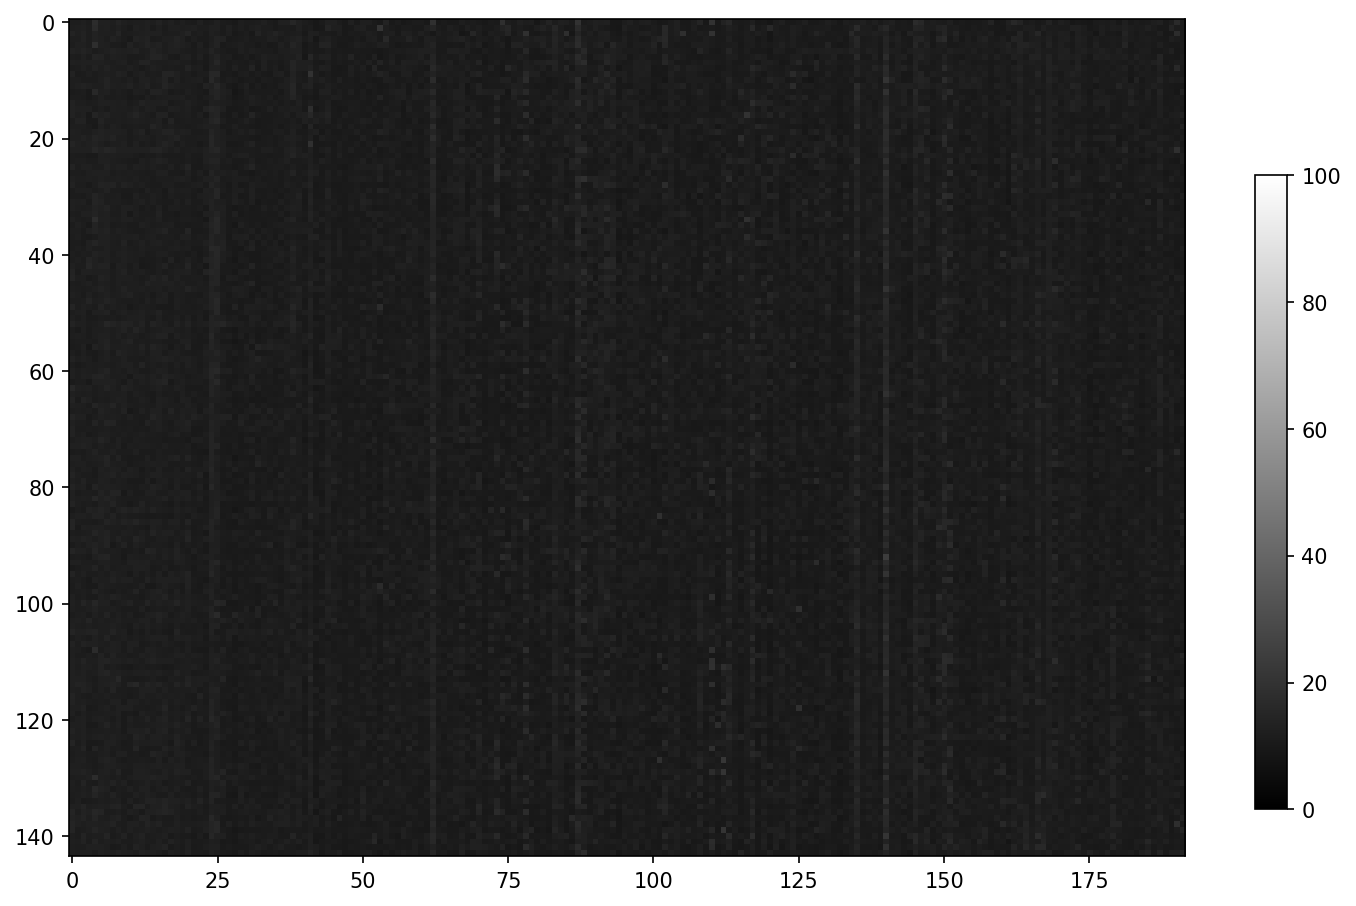

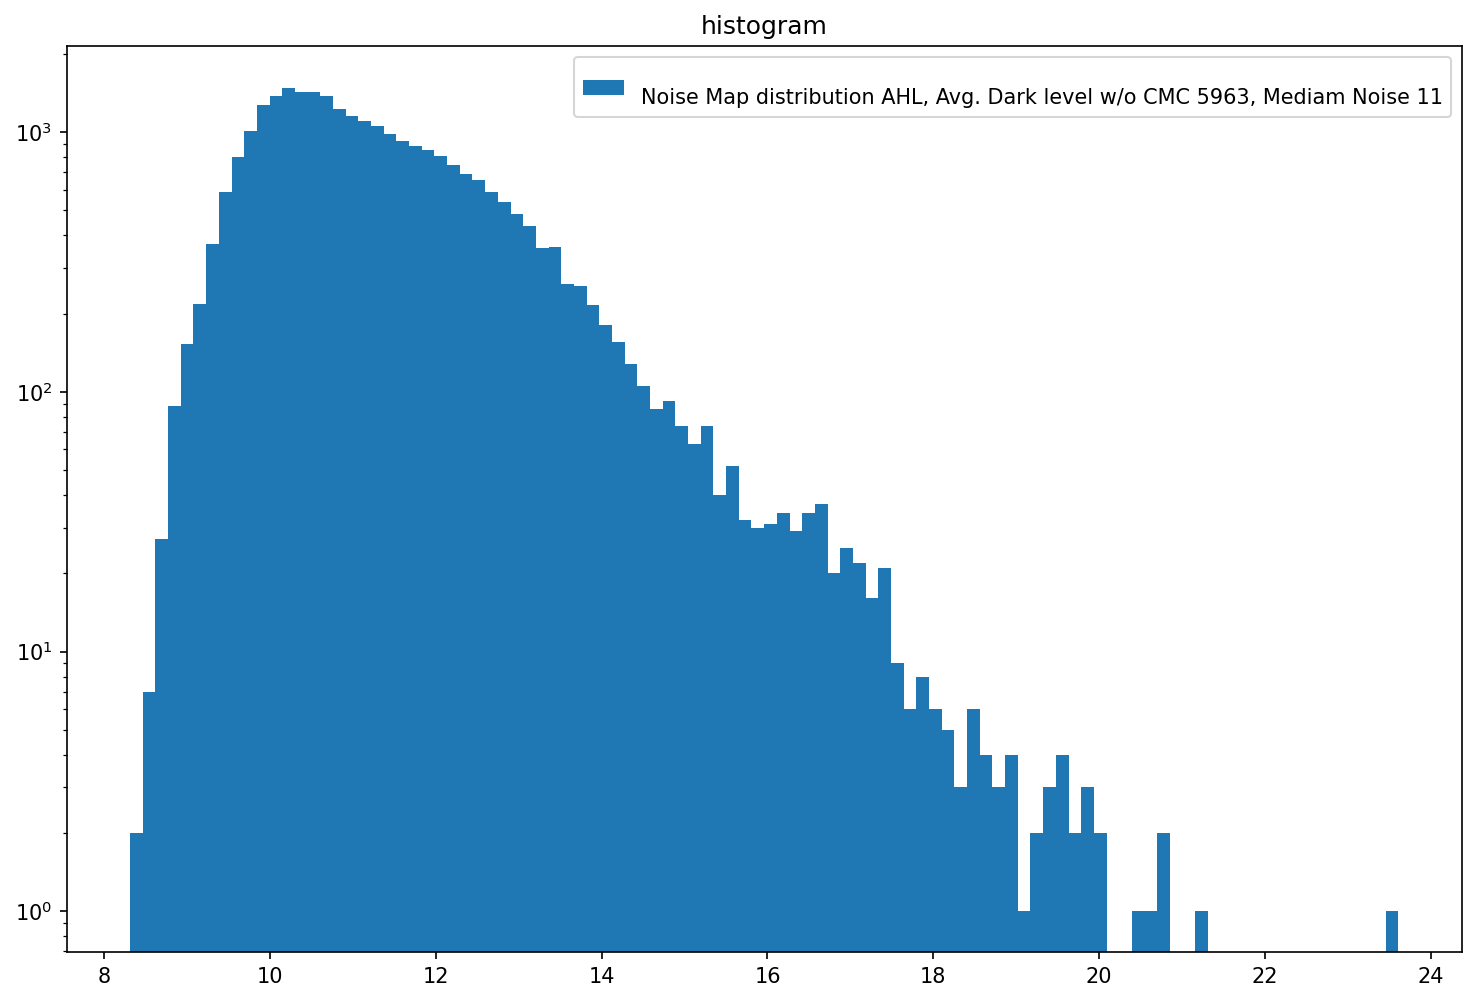


Preamp 2
Vld1_b 0
Pixel_CB 2
Filter_DAC 17
VRef_DAC 63
/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_2_Vld1b_0_PixelCB_2_Filter_DAC_17_VRrefdac_63_run1.dat
Aquisition Counter 1459881
Number of frames received: 10006
Number of frames received: 12009
Number of frames received: 14012
Starting to get data set 0
Read 1000 frames
numberOfFrames in the 3D array:  1000
Starting descrambling images
(1000, 56088)
(144, 384)


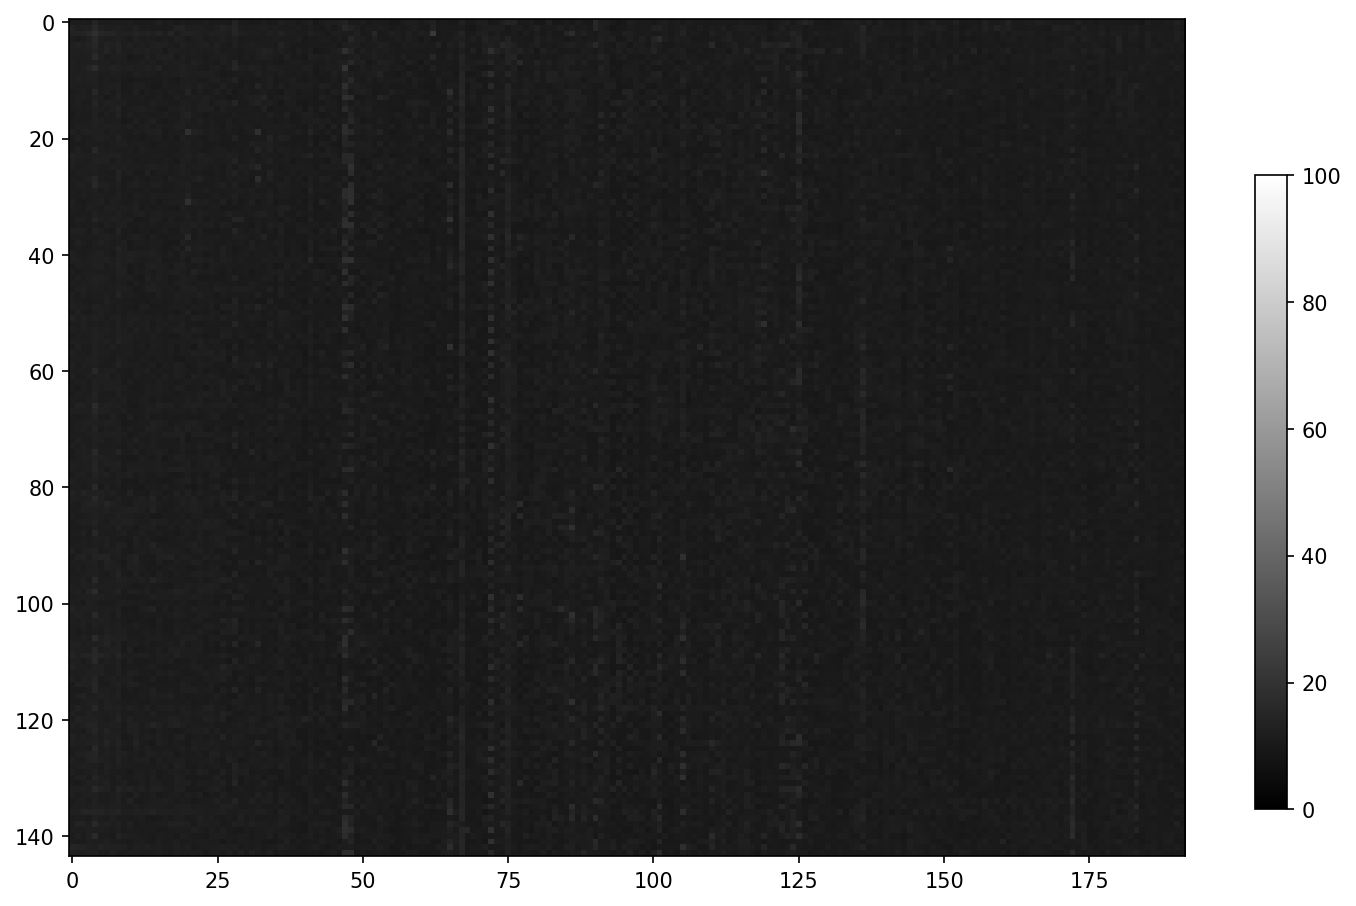

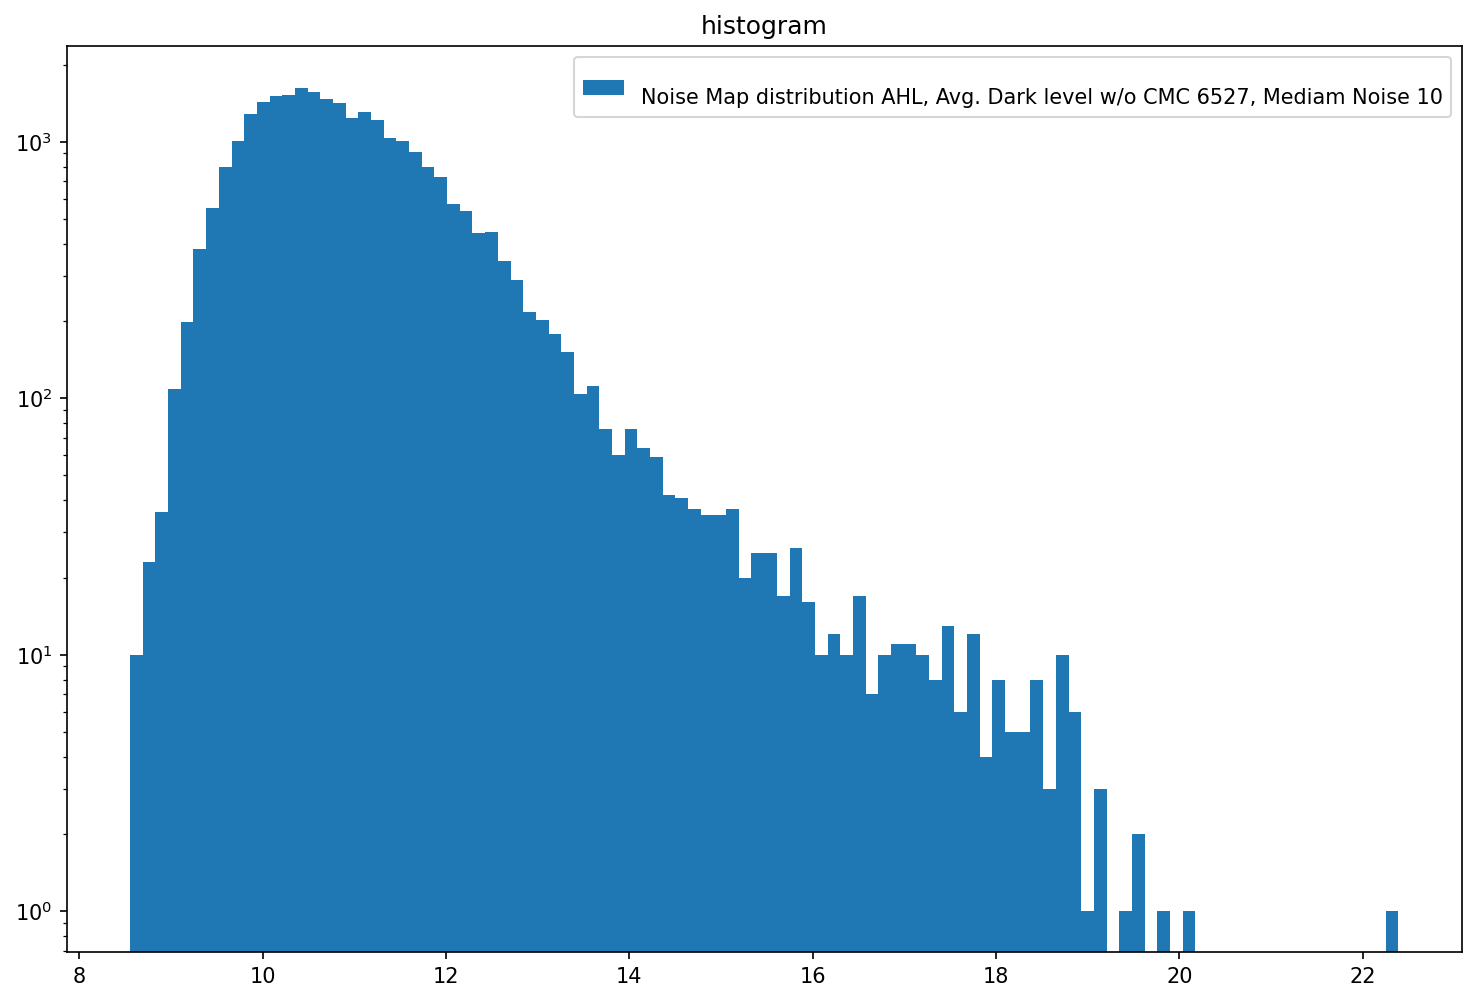


ERROR:pyrogue.PollQueue:Block::checkTransaction: General Error: Transaction error for block ePixHr10kT.EpixHR.PacketRegisters0.DataCntLaneReg[6] with address 0x95000318. Error Timeout waiting for register transaction 26282861 message response.
Traceback (most recent call last):
  File "/afs/slac.stanford.edu/g/reseng/vol31/anaconda/anaconda3/envs/rogue_v5.14.0/lib/python3.9/site-packages/pyrogue/_PollQueue.py", line 169, in _poll
    pr.checkTransaction(entry.block)
  File "/afs/slac.stanford.edu/g/reseng/vol31/anaconda/anaconda3/envs/rogue_v5.14.0/lib/python3.9/site-packages/pyrogue/_Block.py", line 30, in checkTransaction
    block._checkTransaction()
rogue.GeneralError: Block::checkTransaction: General Error: Transaction error for block ePixHr10kT.EpixHR.PacketRegisters0.DataCntLaneReg[6] with address 0x95000318. Error Timeout waiting for register transaction 26282861 message response.
ERROR:pyrogue.PollQueue:Block::checkTransaction: General Error: Transaction error for block ePixH

In [17]:
Preamp = 2
Vld1_b = 0
Pixel_CB= 2
Filter_DAC= 17
VRef_DACList =[3, 13, 23, 33, 43, 48, 53, 58, 63]

for VRef_DAC in VRef_DACList:
    setPixel (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC)

    ######################################################################################################################
    # Remove previous dataset
    filename = (f'/u2/ddoering/ASIC_V3_ASIC2_SB_SET_1/ePixHR10kTLCLSIITiming_ASICV3_ASIC2_noise_320MHz_Preamp_%d_Vld1b_%d_PixelCB_%d_Filter_DAC_%d_VRrefdac_%d_run1.dat' % (Preamp, Vld1_b, Pixel_CB, Filter_DAC, VRef_DAC))
    ########################################################################################################################
    imgDesc = run_asic_test()
    ########################################################################################################################
    [noiseMap, darkAvg] = noise_print()